## Imports and Hyperparameters

In [1]:
import os
import glob
from typing import Optional, List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Activation, CenterCrop
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from classifiers.WDI_1NN import WDI_1NN
from classifiers.ACM_SVM import ACM_SVM
from classifiers.CASIM import CASIM
from classifiers.EAC_1NN import EAC_KNN
from classifiers.MBW_LR import MBW_LR

In [2]:
RANDOM_SEED = 42
N_REPEATS = 20
N_SPLITS = 5
MAX_DATA_LENGTH = 60
PERTURBATION_STEP_SIZE = 0.05
PERTURBATION_STEPS = 20
NUM_EPOCHS = 50

SAVE_DIR_TEP = "results/tep"
SAVE_DIR_FCC = "results/fcc"

wdi_1nn_params = {"template_threshold": 0.5, "n_neighbors": 1}
acm_svm_params = {None}
casim_params={
        "num_features": 672,
        "n_estimators": 1,
        "n_jobs_multirocket": 1,
        "random_state": RANDOM_SEED,
        "alphas": np.logspace(-3, 3, 10),
    }
eac_1nn_params = {"attenuation_coefficient_per_min": 0.0667, "n_neighbors": 1}
mbw_lr_params = {
        "penalty": None,
        "fit_intercept": False,
        "solver": "lbfgs",
        "multi_class": "ovr",
        "decision_bounds": True,
        "confidence_interval": 1.96,
    }

CLASSIFIERS = {
    "WDI_1NN": (WDI_1NN, wdi_1nn_params),
    "CASIM": (CASIM, casim_params),
    "EAC_1NN": (EAC_KNN, eac_1nn_params),
    "MBW_LR": (MBW_LR, mbw_lr_params),
    "ACM_SVM": (ACM_SVM, acm_svm_params),
}

CLASSIFIERS_EAC_KNN = {}
for i in [1, 5, 10, 25, 50]:
    params = {"attenuation_coefficient_per_min": 0.0667, "n_neighbors": i}
    CLASSIFIERS_EAC_KNN[f"EAC_{i}NN"] = (EAC_KNN, params)

## Load Data and Original Labels

In [3]:
def load_dataset_from_folder(base_path, max_data_length):
    """
    Load time-series CSV files organized in subfolders per class.

    Parameters
    - base_path: str or Path to the folder containing one subfolder per class.
                 Each class subfolder should contain CSV files (all same shape).
    - max_data_length: int, maximum length of the time series data (number of timesteps).

    Returns
    - X: numpy array of shape (n_samples, n_variables, n_timesteps)
    - y: numpy array of integer labels (0..n_classes-1)

    Prints shapes of X and y.
    """

    data = []
    labels = []

    # Find subfolders (classes) in deterministic order
    class_folders = sorted(
        [
            d for d in os.listdir(base_path)
            if os.path.isdir(os.path.join(base_path, d))
        ]
    )
    if not class_folders:
        raise ValueError(f"No class subfolders found in {base_path}")

    # Build list of files to load (with labels) to show a single progress bar
    files_to_load = []
    for label, class_name in enumerate(class_folders):
        class_dir = os.path.join(base_path, class_name)
        # Collect CSV files in deterministic order
        csv_files = sorted(
            [
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(".csv")
            ]
        )
        if not csv_files:
            raise ValueError(f"No CSV files found in class folder {class_dir}")

        for fname in csv_files:
            files_to_load.append((os.path.join(class_dir, fname), label))

    # Iterate with tqdm progress bar
    for csv_path, label in tqdm(files_to_load, desc="Loading dataset", unit="file"):
        df = pd.read_csv(csv_path, index_col=0)
        arr = df.values.T  # transpose to match original layout: (variables, timesteps)
        data.append(arr)
        labels.append(label)

    # Ensure all samples have the same shape
    shapes = {a.shape for a in data}
    if len(shapes) != 1:
        raise ValueError(f"Inconsistent sample shapes found: {shapes}")

    X = np.array(data)
    y = np.array(labels)

    # Resize data to max_data_length if necessary
    if X.shape[2] > max_data_length:
        X = X[:, :, :max_data_length]

    print("Data shape: {}".format(X.shape))
    print("Labels shape: {}".format(y.shape))

    return X, y

## Label Perturbation

In [4]:
class CAELabelPerturber:
    """
    Class to handle label perturbation operations based on autoencoder latent distances.

    The autoencoder is a convolutional encoder-decoder:
    - Input: (features, time)
    - Internally reshaped to (features, time, 1)
    - Encoder: Conv2D stack -> latent feature map
    - Encoder model outputs flattened latent vector (for Euclidean distances)
    """

    def __init__(self,
                 random_state: Optional[int] = None,
                 latent_dim: int = 32,
                 epochs: int = 10):
        """
        Parameters
        ----------
        random_state : int or None
            Random seed for reproducibility.
        latent_dim : int
            Number of filters in the final encoder Conv2D layer (depth of latent_map).
        epochs : int
            Number of epochs for autoencoder training.
        """
        self.random_state = random_state
        self.latent_dim = latent_dim
        self.epochs = epochs

        self.perturbation_map: Optional[List[Dict[str, Any]]] = None
        self.X = None
        self.y = None

        self.autoencoder: Optional[Model] = None
        self.encoder: Optional[Model] = None

        # Scaler for normalizing distances to [0, 1]
        self.scaler = MinMaxScaler()

    def _build_autoencoder(self, input_shape):
        """
        Build CNN autoencoder model for binary time series data.

        Parameters
        ----------
        input_shape : tuple
            Shape of a single sample (features, time).
        """
        height, width = input_shape  # (features, time)

        # Add channel dimension for Conv2D: (features, time, 1)
        inp = Input(shape=(height, width, 1), name="encoder_input")

        # Encoder (all CNN)
        x = Conv2D(32, 3, strides=2, padding="same",
                   activation="relu", name="enc_conv_32")(inp)
        x = Conv2D(64, 3, strides=2, padding="same",
                   activation="relu", name="enc_conv_64")(x)
        x = Conv2D(128, 3, strides=2, padding="same",
                   activation="relu", name="enc_conv_128")(x)
        latent_map = Conv2D(self.latent_dim, 3, strides=2, padding="same",
                            activation="relu", name="latent_map")(x)

        # Decoder (mirror of encoder)
        y = Conv2DTranspose(128, 3, strides=2, padding="same",
                            activation="relu", name="dec_deconv_128")(latent_map)
        y = Conv2DTranspose(64, 3, strides=2, padding="same",
                            activation="relu", name="dec_deconv_64")(y)
        y = Conv2DTranspose(32, 3, strides=2, padding="same",
                            activation="relu", name="dec_deconv_32")(y)
        y = Conv2DTranspose(1, 3, strides=2, padding="same",
                            name="dec_deconv_1")(y)

        # Sigmoid -> probabilities of "alarm active"
        y = Activation("sigmoid", name="recon_prob")(y)

        # Ensure exact spatial size (features, time)
        y = CenterCrop(height, width, name="center_crop")(y)

        # Autoencoder model: from input to reconstructed probabilities
        self.autoencoder = Model(inp, y, name="autoencoder")

        # Encoder model: from input to flattened latent vector
        latent_flat = Flatten(name="latent_flat")(latent_map)
        self.encoder = Model(inp, latent_flat, name="encoder")

        # Loss and metric (binary reconstruction)
        bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        bin_acc = tf.keras.metrics.BinaryAccuracy(
            threshold=0.5, name="bin_acc"
        )

        self.autoencoder.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=bce_loss,
            metrics=[bin_acc],
        )

    def _latent_distance(self, latent1: np.ndarray, latent2: np.ndarray) -> float:
        """
        Calculate Euclidean distance between latent representations.

        Parameters
        ----------
        latent1, latent2 : np.ndarray
            Latent-space vectors.

        Returns
        -------
        float
            Euclidean distance.
        """
        euclidean_dist = np.linalg.norm(latent1 - latent2)
        return euclidean_dist

    def fit_labels(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the perturber by training the autoencoder and creating the perturbation map.

        Parameters
        ----------
        X : np.ndarray
            Input data of shape (n_samples, features, time). Values are expected to be binary (0/1)
            or at least bounded in [0, 1].
        y : np.ndarray
            Array of class labels (one per sample).
        """
        self.X = X
        self.y = y
        n_samples = len(X)

        # Build autoencoder for this input shape
        input_shape = X.shape[1:]  # (features, time)
        self._build_autoencoder(input_shape)

        # Normalize input data to [0, 1] if possible
        X_float = X.astype("float32")
        max_val = np.max(X_float)
        if max_val > 0.0:
            X_normalized = X_float / max_val
        else:
            X_normalized = X_float

        # Add channel dimension: (n_samples, features, time, 1)
        X_ae = X_normalized[..., np.newaxis]

        # Train autoencoder
        print(f"Training autoencoder for {self.epochs} epochs...")
        if self.random_state is not None:
            tf.random.set_seed(self.random_state)
            np.random.seed(self.random_state)

        history = self.autoencoder.fit(
            X_ae, X_ae,
            epochs=self.epochs,
            batch_size=32,
            verbose=1,
            validation_split=0.1,
        )
        print("Autoencoder training completed.")

        # Get latent representations (flattened)
        latent_representations = self.encoder.predict(X_ae, verbose=0)

        # Normalize distances using all pairwise distances
        all_distances = []
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                dist = self._latent_distance(
                    latent_representations[i], latent_representations[j]
                )
                all_distances.append(dist)

        all_distances = np.array(all_distances).reshape(-1, 1)
        self.scaler.fit(all_distances)

        # Build perturbation map: for each sample, find closest sample from a different class
        self.perturbation_map = []

        for i in tqdm(range(n_samples), desc="Building perturbation map"):
            current_latent = latent_representations[i]
            current_label = y[i]

            min_distance = float("inf")
            closest_different_label = None

            for j in range(n_samples):
                if i == j:
                    continue
                if y[j] == current_label:
                    continue

                distance = self._latent_distance(
                    current_latent, latent_representations[j]
                )
                distance_normalized = self.scaler.transform([[distance]])[0][0]

                if distance_normalized < min_distance:
                    min_distance = distance_normalized
                    closest_different_label = y[j]

            self.perturbation_map.append(
                {
                    "original_label": current_label,
                    "new_label": closest_different_label,
                    "distance": min_distance,
                }
            )
        print("Built perturbation map.")

    def perturb_labels(self,
                       y: np.ndarray,
                       perturbation_level: int,
                       perturbation_step_size: float = 0.1) -> np.ndarray:
        """
        Perturb labels based on the perturbation map and a given perturbation level.

        Parameters
        ----------
        y : np.ndarray
            Array of labels (should match the y used in fit_labels).
        perturbation_level : int
            Integer step level (0 = no perturbation).
        perturbation_step_size : float
            Fraction of samples to perturb per step (e.g., 0.1 = 10% per level).

        Returns
        -------
        np.ndarray
            Perturbed labels.
        """
        if perturbation_level == 0 or self.perturbation_map is None:
            return y.copy()

        if self.random_state is not None:
            np.random.seed(self.random_state)

        y_perturbed = y.copy()
        num_samples = len(y)
        
        # Get unique classes
        unique_classes = np.unique(y)
        
        # For each class, find the top X% with smallest distances
        perturb_indices = []
        
        for class_label in unique_classes:
            # Find indices of samples belonging to this class
            class_indices = np.where(y == class_label)[0]
            
            # Get perturbation info for this class
            class_perturbation_info = [(idx, self.perturbation_map[idx]["distance"]) 
                                     for idx in class_indices 
                                     if self.perturbation_map[idx]["new_label"] is not None]
            
            if not class_perturbation_info:
                continue
                
            # Sort by distance (ascending) for this class
            class_perturbation_info.sort(key=lambda x: x[1])
            
            # Calculate number to perturb for this class
            num_class_samples = len(class_indices)
            num_perturb_class = int(num_class_samples * perturbation_step_size * perturbation_level)
            
            if num_perturb_class == 0:
                continue
                
            # Select the samples with lowest distances for this class
            class_perturb_indices = [idx for idx, _ in class_perturbation_info[:num_perturb_class]]
            perturb_indices.extend(class_perturb_indices)

        # Apply perturbations
        for idx in perturb_indices:
            new_label = self.perturbation_map[idx]["new_label"]
            if new_label is not None:
                y_perturbed[idx] = new_label

        return y_perturbed

## Robustness Tester

In [5]:
class RobustnessTester:
    """Class to test model robustness against label perturbations"""
    
    def __init__(self, classifiers_dict, perturber, n_splits=5, n_repeats=1, perturbation_step_size=0.1, 
                 random_state=None):
        """
        Parameters:
        - classifiers_dict: dictionary with classifier info {name: (class, params)}
        - perturber: LabelPerturber instance
        - n_splits: number of CV folds
        - n_repeats: number of CV repeats
        - perturbation_step_size: percentage per perturbation step
        - random_state: random seed for reproducibility
        """
        self.classifiers_dict = classifiers_dict
        self.perturber = perturber
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.perturbation_step_size = perturbation_step_size
        self.random_state = random_state
    
    def _process_confusion_matrices(self, confusion_matrices, classifier_name, y):
        """Helper function to process confusion matrices into DataFrame"""
        cm_list = []
        for step, cm in confusion_matrices.items():
            cm_flat = cm.flatten()
            cm_dict = {
                f'cm_{i}_{j}': cm_flat[i * len(np.unique(y)) + j]
                for i in range(len(np.unique(y)))
                for j in range(len(np.unique(y)))
            }
            cm_dict['classifier'] = classifier_name
            cm_dict['perturbation_percentage'] = round(self.perturbation_step_size * step * 100)
            cm_list.append(cm_dict)
        
        return pd.DataFrame(cm_list).set_index('perturbation_percentage')
    
    def _process_perturbation_maps(self, perturbation_maps_per_fold, y_train_folds):
        """Helper function to process perturbation maps into DataFrame"""
        pm_list = []
        unique_labels = np.unique(np.concatenate(y_train_folds))
        
        for fold, fold_maps in enumerate(perturbation_maps_per_fold):
            # Initialize confusion matrix structure for this fold
            cm_shape = (len(unique_labels), len(unique_labels))
            fold_cm = np.zeros(cm_shape, dtype=float)  # use float for safe division later
            
            # Aggregate all perturbations for this fold
            for perturbation in fold_maps:
                original_label = perturbation['original_label']
                target_label = perturbation['new_label']
                
                # Skip entries without a valid target label (just to be safe)
                if target_label is None:
                    continue
                
                # Convert labels to indices for confusion matrix
                orig_idx = np.where(unique_labels == original_label)[0][0]
                target_idx = np.where(unique_labels == target_label)[0][0]
                fold_cm[orig_idx, target_idx] += 1
            
            # --- NEW: normalize out repeated counting of the same map per fold ---
            n_train = len(y_train_folds[fold])
            total = fold_cm.sum()
            if n_train > 0 and total > n_train:
                # Average number of times each sample was counted
                factor = total / n_train
                # Round to nearest integer factor (should be very close to an integer)
                factor_int = max(1, int(round(factor)))
                if factor_int > 1:
                    fold_cm = fold_cm / factor_int
            
            # Convert back to integer counts
            fold_cm = fold_cm.astype(int)
            
            # Convert to dictionary format
            cm_flat = fold_cm.flatten()
            cm_dict = {
                f'cm_{i}_{j}': cm_flat[i * len(unique_labels) + j]
                for i in range(len(unique_labels))
                for j in range(len(unique_labels))
            }
            cm_dict['fold'] = fold
            pm_list.append(cm_dict)
        
        return pd.DataFrame(pm_list).set_index('fold')

        
    def test_robustness(self, X, y, perturbation_steps=10):
        """
        Test robustness of all classifiers against label perturbation.
        
        Parameters:
        - X: feature data
        - y: labels
        - perturbation_steps: maximum perturbation level to test
        
        Returns:
        - results dict with DataFrames for each classifier
        - confusion_matrices dict with DataFrames for each classifier
        - perturbation_maps DataFrame (shared across all classifiers)
        """
        np.random.seed(self.random_state)
        skf = RepeatedStratifiedKFold(
            n_splits=self.n_splits,
            n_repeats=self.n_repeats,
            random_state=self.random_state
        )
        
        # Initialize storage for all classifiers
        all_results = {name: [] for name in self.classifiers_dict.keys()}
        all_confusion_matrices = {
            name: {step: None for step in range(0, perturbation_steps + 1)}
            for name in self.classifiers_dict.keys()
        }
        perturbation_maps_per_fold = []
        y_train_folds = []
        
        # Main loop: folds first
        for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
            print(f"Processing Fold {fold}...")
            
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            y_train_folds.append(y_train)
            
            # Fit perturber on training data (once per fold)
            self.perturber.fit_labels(X_train, y_train)
            
            # Prepare parallel computation for perturbation steps
            steps = list(range(0, perturbation_steps + 1))
            
            def _process_step(step):
                """
                Worker function for a single perturbation step.
                Returns:
                - step index
                - list of result dicts (one per classifier)
                - dict of confusion matrices {classifier_name: cm}
                - perturbation map for this step (copy of self.perturber.perturbation_map)
                """
                # Perturb training labels using fitted perturber
                y_train_perturbed = self.perturber.perturb_labels(
                    y_train, step, self.perturbation_step_size
                )
                perturbation_percentage = round(self.perturbation_step_size * step * 100)
                
                step_results = []
                step_cms = {}
                
                # Loop over classifiers
                for classifier_name, (classifier_class, classifier_params) in self.classifiers_dict.items():
                    # Train model on perturbed data
                    model_instance = classifier_class(classifier_params)
                    model_instance.fit(X_train, y_train_perturbed)
                    
                    # Evaluate on unperturbed test data
                    y_pred = model_instance.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    
                    step_results.append({
                        'classifier_name': classifier_name,
                        'fold': fold,
                        'perturbation_percentage': perturbation_percentage,
                        'accuracy': accuracy
                    })
                    
                    # Confusion matrix for this classifier and step (for this fold only)
                    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
                    step_cms[classifier_name] = cm
                
                # Copy perturbation map (same for all steps, but we preserve original behavior)
                step_pm = self.perturber.perturbation_map.copy()
                
                return step, step_results, step_cms, step_pm
            
            # Parallel execution over perturbation steps
            # n_jobs=-1 uses all available cores; adjust as needed
            parallel_outputs = Parallel(n_jobs=-1)(
                delayed(_process_step)(step)
                for step in tqdm(steps, desc="Perturbation steps")
            )
            
            # Aggregate results from all steps for this fold
            fold_perturbation_maps = []
            
            for step, step_results, step_cms, step_pm in parallel_outputs:
                # Append per-classifier results
                for res in step_results:
                    classifier_name = res['classifier_name']
                    # Store without classifier_name (keyed by dict)
                    all_results[classifier_name].append({
                        'fold': res['fold'],
                        'perturbation_percentage': res['perturbation_percentage'],
                        'accuracy': res['accuracy']
                    })
                
                # Accumulate confusion matrices over folds
                for classifier_name, cm in step_cms.items():
                    if all_confusion_matrices[classifier_name][step] is None:
                        all_confusion_matrices[classifier_name][step] = cm
                    else:
                        all_confusion_matrices[classifier_name][step] += cm
                
                # Preserve original behavior: extend maps for each step
                fold_perturbation_maps.extend(step_pm)
            
            # Store perturbation maps for this fold
            perturbation_maps_per_fold.append(fold_perturbation_maps)
        
        # Process results for each classifier
        processed_results = {}
        processed_confusion_matrices = {}
        
        for classifier_name in self.classifiers_dict.keys():
            # Process accuracy results
            results_df = pd.DataFrame(all_results[classifier_name])
            results_pivot = results_df.pivot_table(
                index='perturbation_percentage', 
                columns='fold', 
                values='accuracy'
            )
            results_pivot['average'] = results_pivot.mean(axis=1)
            processed_results[classifier_name] = results_pivot
            
            # Process confusion matrices
            processed_confusion_matrices[classifier_name] = self._process_confusion_matrices(
                all_confusion_matrices[classifier_name], classifier_name, y
            )
        
        # Process perturbation maps (shared across all classifiers)
        perturbation_maps_df = self._process_perturbation_maps(
            perturbation_maps_per_fold, y_train_folds
        )
        
        return processed_results, processed_confusion_matrices, perturbation_maps_df
    
    def test_all_classifiers(self, X, y, perturbation_steps=10, results_folder=None):
        """
        Test robustness of all classifiers in the dictionary.
        
        Parameters:
        - X: feature data
        - y: labels  
        - perturbation_steps: maximum perturbation level to test
        - results_folder: folder to save results CSV files

        Returns:
        - Dictionary with results for each classifier
        """
        print(f"\nTesting robustness of all classifiers...")
        
        results, cm, pm = self.test_robustness(X, y, perturbation_steps)
        
        all_results = {}
        for classifier_name in self.classifiers_dict.keys():
            all_results[classifier_name] = {
                'results': results[classifier_name], 
                'confusion_matrices': cm[classifier_name],
                'perturbation_maps': pm  # Shared across all classifiers
            }
            
            if results_folder is not None:
                os.makedirs(results_folder, exist_ok=True)
                results[classifier_name].to_csv(
                    f"{results_folder}/{classifier_name}_robustness_results.csv"
                )
                cm[classifier_name].to_csv(
                    f"{results_folder}/{classifier_name}_confusion_matrices.csv"
                )
        
        # Save perturbation maps only once (shared across all classifiers)
        if results_folder is not None:
            pm.to_csv(f"{results_folder}/perturbation_maps.csv")
        
        return all_results

## Visualization

In [6]:
def plot_robustness_results(classifiers_dict, results_folder, save_filename=None):
    """
    Load robustness results and create a visualization plot.
    
    Parameters:
    - classifiers_dict: dictionary of classifiers used in the experiment
    - results_folder: path to folder containing the results CSV files
    - save_filename: optional filename to save the plot (with .svg extension)
    """
    # Load all robustness results CSV files
    files = glob.glob(f'{results_folder}/*_robustness_results.csv')
    
    if not files:
        print(f"No robustness results files found in {results_folder}")
        return
    
    # Initialize a dictionary to store data
    data = {}
    x_labels = None
    
    # Read each file and store the average column
    for file in files:
        # Extract classifier name from filename
        filename = os.path.basename(file)
        classifier_name = filename.replace('_robustness_results.csv', '')
        
        if classifier_name in classifiers_dict:
            df = pd.read_csv(file, index_col=0)
            data[classifier_name] = df['average']
            if x_labels is None:
                x_labels = df.index  # perturbation_percentage values
    
    if not data:
        print("No valid classifier data found")
        return
    
    # Create a DataFrame from the dictionary
    results_df = pd.DataFrame(data)
    
    # Define diverse styles for each classifier
    colors = ['#00B0F0', '#12B65C', '#FFC000', '#FF0400', '#A52A2A', '#800080', '#FFA500', '#008000']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
    markers = ['o', 's', '^', 'v', 'D', 'X', '*', 'P']
    
    markersize = 8
    linewidth = 2.5
    
    # Create style dictionary for each classifier
    styles = {}
    for i, classifier in enumerate(data.keys()):
        styles[classifier] = {
            'color': colors[i % len(colors)],
            'linestyle': linestyles[i % len(linestyles)],
            'marker': markers[i % len(markers)],
            'markersize': markersize,
            'linewidth': linewidth
        }
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for classifier, style in styles.items():
        ax.plot(x_labels, results_df[classifier], label=classifier, **style)
    
    plt.title('Classifier Robustness to Label Perturbation')
    plt.xlabel('Perturbation Percentage (%)')
    plt.ylabel('Average Accuracy')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title='Classifier')
    
    # Save the plot if filename provided
    if save_filename:
        plt.savefig(f'{results_folder}/{save_filename}')
    
    plt.show()

## Experiments

### Tennessee-Eastman Process (TEP)

In [7]:
X, y = load_dataset_from_folder("data/tep", MAX_DATA_LENGTH)

Loading dataset: 100%|██████████| 1000/1000 [00:01<00:00, 683.92file/s]

Data shape: (1000, 50, 60)
Labels shape: (1000,)


In [8]:
perturber = CAELabelPerturber(random_state=RANDOM_SEED, epochs=NUM_EPOCHS)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS,
    perturber=perturber,
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
_ = robustness_tester.test_all_classifiers(X, y, perturbation_steps=PERTURBATION_STEPS, results_folder=SAVE_DIR_TEP)


Testing robustness of all classifiers...
Processing Fold 0...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - bin_acc: 0.9474 - loss: 0.5273 - val_bin_acc: 0.9172 - val_loss: 0.4911
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - bin_acc: 0.9615 - loss: 0.2075 - val_bin_acc: 0.9172 - val_loss: 0.3292
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - bin_acc: 0.9615 - loss: 0.1461 - val_bin_acc: 0.9172 - val_loss: 0.2762
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - bin_acc: 0.9615 - loss: 0.1328 - val_bin_acc: 0.9172 - val_loss: 0.2542
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - bin_acc: 0.9616 - loss: 0.1237 - val_bin_acc: 0.9172 - val_loss: 0.2385
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - bin_acc: 0.9646 - loss: 0.1119 - val_bin_acc: 0.9128 - val_loss: 0.2266
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - bin_acc: 0.9687 - loss: 0.1016 - val_bin_acc: 0.9187 - val_loss: 0.2133
Epoch 8/50
23/23 ━━━━━━━

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 693.31it/s]


Processing Fold 1...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9440 - loss: 0.5371 - val_bin_acc: 0.9159 - val_loss: 0.5756
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2147 - val_bin_acc: 0.9159 - val_loss: 0.3313
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1490 - val_bin_acc: 0.9159 - val_loss: 0.2794
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1343 - val_bin_acc: 0.9159 - val_loss: 0.2560
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1267 - val_bin_acc: 0.9160 - val_loss: 0.2498
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1195 - val_bin_acc: 0.9160 - val_loss: 0.2332
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9673 - loss: 0.1046 - val_bin_acc: 0.9188 - val_loss: 0.2113
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.40it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 32394.40it/s]


Processing Fold 2...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9408 - loss: 0.5504 - val_bin_acc: 0.9159 - val_loss: 0.6576
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9618 - loss: 0.2156 - val_bin_acc: 0.9159 - val_loss: 0.3417
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - bin_acc: 0.9618 - loss: 0.1484 - val_bin_acc: 0.9159 - val_loss: 0.2808
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9618 - loss: 0.1335 - val_bin_acc: 0.9159 - val_loss: 0.2586
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1255 - val_bin_acc: 0.9159 - val_loss: 0.2424
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9621 - loss: 0.1145 - val_bin_acc: 0.9164 - val_loss: 0.2301
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9673 - loss: 0.1016 - val_bin_acc: 0.9232 - val_loss: 0.2122
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.70it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20773.68it/s]


Processing Fold 3...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9484 - loss: 0.5154 - val_bin_acc: 0.9151 - val_loss: 0.5002
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.2090 - val_bin_acc: 0.9151 - val_loss: 0.3886
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9615 - loss: 0.1478 - val_bin_acc: 0.9151 - val_loss: 0.2947
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1346 - val_bin_acc: 0.9151 - val_loss: 0.2676
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1280 - val_bin_acc: 0.9151 - val_loss: 0.2515
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9621 - loss: 0.1195 - val_bin_acc: 0.9141 - val_loss: 0.2382
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9665 - loss: 0.1065 - val_bin_acc: 0.9153 - val_loss: 0.2293
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.96

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.97it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 14056.88it/s]


Processing Fold 4...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9378 - loss: 0.6326 - val_bin_acc: 0.9157 - val_loss: 0.7411
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2626 - val_bin_acc: 0.9157 - val_loss: 0.3463
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1556 - val_bin_acc: 0.9157 - val_loss: 0.3043
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1347 - val_bin_acc: 0.9157 - val_loss: 0.2630
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1246 - val_bin_acc: 0.9157 - val_loss: 0.2402
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9649 - loss: 0.1109 - val_bin_acc: 0.9133 - val_loss: 0.2243
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9697 - loss: 0.0969 - val_bin_acc: 0.9291 - val_loss: 0.1956
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.99it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 5...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9428 - loss: 0.5443 - val_bin_acc: 0.9150 - val_loss: 0.6369
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2213 - val_bin_acc: 0.9150 - val_loss: 0.3635
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1517 - val_bin_acc: 0.9150 - val_loss: 0.2916
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1345 - val_bin_acc: 0.9150 - val_loss: 0.2652
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1267 - val_bin_acc: 0.9150 - val_loss: 0.2446
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9630 - loss: 0.1164 - val_bin_acc: 0.9144 - val_loss: 0.2288
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9683 - loss: 0.1032 - val_bin_acc: 0.9184 - val_loss: 0.2202
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.74it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 6...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9469 - loss: 0.5353 - val_bin_acc: 0.9164 - val_loss: 0.5934
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.2070 - val_bin_acc: 0.9164 - val_loss: 0.3448
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.1491 - val_bin_acc: 0.9164 - val_loss: 0.2835
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1345 - val_bin_acc: 0.9164 - val_loss: 0.2573
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9615 - loss: 0.1260 - val_bin_acc: 0.9164 - val_loss: 0.2386
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9639 - loss: 0.1130 - val_bin_acc: 0.9194 - val_loss: 0.2173
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9693 - loss: 0.0978 - val_bin_acc: 0.9259 - val_loss: 0.1978
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:25<00:00, 31.99it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21071.86it/s]


Processing Fold 7...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - bin_acc: 0.9420 - loss: 0.5767 - val_bin_acc: 0.9167 - val_loss: 0.9689
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9617 - loss: 0.2325 - val_bin_acc: 0.9167 - val_loss: 0.2976
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1534 - val_bin_acc: 0.9167 - val_loss: 0.2731
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1346 - val_bin_acc: 0.9167 - val_loss: 0.2538
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1276 - val_bin_acc: 0.9167 - val_loss: 0.2420
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1203 - val_bin_acc: 0.9174 - val_loss: 0.2256
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9661 - loss: 0.1084 - val_bin_acc: 0.9261 - val_loss: 0.2064
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.91it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20996.52it/s]


Processing Fold 8...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9430 - loss: 0.5415 - val_bin_acc: 0.9173 - val_loss: 0.5710
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.2155 - val_bin_acc: 0.9173 - val_loss: 0.3293
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1451 - val_bin_acc: 0.9173 - val_loss: 0.2671
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1312 - val_bin_acc: 0.9173 - val_loss: 0.2495
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1226 - val_bin_acc: 0.9168 - val_loss: 0.2320
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9645 - loss: 0.1098 - val_bin_acc: 0.9183 - val_loss: 0.2194
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9699 - loss: 0.0960 - val_bin_acc: 0.9248 - val_loss: 0.2060
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.36it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 9...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9350 - loss: 0.6744 - val_bin_acc: 0.9146 - val_loss: 0.5263
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2938 - val_bin_acc: 0.9146 - val_loss: 0.4627
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1570 - val_bin_acc: 0.9146 - val_loss: 0.2967
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1345 - val_bin_acc: 0.9146 - val_loss: 0.2628
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1252 - val_bin_acc: 0.9144 - val_loss: 0.2407
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9643 - loss: 0.1112 - val_bin_acc: 0.9122 - val_loss: 0.2274
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9711 - loss: 0.0948 - val_bin_acc: 0.9259 - val_loss: 0.2000
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.64it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20946.58it/s]


Processing Fold 10...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9502 - loss: 0.5182 - val_bin_acc: 0.9150 - val_loss: 0.3920
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.2019 - val_bin_acc: 0.9150 - val_loss: 0.3674
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1477 - val_bin_acc: 0.9150 - val_loss: 0.2929
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1345 - val_bin_acc: 0.9150 - val_loss: 0.2681
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1266 - val_bin_acc: 0.9150 - val_loss: 0.2502
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9631 - loss: 0.1161 - val_bin_acc: 0.9139 - val_loss: 0.2386
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9690 - loss: 0.1013 - val_bin_acc: 0.9263 - val_loss: 0.2124
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21016.56it/s]


Processing Fold 11...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9464 - loss: 0.5535 - val_bin_acc: 0.9147 - val_loss: 0.7519
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9618 - loss: 0.2210 - val_bin_acc: 0.9147 - val_loss: 0.3378
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9618 - loss: 0.1486 - val_bin_acc: 0.9147 - val_loss: 0.2803
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1333 - val_bin_acc: 0.9147 - val_loss: 0.2555
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1259 - val_bin_acc: 0.9147 - val_loss: 0.2410
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1187 - val_bin_acc: 0.9164 - val_loss: 0.2286
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9645 - loss: 0.1065 - val_bin_acc: 0.9241 - val_loss: 0.2057
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.38it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 12...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9451 - loss: 0.5384 - val_bin_acc: 0.9164 - val_loss: 0.4907
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.2064 - val_bin_acc: 0.9164 - val_loss: 0.3353
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1487 - val_bin_acc: 0.9164 - val_loss: 0.2793
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1339 - val_bin_acc: 0.9164 - val_loss: 0.2578
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1261 - val_bin_acc: 0.9164 - val_loss: 0.2406
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9626 - loss: 0.1143 - val_bin_acc: 0.9154 - val_loss: 0.2190
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9683 - loss: 0.1005 - val_bin_acc: 0.9176 - val_loss: 0.2086
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.29it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 13...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9488 - loss: 0.5199 - val_bin_acc: 0.9151 - val_loss: 0.4648
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2102 - val_bin_acc: 0.9151 - val_loss: 0.3822
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1485 - val_bin_acc: 0.9151 - val_loss: 0.2859
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1323 - val_bin_acc: 0.9151 - val_loss: 0.2526
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1247 - val_bin_acc: 0.9152 - val_loss: 0.2399
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9627 - loss: 0.1152 - val_bin_acc: 0.9173 - val_loss: 0.2274
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9688 - loss: 0.1003 - val_bin_acc: 0.9284 - val_loss: 0.1983
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.05it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 16534.71it/s]


Processing Fold 14...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9497 - loss: 0.5216 - val_bin_acc: 0.9187 - val_loss: 0.4706
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2090 - val_bin_acc: 0.9187 - val_loss: 0.3672
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1484 - val_bin_acc: 0.9187 - val_loss: 0.2805
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1345 - val_bin_acc: 0.9187 - val_loss: 0.2528
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1271 - val_bin_acc: 0.9187 - val_loss: 0.2368
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9623 - loss: 0.1180 - val_bin_acc: 0.9189 - val_loss: 0.2231
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9670 - loss: 0.1054 - val_bin_acc: 0.9227 - val_loss: 0.2126
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.47it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20966.53it/s]


Processing Fold 15...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9409 - loss: 0.5914 - val_bin_acc: 0.9152 - val_loss: 0.8572
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9616 - loss: 0.2341 - val_bin_acc: 0.9152 - val_loss: 0.3249
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - bin_acc: 0.9616 - loss: 0.1517 - val_bin_acc: 0.9152 - val_loss: 0.2983
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1347 - val_bin_acc: 0.9152 - val_loss: 0.2669
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1276 - val_bin_acc: 0.9152 - val_loss: 0.2487
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9621 - loss: 0.1194 - val_bin_acc: 0.9147 - val_loss: 0.2286
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9670 - loss: 0.1078 - val_bin_acc: 0.9141 - val_loss: 0.2251
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.01it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 16...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - bin_acc: 0.9211 - loss: 0.5596 - val_bin_acc: 0.9185 - val_loss: 0.7717
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9615 - loss: 0.2232 - val_bin_acc: 0.9185 - val_loss: 0.3007
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - bin_acc: 0.9615 - loss: 0.1444 - val_bin_acc: 0.9185 - val_loss: 0.2592
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9615 - loss: 0.1313 - val_bin_acc: 0.9185 - val_loss: 0.2412
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.1236 - val_bin_acc: 0.9183 - val_loss: 0.2249
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9631 - loss: 0.1126 - val_bin_acc: 0.9139 - val_loss: 0.2161
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9688 - loss: 0.0989 - val_bin_acc: 0.9199 - val_loss: 0.2019
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.43it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21036.63it/s]


Processing Fold 17...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9380 - loss: 0.5693 - val_bin_acc: 0.9156 - val_loss: 0.8350
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2220 - val_bin_acc: 0.9156 - val_loss: 0.3209
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1486 - val_bin_acc: 0.9156 - val_loss: 0.2785
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1342 - val_bin_acc: 0.9156 - val_loss: 0.2567
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1269 - val_bin_acc: 0.9156 - val_loss: 0.2374
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9619 - loss: 0.1173 - val_bin_acc: 0.9197 - val_loss: 0.2201
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9670 - loss: 0.1031 - val_bin_acc: 0.9258 - val_loss: 0.2004
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.85it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 18...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9455 - loss: 0.5191 - val_bin_acc: 0.9155 - val_loss: 0.5066
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2073 - val_bin_acc: 0.9155 - val_loss: 0.3497
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1468 - val_bin_acc: 0.9155 - val_loss: 0.2805
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1335 - val_bin_acc: 0.9155 - val_loss: 0.2613
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1271 - val_bin_acc: 0.9155 - val_loss: 0.2494
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9625 - loss: 0.1184 - val_bin_acc: 0.9158 - val_loss: 0.2335
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9682 - loss: 0.1045 - val_bin_acc: 0.9190 - val_loss: 0.2225
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.26it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21041.66it/s]


Processing Fold 19...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9353 - loss: 0.5160 - val_bin_acc: 0.9150 - val_loss: 0.4568
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - bin_acc: 0.9617 - loss: 0.1984 - val_bin_acc: 0.9150 - val_loss: 0.3881
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9617 - loss: 0.1436 - val_bin_acc: 0.9150 - val_loss: 0.2861
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1313 - val_bin_acc: 0.9150 - val_loss: 0.2576
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1244 - val_bin_acc: 0.9150 - val_loss: 0.2412
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9637 - loss: 0.1134 - val_bin_acc: 0.9135 - val_loss: 0.2274
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9693 - loss: 0.0996 - val_bin_acc: 0.9232 - val_loss: 0.2129
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.75it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21006.53it/s]


Processing Fold 20...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9405 - loss: 0.5669 - val_bin_acc: 0.9163 - val_loss: 0.8519
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2251 - val_bin_acc: 0.9163 - val_loss: 0.3261
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1460 - val_bin_acc: 0.9163 - val_loss: 0.2658
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1316 - val_bin_acc: 0.9163 - val_loss: 0.2541
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1233 - val_bin_acc: 0.9163 - val_loss: 0.2423
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9657 - loss: 0.1114 - val_bin_acc: 0.9134 - val_loss: 0.2330
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9694 - loss: 0.0981 - val_bin_acc: 0.9188 - val_loss: 0.2126
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.50it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 21...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9421 - loss: 0.5407 - val_bin_acc: 0.9141 - val_loss: 0.7208
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9617 - loss: 0.2087 - val_bin_acc: 0.9141 - val_loss: 0.3744
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1428 - val_bin_acc: 0.9141 - val_loss: 0.2806
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1304 - val_bin_acc: 0.9141 - val_loss: 0.2549
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1225 - val_bin_acc: 0.9142 - val_loss: 0.2396
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9644 - loss: 0.1106 - val_bin_acc: 0.9143 - val_loss: 0.2267
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9704 - loss: 0.0940 - val_bin_acc: 0.9294 - val_loss: 0.1940
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.61it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 14345.34it/s]


Processing Fold 22...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9390 - loss: 0.5798 - val_bin_acc: 0.9168 - val_loss: 0.8709
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2294 - val_bin_acc: 0.9168 - val_loss: 0.3248
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1562 - val_bin_acc: 0.9168 - val_loss: 0.2911
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1378 - val_bin_acc: 0.9168 - val_loss: 0.2645
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1288 - val_bin_acc: 0.9168 - val_loss: 0.2462
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9625 - loss: 0.1195 - val_bin_acc: 0.9167 - val_loss: 0.2370
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9665 - loss: 0.1068 - val_bin_acc: 0.9170 - val_loss: 0.2235
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.70it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21016.56it/s]


Processing Fold 23...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9419 - loss: 0.5551 - val_bin_acc: 0.9158 - val_loss: 0.7882
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2206 - val_bin_acc: 0.9158 - val_loss: 0.3323
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1514 - val_bin_acc: 0.9158 - val_loss: 0.2999
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1359 - val_bin_acc: 0.9158 - val_loss: 0.2721
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1279 - val_bin_acc: 0.9158 - val_loss: 0.2468
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9631 - loss: 0.1166 - val_bin_acc: 0.9136 - val_loss: 0.2310
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9690 - loss: 0.1014 - val_bin_acc: 0.9196 - val_loss: 0.2160
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.37it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 24...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9530 - loss: 0.5038 - val_bin_acc: 0.9169 - val_loss: 0.4176
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1987 - val_bin_acc: 0.9169 - val_loss: 0.3579
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1450 - val_bin_acc: 0.9169 - val_loss: 0.2754
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1321 - val_bin_acc: 0.9169 - val_loss: 0.2506
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1251 - val_bin_acc: 0.9171 - val_loss: 0.2358
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9622 - loss: 0.1166 - val_bin_acc: 0.9180 - val_loss: 0.2238
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9678 - loss: 0.1039 - val_bin_acc: 0.9234 - val_loss: 0.2091
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.87it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21056.75it/s]


Processing Fold 25...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9450 - loss: 0.5306 - val_bin_acc: 0.9165 - val_loss: 0.4894
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2068 - val_bin_acc: 0.9165 - val_loss: 0.3903
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1486 - val_bin_acc: 0.9165 - val_loss: 0.2852
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1340 - val_bin_acc: 0.9165 - val_loss: 0.2571
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1255 - val_bin_acc: 0.9165 - val_loss: 0.2394
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9627 - loss: 0.1155 - val_bin_acc: 0.9169 - val_loss: 0.2267
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9679 - loss: 0.1012 - val_bin_acc: 0.9231 - val_loss: 0.1991
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.02it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 26...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9445 - loss: 0.5255 - val_bin_acc: 0.9149 - val_loss: 0.4941
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.2072 - val_bin_acc: 0.9149 - val_loss: 0.3653
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1446 - val_bin_acc: 0.9149 - val_loss: 0.2875
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1315 - val_bin_acc: 0.9149 - val_loss: 0.2595
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1245 - val_bin_acc: 0.9149 - val_loss: 0.2435
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9638 - loss: 0.1146 - val_bin_acc: 0.9137 - val_loss: 0.2329
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9691 - loss: 0.1007 - val_bin_acc: 0.9187 - val_loss: 0.2220
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.42it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 27...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9268 - loss: 0.5250 - val_bin_acc: 0.9165 - val_loss: 0.4900
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2106 - val_bin_acc: 0.9165 - val_loss: 0.3755
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.1484 - val_bin_acc: 0.9165 - val_loss: 0.2910
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1333 - val_bin_acc: 0.9165 - val_loss: 0.2507
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1246 - val_bin_acc: 0.9165 - val_loss: 0.2376
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9631 - loss: 0.1137 - val_bin_acc: 0.9164 - val_loss: 0.2141
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9699 - loss: 0.0981 - val_bin_acc: 0.9305 - val_loss: 0.1849
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.04it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 17321.61it/s]


Processing Fold 28...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - bin_acc: 0.9470 - loss: 0.5489 - val_bin_acc: 0.9151 - val_loss: 0.4939
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9617 - loss: 0.2104 - val_bin_acc: 0.9151 - val_loss: 0.3292
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1486 - val_bin_acc: 0.9151 - val_loss: 0.2780
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1330 - val_bin_acc: 0.9151 - val_loss: 0.2590
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1255 - val_bin_acc: 0.9152 - val_loss: 0.2406
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9632 - loss: 0.1164 - val_bin_acc: 0.9178 - val_loss: 0.2296
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9681 - loss: 0.1042 - val_bin_acc: 0.9230 - val_loss: 0.2194
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.70it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 29...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9368 - loss: 0.5752 - val_bin_acc: 0.9168 - val_loss: 0.9739
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2418 - val_bin_acc: 0.9168 - val_loss: 0.3143
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1522 - val_bin_acc: 0.9168 - val_loss: 0.2739
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1339 - val_bin_acc: 0.9168 - val_loss: 0.2523
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1263 - val_bin_acc: 0.9165 - val_loss: 0.2352
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9624 - loss: 0.1168 - val_bin_acc: 0.9156 - val_loss: 0.2192
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9675 - loss: 0.1051 - val_bin_acc: 0.9245 - val_loss: 0.2071
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.22it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 30...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9413 - loss: 0.5371 - val_bin_acc: 0.9146 - val_loss: 0.6545
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.2079 - val_bin_acc: 0.9146 - val_loss: 0.3573
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.1482 - val_bin_acc: 0.9146 - val_loss: 0.2831
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1342 - val_bin_acc: 0.9146 - val_loss: 0.2643
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1257 - val_bin_acc: 0.9146 - val_loss: 0.2479
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9637 - loss: 0.1142 - val_bin_acc: 0.9120 - val_loss: 0.2339
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9688 - loss: 0.1022 - val_bin_acc: 0.9144 - val_loss: 0.2279
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.01it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 31...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.8423 - loss: 0.6063 - val_bin_acc: 0.9157 - val_loss: 0.6673
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2090 - val_bin_acc: 0.9157 - val_loss: 0.3306
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1400 - val_bin_acc: 0.9157 - val_loss: 0.2617
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1284 - val_bin_acc: 0.9157 - val_loss: 0.2484
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1170 - val_bin_acc: 0.9154 - val_loss: 0.2254
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9673 - loss: 0.1008 - val_bin_acc: 0.9302 - val_loss: 0.1968
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9774 - loss: 0.0812 - val_bin_acc: 0.9466 - val_loss: 0.1580
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.62it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20986.51it/s]


Processing Fold 32...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9353 - loss: 0.6002 - val_bin_acc: 0.9172 - val_loss: 0.9280
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9617 - loss: 0.2506 - val_bin_acc: 0.9172 - val_loss: 0.3236
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9617 - loss: 0.1570 - val_bin_acc: 0.9172 - val_loss: 0.3063
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1370 - val_bin_acc: 0.9172 - val_loss: 0.2648
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1292 - val_bin_acc: 0.9172 - val_loss: 0.2468
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1223 - val_bin_acc: 0.9177 - val_loss: 0.2309
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9646 - loss: 0.1111 - val_bin_acc: 0.9236 - val_loss: 0.2110
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.69it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 33...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9360 - loss: 0.5923 - val_bin_acc: 0.9160 - val_loss: 1.0170
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2369 - val_bin_acc: 0.9160 - val_loss: 0.3059
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1524 - val_bin_acc: 0.9160 - val_loss: 0.2954
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1345 - val_bin_acc: 0.9160 - val_loss: 0.2630
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1268 - val_bin_acc: 0.9160 - val_loss: 0.2409
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9629 - loss: 0.1184 - val_bin_acc: 0.9143 - val_loss: 0.2299
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9673 - loss: 0.1077 - val_bin_acc: 0.9152 - val_loss: 0.2224
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.66it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 34...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9470 - loss: 0.5191 - val_bin_acc: 0.9164 - val_loss: 0.5047
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2056 - val_bin_acc: 0.9164 - val_loss: 0.3667
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1449 - val_bin_acc: 0.9164 - val_loss: 0.2793
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1311 - val_bin_acc: 0.9164 - val_loss: 0.2509
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1237 - val_bin_acc: 0.9164 - val_loss: 0.2376
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9644 - loss: 0.1137 - val_bin_acc: 0.9185 - val_loss: 0.2230
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9693 - loss: 0.0995 - val_bin_acc: 0.9262 - val_loss: 0.2036
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.95it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10489.51it/s]


Processing Fold 35...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9462 - loss: 0.5290 - val_bin_acc: 0.9168 - val_loss: 0.5483
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.2050 - val_bin_acc: 0.9168 - val_loss: 0.3616
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1470 - val_bin_acc: 0.9168 - val_loss: 0.2770
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.1320 - val_bin_acc: 0.9168 - val_loss: 0.2546
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1244 - val_bin_acc: 0.9168 - val_loss: 0.2403
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9640 - loss: 0.1139 - val_bin_acc: 0.9146 - val_loss: 0.2280
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9686 - loss: 0.1003 - val_bin_acc: 0.9168 - val_loss: 0.2142
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.50it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10512.04it/s]


Processing Fold 36...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9353 - loss: 0.5937 - val_bin_acc: 0.9155 - val_loss: 1.0351
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.2462 - val_bin_acc: 0.9155 - val_loss: 0.3098
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.1571 - val_bin_acc: 0.9155 - val_loss: 0.3121
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1381 - val_bin_acc: 0.9155 - val_loss: 0.2728
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9615 - loss: 0.1305 - val_bin_acc: 0.9155 - val_loss: 0.2530
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1237 - val_bin_acc: 0.9156 - val_loss: 0.2351
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9649 - loss: 0.1117 - val_bin_acc: 0.9247 - val_loss: 0.2159
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.07it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20976.51it/s]


Processing Fold 37...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9418 - loss: 0.5460 - val_bin_acc: 0.9158 - val_loss: 0.6940
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9616 - loss: 0.2098 - val_bin_acc: 0.9158 - val_loss: 0.3682
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - bin_acc: 0.9616 - loss: 0.1482 - val_bin_acc: 0.9158 - val_loss: 0.2847
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1336 - val_bin_acc: 0.9158 - val_loss: 0.2586
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1254 - val_bin_acc: 0.9158 - val_loss: 0.2429
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9630 - loss: 0.1140 - val_bin_acc: 0.9130 - val_loss: 0.2320
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9693 - loss: 0.0988 - val_bin_acc: 0.9196 - val_loss: 0.2126
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.73it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20966.53it/s]


Processing Fold 38...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9433 - loss: 0.5658 - val_bin_acc: 0.9151 - val_loss: 0.8635
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2190 - val_bin_acc: 0.9151 - val_loss: 0.3228
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1494 - val_bin_acc: 0.9151 - val_loss: 0.2816
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1331 - val_bin_acc: 0.9151 - val_loss: 0.2553
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1223 - val_bin_acc: 0.9148 - val_loss: 0.2371
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9668 - loss: 0.1082 - val_bin_acc: 0.9107 - val_loss: 0.2272
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9708 - loss: 0.0957 - val_bin_acc: 0.9219 - val_loss: 0.2139
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.96it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21006.53it/s]


Processing Fold 39...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9397 - loss: 0.5678 - val_bin_acc: 0.9167 - val_loss: 0.8181
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2247 - val_bin_acc: 0.9167 - val_loss: 0.3104
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1483 - val_bin_acc: 0.9167 - val_loss: 0.2760
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1337 - val_bin_acc: 0.9167 - val_loss: 0.2578
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1266 - val_bin_acc: 0.9167 - val_loss: 0.2438
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9624 - loss: 0.1162 - val_bin_acc: 0.9155 - val_loss: 0.2293
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9677 - loss: 0.1034 - val_bin_acc: 0.9187 - val_loss: 0.2158
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.92it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21066.82it/s]


Processing Fold 40...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - bin_acc: 0.9403 - loss: 0.6198 - val_bin_acc: 0.9161 - val_loss: 0.6543
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - bin_acc: 0.9616 - loss: 0.2492 - val_bin_acc: 0.9161 - val_loss: 0.3353
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - bin_acc: 0.9616 - loss: 0.1560 - val_bin_acc: 0.9161 - val_loss: 0.3061
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1369 - val_bin_acc: 0.9161 - val_loss: 0.2642
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1283 - val_bin_acc: 0.9161 - val_loss: 0.2425
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9626 - loss: 0.1172 - val_bin_acc: 0.9159 - val_loss: 0.2289
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9670 - loss: 0.1034 - val_bin_acc: 0.9196 - val_loss: 0.2120
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.39it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 41...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9435 - loss: 0.5504 - val_bin_acc: 0.9145 - val_loss: 0.6168
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2116 - val_bin_acc: 0.9145 - val_loss: 0.3517
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1460 - val_bin_acc: 0.9145 - val_loss: 0.2850
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1332 - val_bin_acc: 0.9145 - val_loss: 0.2651
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9617 - loss: 0.1254 - val_bin_acc: 0.9145 - val_loss: 0.2412
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9631 - loss: 0.1148 - val_bin_acc: 0.9137 - val_loss: 0.2273
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9678 - loss: 0.1025 - val_bin_acc: 0.9146 - val_loss: 0.2224
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.28it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 42...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9379 - loss: 0.5863 - val_bin_acc: 0.9177 - val_loss: 0.9126
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2323 - val_bin_acc: 0.9177 - val_loss: 0.3199
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1488 - val_bin_acc: 0.9177 - val_loss: 0.2686
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1333 - val_bin_acc: 0.9177 - val_loss: 0.2535
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1255 - val_bin_acc: 0.9177 - val_loss: 0.2419
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9638 - loss: 0.1143 - val_bin_acc: 0.9170 - val_loss: 0.2268
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9686 - loss: 0.0996 - val_bin_acc: 0.9251 - val_loss: 0.1999
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.35it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21006.53it/s]


Processing Fold 43...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9419 - loss: 0.5386 - val_bin_acc: 0.9171 - val_loss: 0.6767
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2214 - val_bin_acc: 0.9171 - val_loss: 0.3285
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1487 - val_bin_acc: 0.9171 - val_loss: 0.2690
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1330 - val_bin_acc: 0.9171 - val_loss: 0.2528
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1258 - val_bin_acc: 0.9171 - val_loss: 0.2405
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9632 - loss: 0.1154 - val_bin_acc: 0.9165 - val_loss: 0.2215
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9692 - loss: 0.1008 - val_bin_acc: 0.9280 - val_loss: 0.1954
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 34.81it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 44...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9337 - loss: 0.5750 - val_bin_acc: 0.9144 - val_loss: 0.9229
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.2316 - val_bin_acc: 0.9144 - val_loss: 0.3265
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1504 - val_bin_acc: 0.9144 - val_loss: 0.2825
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1345 - val_bin_acc: 0.9144 - val_loss: 0.2650
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1280 - val_bin_acc: 0.9145 - val_loss: 0.2482
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1204 - val_bin_acc: 0.9150 - val_loss: 0.2362
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9655 - loss: 0.1087 - val_bin_acc: 0.9151 - val_loss: 0.2324
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.49it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20986.51it/s]


Processing Fold 45...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9382 - loss: 0.6448 - val_bin_acc: 0.9143 - val_loss: 0.3935
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.2670 - val_bin_acc: 0.9143 - val_loss: 0.4151
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.1615 - val_bin_acc: 0.9143 - val_loss: 0.3181
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1380 - val_bin_acc: 0.9143 - val_loss: 0.2710
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1277 - val_bin_acc: 0.9143 - val_loss: 0.2495
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9633 - loss: 0.1152 - val_bin_acc: 0.9128 - val_loss: 0.2356
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9690 - loss: 0.1005 - val_bin_acc: 0.9203 - val_loss: 0.2132
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.34it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20976.51it/s]


Processing Fold 46...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9445 - loss: 0.5339 - val_bin_acc: 0.9156 - val_loss: 0.6994
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2109 - val_bin_acc: 0.9156 - val_loss: 0.3776
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1495 - val_bin_acc: 0.9156 - val_loss: 0.2894
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1350 - val_bin_acc: 0.9156 - val_loss: 0.2605
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1278 - val_bin_acc: 0.9157 - val_loss: 0.2439
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1204 - val_bin_acc: 0.9190 - val_loss: 0.2292
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9634 - loss: 0.1108 - val_bin_acc: 0.9241 - val_loss: 0.2197
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.31it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21016.56it/s]


Processing Fold 47...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9478 - loss: 0.5362 - val_bin_acc: 0.9167 - val_loss: 0.5531
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2106 - val_bin_acc: 0.9167 - val_loss: 0.3244
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1507 - val_bin_acc: 0.9167 - val_loss: 0.2799
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1347 - val_bin_acc: 0.9167 - val_loss: 0.2604
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1263 - val_bin_acc: 0.9166 - val_loss: 0.2422
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9637 - loss: 0.1137 - val_bin_acc: 0.9121 - val_loss: 0.2284
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9681 - loss: 0.1013 - val_bin_acc: 0.9169 - val_loss: 0.2198
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.86it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 48...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9385 - loss: 0.5771 - val_bin_acc: 0.9172 - val_loss: 0.8825
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2270 - val_bin_acc: 0.9172 - val_loss: 0.3120
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1526 - val_bin_acc: 0.9172 - val_loss: 0.2824
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1359 - val_bin_acc: 0.9172 - val_loss: 0.2617
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1284 - val_bin_acc: 0.9172 - val_loss: 0.2457
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9622 - loss: 0.1185 - val_bin_acc: 0.9152 - val_loss: 0.2276
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9673 - loss: 0.1053 - val_bin_acc: 0.9138 - val_loss: 0.2187
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.78it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21056.75it/s]


Processing Fold 49...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9383 - loss: 0.5642 - val_bin_acc: 0.9161 - val_loss: 0.8479
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9617 - loss: 0.2232 - val_bin_acc: 0.9161 - val_loss: 0.3419
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9617 - loss: 0.1473 - val_bin_acc: 0.9161 - val_loss: 0.2753
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1324 - val_bin_acc: 0.9161 - val_loss: 0.2571
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1247 - val_bin_acc: 0.9161 - val_loss: 0.2441
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9645 - loss: 0.1129 - val_bin_acc: 0.9131 - val_loss: 0.2329
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9687 - loss: 0.0999 - val_bin_acc: 0.9172 - val_loss: 0.2155
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.22it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21006.53it/s]


Processing Fold 50...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9283 - loss: 0.5507 - val_bin_acc: 0.9182 - val_loss: 0.7308
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2142 - val_bin_acc: 0.9182 - val_loss: 0.3603
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1470 - val_bin_acc: 0.9182 - val_loss: 0.2792
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1334 - val_bin_acc: 0.9182 - val_loss: 0.2536
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1259 - val_bin_acc: 0.9182 - val_loss: 0.2444
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9626 - loss: 0.1167 - val_bin_acc: 0.9174 - val_loss: 0.2308
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9678 - loss: 0.0992 - val_bin_acc: 0.9233 - val_loss: 0.1903
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.67it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20996.52it/s]


Processing Fold 51...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - bin_acc: 0.9438 - loss: 0.5352 - val_bin_acc: 0.9181 - val_loss: 0.5027
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - bin_acc: 0.9616 - loss: 0.2118 - val_bin_acc: 0.9181 - val_loss: 0.3353
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1484 - val_bin_acc: 0.9181 - val_loss: 0.2804
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1355 - val_bin_acc: 0.9181 - val_loss: 0.2578
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1286 - val_bin_acc: 0.9181 - val_loss: 0.2382
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1210 - val_bin_acc: 0.9175 - val_loss: 0.2229
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9650 - loss: 0.1100 - val_bin_acc: 0.9193 - val_loss: 0.2145
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 34.82it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21137.60it/s]


Processing Fold 52...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9467 - loss: 0.5282 - val_bin_acc: 0.9152 - val_loss: 0.4532
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2090 - val_bin_acc: 0.9152 - val_loss: 0.3273
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1481 - val_bin_acc: 0.9152 - val_loss: 0.2844
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1335 - val_bin_acc: 0.9152 - val_loss: 0.2584
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1250 - val_bin_acc: 0.9152 - val_loss: 0.2393
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9631 - loss: 0.1128 - val_bin_acc: 0.9107 - val_loss: 0.2259
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9693 - loss: 0.0983 - val_bin_acc: 0.9104 - val_loss: 0.2186
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.86it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 13956.64it/s]


Processing Fold 53...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9350 - loss: 0.6223 - val_bin_acc: 0.9128 - val_loss: 0.8624
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2679 - val_bin_acc: 0.9128 - val_loss: 0.3556
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1560 - val_bin_acc: 0.9128 - val_loss: 0.3038
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1358 - val_bin_acc: 0.9128 - val_loss: 0.2703
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1278 - val_bin_acc: 0.9128 - val_loss: 0.2529
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9624 - loss: 0.1192 - val_bin_acc: 0.9138 - val_loss: 0.2386
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9677 - loss: 0.1045 - val_bin_acc: 0.9179 - val_loss: 0.2221
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.68it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10479.52it/s]


Processing Fold 54...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9406 - loss: 0.5315 - val_bin_acc: 0.9156 - val_loss: 0.4799
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2026 - val_bin_acc: 0.9156 - val_loss: 0.3467
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1449 - val_bin_acc: 0.9156 - val_loss: 0.2817
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1328 - val_bin_acc: 0.9156 - val_loss: 0.2542
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1240 - val_bin_acc: 0.9154 - val_loss: 0.2325
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9660 - loss: 0.1097 - val_bin_acc: 0.9163 - val_loss: 0.2199
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9698 - loss: 0.0974 - val_bin_acc: 0.9219 - val_loss: 0.2063
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.74it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 55...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9466 - loss: 0.5199 - val_bin_acc: 0.9147 - val_loss: 0.5406
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.2045 - val_bin_acc: 0.9147 - val_loss: 0.3539
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1445 - val_bin_acc: 0.9147 - val_loss: 0.2721
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1308 - val_bin_acc: 0.9147 - val_loss: 0.2523
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1231 - val_bin_acc: 0.9155 - val_loss: 0.2353
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9655 - loss: 0.1090 - val_bin_acc: 0.9172 - val_loss: 0.2206
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9715 - loss: 0.0934 - val_bin_acc: 0.9269 - val_loss: 0.1952
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.63it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20996.52it/s]


Processing Fold 56...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9095 - loss: 0.5931 - val_bin_acc: 0.9161 - val_loss: 0.9639
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.2384 - val_bin_acc: 0.9161 - val_loss: 0.3116
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.1510 - val_bin_acc: 0.9161 - val_loss: 0.2729
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1348 - val_bin_acc: 0.9161 - val_loss: 0.2538
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9615 - loss: 0.1266 - val_bin_acc: 0.9161 - val_loss: 0.2355
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1156 - val_bin_acc: 0.9189 - val_loss: 0.2155
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9686 - loss: 0.0986 - val_bin_acc: 0.9253 - val_loss: 0.1929
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.43it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 57...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9373 - loss: 0.5894 - val_bin_acc: 0.9156 - val_loss: 0.8694
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2491 - val_bin_acc: 0.9156 - val_loss: 0.3126
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1512 - val_bin_acc: 0.9156 - val_loss: 0.2842
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1338 - val_bin_acc: 0.9156 - val_loss: 0.2613
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1232 - val_bin_acc: 0.9150 - val_loss: 0.2424
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9660 - loss: 0.1090 - val_bin_acc: 0.9161 - val_loss: 0.2293
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9701 - loss: 0.0964 - val_bin_acc: 0.9221 - val_loss: 0.2132
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.81it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 12472.44it/s]


Processing Fold 58...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9386 - loss: 0.5639 - val_bin_acc: 0.9166 - val_loss: 0.8080
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2243 - val_bin_acc: 0.9166 - val_loss: 0.3240
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1534 - val_bin_acc: 0.9166 - val_loss: 0.2979
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1374 - val_bin_acc: 0.9166 - val_loss: 0.2706
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1297 - val_bin_acc: 0.9166 - val_loss: 0.2473
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.1214 - val_bin_acc: 0.9165 - val_loss: 0.2279
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9657 - loss: 0.1077 - val_bin_acc: 0.9192 - val_loss: 0.2157
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.34it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21031.61it/s]


Processing Fold 59...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9431 - loss: 0.5549 - val_bin_acc: 0.9168 - val_loss: 0.8065
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2135 - val_bin_acc: 0.9168 - val_loss: 0.3212
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1470 - val_bin_acc: 0.9168 - val_loss: 0.2685
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1312 - val_bin_acc: 0.9168 - val_loss: 0.2506
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1218 - val_bin_acc: 0.9162 - val_loss: 0.2324
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9665 - loss: 0.1054 - val_bin_acc: 0.9256 - val_loss: 0.1998
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9749 - loss: 0.0862 - val_bin_acc: 0.9513 - val_loss: 0.1549
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.68it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 60...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9335 - loss: 0.6194 - val_bin_acc: 0.9165 - val_loss: 0.8023
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.2673 - val_bin_acc: 0.9165 - val_loss: 0.3348
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.1567 - val_bin_acc: 0.9165 - val_loss: 0.2878
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.1351 - val_bin_acc: 0.9165 - val_loss: 0.2566
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9615 - loss: 0.1264 - val_bin_acc: 0.9165 - val_loss: 0.2390
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9631 - loss: 0.1145 - val_bin_acc: 0.9152 - val_loss: 0.2233
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9694 - loss: 0.0994 - val_bin_acc: 0.9234 - val_loss: 0.1981
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.18it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20886.98it/s]


Processing Fold 61...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9456 - loss: 0.5638 - val_bin_acc: 0.9136 - val_loss: 0.8029
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2159 - val_bin_acc: 0.9136 - val_loss: 0.3386
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1496 - val_bin_acc: 0.9136 - val_loss: 0.2846
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1332 - val_bin_acc: 0.9136 - val_loss: 0.2604
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1255 - val_bin_acc: 0.9136 - val_loss: 0.2478
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9632 - loss: 0.1160 - val_bin_acc: 0.9145 - val_loss: 0.2441
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9693 - loss: 0.1008 - val_bin_acc: 0.9266 - val_loss: 0.2111
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.77it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 62...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9389 - loss: 0.5480 - val_bin_acc: 0.9160 - val_loss: 0.7309
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2129 - val_bin_acc: 0.9160 - val_loss: 0.3337
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1498 - val_bin_acc: 0.9160 - val_loss: 0.2796
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1338 - val_bin_acc: 0.9160 - val_loss: 0.2602
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1273 - val_bin_acc: 0.9160 - val_loss: 0.2480
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9622 - loss: 0.1205 - val_bin_acc: 0.9160 - val_loss: 0.2362
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9663 - loss: 0.1101 - val_bin_acc: 0.9133 - val_loss: 0.2250
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.41it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20976.51it/s]


Processing Fold 63...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9203 - loss: 0.6711 - val_bin_acc: 0.7905 - val_loss: 0.5194
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9491 - loss: 0.3066 - val_bin_acc: 0.9179 - val_loss: 0.3666
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9617 - loss: 0.1590 - val_bin_acc: 0.9179 - val_loss: 0.2890
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1350 - val_bin_acc: 0.9179 - val_loss: 0.2529
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1263 - val_bin_acc: 0.9179 - val_loss: 0.2397
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9626 - loss: 0.1166 - val_bin_acc: 0.9191 - val_loss: 0.2258
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9676 - loss: 0.1031 - val_bin_acc: 0.9295 - val_loss: 0.2007
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.19it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20926.68it/s]


Processing Fold 64...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - bin_acc: 0.9410 - loss: 0.5574 - val_bin_acc: 0.9158 - val_loss: 0.6118
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9616 - loss: 0.2095 - val_bin_acc: 0.9158 - val_loss: 0.3305
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - bin_acc: 0.9616 - loss: 0.1465 - val_bin_acc: 0.9158 - val_loss: 0.2695
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - bin_acc: 0.9616 - loss: 0.1329 - val_bin_acc: 0.9158 - val_loss: 0.2527
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1265 - val_bin_acc: 0.9158 - val_loss: 0.2392
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1192 - val_bin_acc: 0.9160 - val_loss: 0.2255
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9651 - loss: 0.1088 - val_bin_acc: 0.9223 - val_loss: 0.2068
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.62it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 65...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9438 - loss: 0.5404 - val_bin_acc: 0.9155 - val_loss: 0.4782
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2060 - val_bin_acc: 0.9155 - val_loss: 0.3676
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1437 - val_bin_acc: 0.9155 - val_loss: 0.2869
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1309 - val_bin_acc: 0.9155 - val_loss: 0.2584
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.1232 - val_bin_acc: 0.9154 - val_loss: 0.2392
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9647 - loss: 0.1128 - val_bin_acc: 0.9178 - val_loss: 0.2271
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9690 - loss: 0.1018 - val_bin_acc: 0.9210 - val_loss: 0.2194
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.21it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20971.52it/s]


Processing Fold 66...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.8526 - loss: 0.5716 - val_bin_acc: 0.9174 - val_loss: 0.5220
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2057 - val_bin_acc: 0.9174 - val_loss: 0.3080
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1423 - val_bin_acc: 0.9174 - val_loss: 0.2585
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1292 - val_bin_acc: 0.9174 - val_loss: 0.2413
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9619 - loss: 0.1167 - val_bin_acc: 0.9186 - val_loss: 0.2178
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9675 - loss: 0.0995 - val_bin_acc: 0.9172 - val_loss: 0.2014
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9768 - loss: 0.0803 - val_bin_acc: 0.9454 - val_loss: 0.1579
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.63it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21026.59it/s]


Processing Fold 67...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9391 - loss: 0.5965 - val_bin_acc: 0.9176 - val_loss: 0.9100
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2475 - val_bin_acc: 0.9176 - val_loss: 0.3036
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1510 - val_bin_acc: 0.9176 - val_loss: 0.2827
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1335 - val_bin_acc: 0.9176 - val_loss: 0.2578
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1251 - val_bin_acc: 0.9176 - val_loss: 0.2367
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9649 - loss: 0.1105 - val_bin_acc: 0.9187 - val_loss: 0.2203
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9710 - loss: 0.0942 - val_bin_acc: 0.9305 - val_loss: 0.1873
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.56it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 68...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9364 - loss: 0.5676 - val_bin_acc: 0.9142 - val_loss: 0.9866
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9616 - loss: 0.2338 - val_bin_acc: 0.9142 - val_loss: 0.3201
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.1534 - val_bin_acc: 0.9142 - val_loss: 0.2789
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1340 - val_bin_acc: 0.9142 - val_loss: 0.2635
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1271 - val_bin_acc: 0.9142 - val_loss: 0.2517
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9621 - loss: 0.1177 - val_bin_acc: 0.9128 - val_loss: 0.2327
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9685 - loss: 0.1019 - val_bin_acc: 0.9190 - val_loss: 0.2175
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.26it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 69...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9472 - loss: 0.5240 - val_bin_acc: 0.9150 - val_loss: 0.5041
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2045 - val_bin_acc: 0.9150 - val_loss: 0.3641
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1471 - val_bin_acc: 0.9150 - val_loss: 0.2794
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1337 - val_bin_acc: 0.9150 - val_loss: 0.2614
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1264 - val_bin_acc: 0.9150 - val_loss: 0.2486
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9642 - loss: 0.1164 - val_bin_acc: 0.9136 - val_loss: 0.2360
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9688 - loss: 0.1007 - val_bin_acc: 0.9222 - val_loss: 0.2081
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.08it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10979.85it/s]


Processing Fold 70...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - bin_acc: 0.9414 - loss: 0.5540 - val_bin_acc: 0.9161 - val_loss: 0.8130
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.2192 - val_bin_acc: 0.9161 - val_loss: 0.3174
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1495 - val_bin_acc: 0.9161 - val_loss: 0.2765
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1328 - val_bin_acc: 0.9161 - val_loss: 0.2573
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9620 - loss: 0.1251 - val_bin_acc: 0.9161 - val_loss: 0.2433
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9654 - loss: 0.1148 - val_bin_acc: 0.9139 - val_loss: 0.2358
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9679 - loss: 0.1025 - val_bin_acc: 0.9120 - val_loss: 0.2233
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.16it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21006.53it/s]


Processing Fold 71...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9371 - loss: 0.5554 - val_bin_acc: 0.9166 - val_loss: 0.7119
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2100 - val_bin_acc: 0.9166 - val_loss: 0.3281
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1465 - val_bin_acc: 0.9166 - val_loss: 0.2716
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1335 - val_bin_acc: 0.9166 - val_loss: 0.2531
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1267 - val_bin_acc: 0.9166 - val_loss: 0.2395
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9621 - loss: 0.1187 - val_bin_acc: 0.9177 - val_loss: 0.2271
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9663 - loss: 0.1065 - val_bin_acc: 0.9193 - val_loss: 0.2112
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.46it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21016.56it/s]


Processing Fold 72...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9401 - loss: 0.5784 - val_bin_acc: 0.9174 - val_loss: 0.9171
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2369 - val_bin_acc: 0.9174 - val_loss: 0.3224
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1539 - val_bin_acc: 0.9174 - val_loss: 0.2862
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1361 - val_bin_acc: 0.9174 - val_loss: 0.2592
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1284 - val_bin_acc: 0.9174 - val_loss: 0.2407
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1207 - val_bin_acc: 0.9176 - val_loss: 0.2261
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9661 - loss: 0.1094 - val_bin_acc: 0.9204 - val_loss: 0.2193
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.06it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20971.52it/s]


Processing Fold 73...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9435 - loss: 0.5359 - val_bin_acc: 0.9141 - val_loss: 0.5853
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9618 - loss: 0.2083 - val_bin_acc: 0.9141 - val_loss: 0.3410
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - bin_acc: 0.9618 - loss: 0.1430 - val_bin_acc: 0.9141 - val_loss: 0.2760
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9618 - loss: 0.1307 - val_bin_acc: 0.9141 - val_loss: 0.2541
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1227 - val_bin_acc: 0.9143 - val_loss: 0.2372
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9635 - loss: 0.1097 - val_bin_acc: 0.9254 - val_loss: 0.2133
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9707 - loss: 0.0938 - val_bin_acc: 0.9356 - val_loss: 0.1862
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.05it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 74...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9373 - loss: 0.6417 - val_bin_acc: 0.9155 - val_loss: 0.5829
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2602 - val_bin_acc: 0.9155 - val_loss: 0.3882
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.1595 - val_bin_acc: 0.9155 - val_loss: 0.3365
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1377 - val_bin_acc: 0.9155 - val_loss: 0.2765
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1283 - val_bin_acc: 0.9155 - val_loss: 0.2489
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9634 - loss: 0.1175 - val_bin_acc: 0.9161 - val_loss: 0.2320
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9684 - loss: 0.1032 - val_bin_acc: 0.9217 - val_loss: 0.2161
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.58it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 75...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9438 - loss: 0.5567 - val_bin_acc: 0.9176 - val_loss: 0.6373
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2176 - val_bin_acc: 0.9176 - val_loss: 0.3272
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1510 - val_bin_acc: 0.9176 - val_loss: 0.2831
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1351 - val_bin_acc: 0.9176 - val_loss: 0.2565
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1272 - val_bin_acc: 0.9177 - val_loss: 0.2395
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9626 - loss: 0.1191 - val_bin_acc: 0.9175 - val_loss: 0.2267
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9675 - loss: 0.1068 - val_bin_acc: 0.9260 - val_loss: 0.2081
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.61it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21031.61it/s]


Processing Fold 76...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9330 - loss: 0.5948 - val_bin_acc: 0.9162 - val_loss: 1.0128
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9618 - loss: 0.2542 - val_bin_acc: 0.9162 - val_loss: 0.3080
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.1517 - val_bin_acc: 0.9162 - val_loss: 0.2792
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9618 - loss: 0.1339 - val_bin_acc: 0.9162 - val_loss: 0.2577
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1255 - val_bin_acc: 0.9162 - val_loss: 0.2457
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9640 - loss: 0.1138 - val_bin_acc: 0.9132 - val_loss: 0.2341
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9688 - loss: 0.0993 - val_bin_acc: 0.9130 - val_loss: 0.2208
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21026.59it/s]


Processing Fold 77...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9323 - loss: 0.6178 - val_bin_acc: 0.9156 - val_loss: 0.7446
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9614 - loss: 0.2551 - val_bin_acc: 0.9156 - val_loss: 0.3403
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9614 - loss: 0.1563 - val_bin_acc: 0.9156 - val_loss: 0.3132
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9614 - loss: 0.1370 - val_bin_acc: 0.9156 - val_loss: 0.2695
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9614 - loss: 0.1299 - val_bin_acc: 0.9156 - val_loss: 0.2530
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1221 - val_bin_acc: 0.9149 - val_loss: 0.2367
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9658 - loss: 0.1081 - val_bin_acc: 0.9116 - val_loss: 0.2271
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.32it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 78...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9387 - loss: 0.6271 - val_bin_acc: 0.9171 - val_loss: 0.7421
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2551 - val_bin_acc: 0.9171 - val_loss: 0.3395
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1548 - val_bin_acc: 0.9171 - val_loss: 0.3049
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1344 - val_bin_acc: 0.9171 - val_loss: 0.2538
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1253 - val_bin_acc: 0.9171 - val_loss: 0.2324
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9624 - loss: 0.1142 - val_bin_acc: 0.9173 - val_loss: 0.2175
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9689 - loss: 0.1009 - val_bin_acc: 0.9268 - val_loss: 0.2074
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.44it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21026.59it/s]


Processing Fold 79...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - bin_acc: 0.9456 - loss: 0.5259 - val_bin_acc: 0.9135 - val_loss: 0.4695
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9617 - loss: 0.2082 - val_bin_acc: 0.9135 - val_loss: 0.4020
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - bin_acc: 0.9617 - loss: 0.1460 - val_bin_acc: 0.9135 - val_loss: 0.2891
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - bin_acc: 0.9617 - loss: 0.1333 - val_bin_acc: 0.9135 - val_loss: 0.2646
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1259 - val_bin_acc: 0.9135 - val_loss: 0.2479
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9639 - loss: 0.1140 - val_bin_acc: 0.9130 - val_loss: 0.2354
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9676 - loss: 0.0996 - val_bin_acc: 0.9166 - val_loss: 0.2164
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:25<00:00, 31.48it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20951.57it/s]


Processing Fold 80...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9389 - loss: 0.5824 - val_bin_acc: 0.9175 - val_loss: 0.7891
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9617 - loss: 0.2296 - val_bin_acc: 0.9175 - val_loss: 0.3131
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1497 - val_bin_acc: 0.9175 - val_loss: 0.2766
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1341 - val_bin_acc: 0.9175 - val_loss: 0.2554
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1269 - val_bin_acc: 0.9175 - val_loss: 0.2411
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9629 - loss: 0.1158 - val_bin_acc: 0.9139 - val_loss: 0.2288
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9689 - loss: 0.0993 - val_bin_acc: 0.9117 - val_loss: 0.2198
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.12it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 41449.59it/s]


Processing Fold 81...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9473 - loss: 0.5161 - val_bin_acc: 0.9150 - val_loss: 0.4186
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2039 - val_bin_acc: 0.9150 - val_loss: 0.3806
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1459 - val_bin_acc: 0.9150 - val_loss: 0.2859
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1326 - val_bin_acc: 0.9150 - val_loss: 0.2560
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1256 - val_bin_acc: 0.9150 - val_loss: 0.2435
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9620 - loss: 0.1166 - val_bin_acc: 0.9144 - val_loss: 0.2289
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9665 - loss: 0.1033 - val_bin_acc: 0.9164 - val_loss: 0.2206
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.69it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21011.54it/s]


Processing Fold 82...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9325 - loss: 0.5912 - val_bin_acc: 0.9167 - val_loss: 1.0926
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2555 - val_bin_acc: 0.9167 - val_loss: 0.2940
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1516 - val_bin_acc: 0.9167 - val_loss: 0.2763
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1334 - val_bin_acc: 0.9167 - val_loss: 0.2552
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1257 - val_bin_acc: 0.9167 - val_loss: 0.2343
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9631 - loss: 0.1147 - val_bin_acc: 0.9173 - val_loss: 0.2152
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9687 - loss: 0.1002 - val_bin_acc: 0.9276 - val_loss: 0.1958
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.59it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20971.52it/s]


Processing Fold 83...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9403 - loss: 0.5684 - val_bin_acc: 0.9156 - val_loss: 0.8363
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.2235 - val_bin_acc: 0.9156 - val_loss: 0.3123
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.1513 - val_bin_acc: 0.9156 - val_loss: 0.2796
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1341 - val_bin_acc: 0.9156 - val_loss: 0.2634
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1264 - val_bin_acc: 0.9156 - val_loss: 0.2451
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9647 - loss: 0.1154 - val_bin_acc: 0.9153 - val_loss: 0.2280
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9689 - loss: 0.1002 - val_bin_acc: 0.9227 - val_loss: 0.2025
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:25<00:00, 31.82it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21011.54it/s]


Processing Fold 84...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9373 - loss: 0.5917 - val_bin_acc: 0.9151 - val_loss: 1.0096
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9617 - loss: 0.2501 - val_bin_acc: 0.9151 - val_loss: 0.3023
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1504 - val_bin_acc: 0.9151 - val_loss: 0.2722
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1331 - val_bin_acc: 0.9151 - val_loss: 0.2576
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1270 - val_bin_acc: 0.9151 - val_loss: 0.2475
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9622 - loss: 0.1195 - val_bin_acc: 0.9151 - val_loss: 0.2340
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9667 - loss: 0.1072 - val_bin_acc: 0.9148 - val_loss: 0.2265
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.14it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20976.51it/s]


Processing Fold 85...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9449 - loss: 0.5425 - val_bin_acc: 0.9175 - val_loss: 0.6756
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2113 - val_bin_acc: 0.9175 - val_loss: 0.3387
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1486 - val_bin_acc: 0.9175 - val_loss: 0.2727
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1339 - val_bin_acc: 0.9175 - val_loss: 0.2512
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1264 - val_bin_acc: 0.9175 - val_loss: 0.2362
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9624 - loss: 0.1164 - val_bin_acc: 0.9161 - val_loss: 0.2154
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9681 - loss: 0.1019 - val_bin_acc: 0.9205 - val_loss: 0.2052
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.42it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 86...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - bin_acc: 0.9427 - loss: 0.5801 - val_bin_acc: 0.9148 - val_loss: 0.9411
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9617 - loss: 0.2379 - val_bin_acc: 0.9148 - val_loss: 0.3071
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1534 - val_bin_acc: 0.9148 - val_loss: 0.2864
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1356 - val_bin_acc: 0.9148 - val_loss: 0.2636
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1284 - val_bin_acc: 0.9148 - val_loss: 0.2543
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1217 - val_bin_acc: 0.9153 - val_loss: 0.2371
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9632 - loss: 0.1102 - val_bin_acc: 0.9273 - val_loss: 0.2010
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.66it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 87...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9398 - loss: 0.5677 - val_bin_acc: 0.9163 - val_loss: 0.8197
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2164 - val_bin_acc: 0.9163 - val_loss: 0.3170
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1488 - val_bin_acc: 0.9163 - val_loss: 0.2731
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1338 - val_bin_acc: 0.9163 - val_loss: 0.2535
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1263 - val_bin_acc: 0.9163 - val_loss: 0.2384
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9635 - loss: 0.1155 - val_bin_acc: 0.9165 - val_loss: 0.2228
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9675 - loss: 0.1029 - val_bin_acc: 0.9181 - val_loss: 0.2137
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.88it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21036.63it/s]


Processing Fold 88...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9511 - loss: 0.5020 - val_bin_acc: 0.9159 - val_loss: 0.4309
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.2003 - val_bin_acc: 0.9159 - val_loss: 0.3839
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1458 - val_bin_acc: 0.9159 - val_loss: 0.2878
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1321 - val_bin_acc: 0.9159 - val_loss: 0.2560
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1222 - val_bin_acc: 0.9157 - val_loss: 0.2336
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9657 - loss: 0.1088 - val_bin_acc: 0.9133 - val_loss: 0.2227
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9701 - loss: 0.0965 - val_bin_acc: 0.9216 - val_loss: 0.2109
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.91it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 89...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9512 - loss: 0.5088 - val_bin_acc: 0.9154 - val_loss: 0.4027
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2001 - val_bin_acc: 0.9154 - val_loss: 0.3498
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1441 - val_bin_acc: 0.9154 - val_loss: 0.2794
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1326 - val_bin_acc: 0.9154 - val_loss: 0.2537
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1254 - val_bin_acc: 0.9157 - val_loss: 0.2334
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9626 - loss: 0.1140 - val_bin_acc: 0.9244 - val_loss: 0.2111
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9694 - loss: 0.0991 - val_bin_acc: 0.9242 - val_loss: 0.1977
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.44it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21056.75it/s]


Processing Fold 90...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9360 - loss: 0.5874 - val_bin_acc: 0.9158 - val_loss: 0.7609
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - bin_acc: 0.9616 - loss: 0.2278 - val_bin_acc: 0.9158 - val_loss: 0.3168
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9616 - loss: 0.1500 - val_bin_acc: 0.9158 - val_loss: 0.2851
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1353 - val_bin_acc: 0.9158 - val_loss: 0.2582
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1266 - val_bin_acc: 0.9158 - val_loss: 0.2375
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9636 - loss: 0.1136 - val_bin_acc: 0.9121 - val_loss: 0.2233
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9689 - loss: 0.0984 - val_bin_acc: 0.9162 - val_loss: 0.2080
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.25it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 91...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9331 - loss: 0.5593 - val_bin_acc: 0.9167 - val_loss: 0.7341
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.2145 - val_bin_acc: 0.9167 - val_loss: 0.3578
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1501 - val_bin_acc: 0.9167 - val_loss: 0.2903
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1346 - val_bin_acc: 0.9167 - val_loss: 0.2578
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9615 - loss: 0.1251 - val_bin_acc: 0.9167 - val_loss: 0.2333
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9652 - loss: 0.1102 - val_bin_acc: 0.9132 - val_loss: 0.2204
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9700 - loss: 0.0952 - val_bin_acc: 0.9262 - val_loss: 0.1906
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.19it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21056.75it/s]


Processing Fold 92...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9390 - loss: 0.5922 - val_bin_acc: 0.9169 - val_loss: 0.9603
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2512 - val_bin_acc: 0.9169 - val_loss: 0.3178
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1584 - val_bin_acc: 0.9169 - val_loss: 0.2877
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1354 - val_bin_acc: 0.9169 - val_loss: 0.2569
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1255 - val_bin_acc: 0.9169 - val_loss: 0.2335
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9644 - loss: 0.1121 - val_bin_acc: 0.9136 - val_loss: 0.2165
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9694 - loss: 0.0989 - val_bin_acc: 0.9255 - val_loss: 0.1979
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20793.29it/s]


Processing Fold 93...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9361 - loss: 0.5732 - val_bin_acc: 0.9156 - val_loss: 0.8220
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2222 - val_bin_acc: 0.9156 - val_loss: 0.3239
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1491 - val_bin_acc: 0.9156 - val_loss: 0.2835
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1340 - val_bin_acc: 0.9156 - val_loss: 0.2618
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1271 - val_bin_acc: 0.9156 - val_loss: 0.2451
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9619 - loss: 0.1187 - val_bin_acc: 0.9157 - val_loss: 0.2297
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9666 - loss: 0.1058 - val_bin_acc: 0.9182 - val_loss: 0.2191
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.12it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 23569.81it/s]


Processing Fold 94...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9251 - loss: 0.5186 - val_bin_acc: 0.9148 - val_loss: 0.4143
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2018 - val_bin_acc: 0.9148 - val_loss: 0.3860
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1434 - val_bin_acc: 0.9148 - val_loss: 0.2727
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1297 - val_bin_acc: 0.9148 - val_loss: 0.2526
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9624 - loss: 0.1189 - val_bin_acc: 0.9146 - val_loss: 0.2400
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9660 - loss: 0.1063 - val_bin_acc: 0.9120 - val_loss: 0.2279
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9705 - loss: 0.0924 - val_bin_acc: 0.9249 - val_loss: 0.2021
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:21<00:00, 36.61it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 95...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9399 - loss: 0.5618 - val_bin_acc: 0.9153 - val_loss: 0.7976
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2227 - val_bin_acc: 0.9153 - val_loss: 0.3427
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1509 - val_bin_acc: 0.9153 - val_loss: 0.2815
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1342 - val_bin_acc: 0.9153 - val_loss: 0.2625
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1270 - val_bin_acc: 0.9153 - val_loss: 0.2476
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9627 - loss: 0.1166 - val_bin_acc: 0.9138 - val_loss: 0.2315
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9679 - loss: 0.1023 - val_bin_acc: 0.9165 - val_loss: 0.2201
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.39it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10498.26it/s]


Processing Fold 96...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9465 - loss: 0.5457 - val_bin_acc: 0.9152 - val_loss: 0.6873
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2121 - val_bin_acc: 0.9152 - val_loss: 0.3543
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1511 - val_bin_acc: 0.9152 - val_loss: 0.2886
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1352 - val_bin_acc: 0.9152 - val_loss: 0.2595
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1262 - val_bin_acc: 0.9152 - val_loss: 0.2461
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1172 - val_bin_acc: 0.9151 - val_loss: 0.2356
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9635 - loss: 0.1081 - val_bin_acc: 0.9176 - val_loss: 0.2189
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 6993.84it/s]


Processing Fold 97...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9425 - loss: 0.5783 - val_bin_acc: 0.9161 - val_loss: 0.9540
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2315 - val_bin_acc: 0.9161 - val_loss: 0.3051
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1494 - val_bin_acc: 0.9161 - val_loss: 0.2771
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1336 - val_bin_acc: 0.9161 - val_loss: 0.2572
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1220 - val_bin_acc: 0.9160 - val_loss: 0.2327
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9645 - loss: 0.1074 - val_bin_acc: 0.9185 - val_loss: 0.2214
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9713 - loss: 0.0945 - val_bin_acc: 0.9220 - val_loss: 0.2032
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:20<00:00, 38.48it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 98...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.7510 - loss: 0.5918 - val_bin_acc: 0.9187 - val_loss: 0.3981
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.1918 - val_bin_acc: 0.9187 - val_loss: 0.3341
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1399 - val_bin_acc: 0.9187 - val_loss: 0.2551
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1286 - val_bin_acc: 0.9187 - val_loss: 0.2452
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9615 - loss: 0.1203 - val_bin_acc: 0.9187 - val_loss: 0.2257
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9649 - loss: 0.1041 - val_bin_acc: 0.9207 - val_loss: 0.2005
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9759 - loss: 0.0838 - val_bin_acc: 0.9408 - val_loss: 0.1574
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.08it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20986.51it/s]


Processing Fold 99...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9447 - loss: 0.5309 - val_bin_acc: 0.9145 - val_loss: 0.5187
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2034 - val_bin_acc: 0.9145 - val_loss: 0.3557
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1437 - val_bin_acc: 0.9145 - val_loss: 0.2765
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1308 - val_bin_acc: 0.9145 - val_loss: 0.2565
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1223 - val_bin_acc: 0.9147 - val_loss: 0.2375
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9649 - loss: 0.1081 - val_bin_acc: 0.9188 - val_loss: 0.2204
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9712 - loss: 0.0929 - val_bin_acc: 0.9302 - val_loss: 0.1929
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.49it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20966.53it/s]


In [9]:
perturber = CAELabelPerturber(random_state=RANDOM_SEED, epochs=NUM_EPOCHS)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS_EAC_KNN,
    perturber=perturber,
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
_ = robustness_tester.test_all_classifiers(X, y, perturbation_steps=PERTURBATION_STEPS, results_folder=SAVE_DIR_TEP)


Testing robustness of all classifiers...
Processing Fold 0...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - bin_acc: 0.9372 - loss: 0.6115 - val_bin_acc: 0.9172 - val_loss: 0.8007
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - bin_acc: 0.9615 - loss: 0.2513 - val_bin_acc: 0.9172 - val_loss: 0.3384
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9615 - loss: 0.1581 - val_bin_acc: 0.9172 - val_loss: 0.3111
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1385 - val_bin_acc: 0.9172 - val_loss: 0.2653
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9615 - loss: 0.1289 - val_bin_acc: 0.9172 - val_loss: 0.2457
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9622 - loss: 0.1180 - val_bin_acc: 0.9167 - val_loss: 0.2361
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9666 - loss: 0.1040 - val_bin_acc: 0.9214 - val_loss: 0.2052
Epoch 8/50
23/23 ━━━━━━━

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.21it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 1...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9392 - loss: 0.5553 - val_bin_acc: 0.9159 - val_loss: 0.8072
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2204 - val_bin_acc: 0.9159 - val_loss: 0.3596
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1518 - val_bin_acc: 0.9159 - val_loss: 0.2863
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1352 - val_bin_acc: 0.9159 - val_loss: 0.2584
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1262 - val_bin_acc: 0.9160 - val_loss: 0.2399
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9638 - loss: 0.1144 - val_bin_acc: 0.9165 - val_loss: 0.2263
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9687 - loss: 0.1011 - val_bin_acc: 0.9207 - val_loss: 0.2155
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.69it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20837.56it/s]


Processing Fold 2...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9356 - loss: 0.6284 - val_bin_acc: 0.9159 - val_loss: 0.7706
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9618 - loss: 0.2594 - val_bin_acc: 0.9159 - val_loss: 0.3257
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.1574 - val_bin_acc: 0.9159 - val_loss: 0.3028
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1355 - val_bin_acc: 0.9159 - val_loss: 0.2611
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9622 - loss: 0.1236 - val_bin_acc: 0.9159 - val_loss: 0.2327
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9661 - loss: 0.1105 - val_bin_acc: 0.9216 - val_loss: 0.2216
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9704 - loss: 0.0981 - val_bin_acc: 0.9285 - val_loss: 0.1987
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.00it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20901.85it/s]


Processing Fold 3...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9255 - loss: 0.5384 - val_bin_acc: 0.9151 - val_loss: 0.5889
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - bin_acc: 0.9615 - loss: 0.2081 - val_bin_acc: 0.9151 - val_loss: 0.3503
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9615 - loss: 0.1452 - val_bin_acc: 0.9151 - val_loss: 0.2752
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1322 - val_bin_acc: 0.9151 - val_loss: 0.2512
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1243 - val_bin_acc: 0.9155 - val_loss: 0.2379
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9633 - loss: 0.1134 - val_bin_acc: 0.9122 - val_loss: 0.2302
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9685 - loss: 0.1008 - val_bin_acc: 0.9134 - val_loss: 0.2214
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.74it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21051.72it/s]


Processing Fold 4...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9315 - loss: 0.5573 - val_bin_acc: 0.9157 - val_loss: 0.5903
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2008 - val_bin_acc: 0.9157 - val_loss: 0.3471
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1455 - val_bin_acc: 0.9157 - val_loss: 0.2803
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1328 - val_bin_acc: 0.9157 - val_loss: 0.2604
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1260 - val_bin_acc: 0.9157 - val_loss: 0.2417
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9631 - loss: 0.1128 - val_bin_acc: 0.9211 - val_loss: 0.2168
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9715 - loss: 0.0948 - val_bin_acc: 0.9328 - val_loss: 0.1829
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.39it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 5...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9379 - loss: 0.6109 - val_bin_acc: 0.9150 - val_loss: 0.9570
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2590 - val_bin_acc: 0.9150 - val_loss: 0.3151
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1542 - val_bin_acc: 0.9150 - val_loss: 0.2853
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1346 - val_bin_acc: 0.9150 - val_loss: 0.2636
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1273 - val_bin_acc: 0.9150 - val_loss: 0.2454
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9627 - loss: 0.1174 - val_bin_acc: 0.9130 - val_loss: 0.2318
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9676 - loss: 0.1034 - val_bin_acc: 0.9208 - val_loss: 0.2164
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.29it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20877.08it/s]


Processing Fold 6...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9439 - loss: 0.5518 - val_bin_acc: 0.9164 - val_loss: 0.7751
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.2160 - val_bin_acc: 0.9164 - val_loss: 0.3443
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9615 - loss: 0.1530 - val_bin_acc: 0.9164 - val_loss: 0.2805
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1350 - val_bin_acc: 0.9164 - val_loss: 0.2538
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1272 - val_bin_acc: 0.9164 - val_loss: 0.2469
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1201 - val_bin_acc: 0.9164 - val_loss: 0.2289
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9661 - loss: 0.1044 - val_bin_acc: 0.9352 - val_loss: 0.1946
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.07it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 7...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9402 - loss: 0.5946 - val_bin_acc: 0.9167 - val_loss: 0.9161
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2422 - val_bin_acc: 0.9167 - val_loss: 0.3108
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1543 - val_bin_acc: 0.9167 - val_loss: 0.3028
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1358 - val_bin_acc: 0.9167 - val_loss: 0.2632
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1273 - val_bin_acc: 0.9167 - val_loss: 0.2428
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9633 - loss: 0.1159 - val_bin_acc: 0.9157 - val_loss: 0.2298
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9682 - loss: 0.1005 - val_bin_acc: 0.9200 - val_loss: 0.2144
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.41it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10497.01it/s]


Processing Fold 8...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bin_acc: 0.9336 - loss: 0.6316 - val_bin_acc: 0.9173 - val_loss: 0.7988
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.2809 - val_bin_acc: 0.9173 - val_loss: 0.3459
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1588 - val_bin_acc: 0.9173 - val_loss: 0.2895
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1365 - val_bin_acc: 0.9173 - val_loss: 0.2582
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1287 - val_bin_acc: 0.9173 - val_loss: 0.2429
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9624 - loss: 0.1182 - val_bin_acc: 0.9156 - val_loss: 0.2225
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9673 - loss: 0.1046 - val_bin_acc: 0.9157 - val_loss: 0.2179
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.50it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 9...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9433 - loss: 0.5472 - val_bin_acc: 0.9146 - val_loss: 0.6979
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.2112 - val_bin_acc: 0.9146 - val_loss: 0.3667
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1455 - val_bin_acc: 0.9146 - val_loss: 0.2810
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1314 - val_bin_acc: 0.9146 - val_loss: 0.2609
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9619 - loss: 0.1220 - val_bin_acc: 0.9143 - val_loss: 0.2502
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9660 - loss: 0.1090 - val_bin_acc: 0.9098 - val_loss: 0.2413
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9703 - loss: 0.0954 - val_bin_acc: 0.9198 - val_loss: 0.2151
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.97

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.41it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21117.33it/s]


Processing Fold 10...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9378 - loss: 0.5754 - val_bin_acc: 0.9150 - val_loss: 0.8414
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2273 - val_bin_acc: 0.9150 - val_loss: 0.3357
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1487 - val_bin_acc: 0.9150 - val_loss: 0.2777
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1328 - val_bin_acc: 0.9150 - val_loss: 0.2585
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1244 - val_bin_acc: 0.9150 - val_loss: 0.2448
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9633 - loss: 0.1126 - val_bin_acc: 0.9131 - val_loss: 0.2339
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9691 - loss: 0.0986 - val_bin_acc: 0.9146 - val_loss: 0.2153
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.68it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 11...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9413 - loss: 0.5727 - val_bin_acc: 0.9147 - val_loss: 0.8985
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.2282 - val_bin_acc: 0.9147 - val_loss: 0.3121
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9618 - loss: 0.1526 - val_bin_acc: 0.9147 - val_loss: 0.3012
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.1367 - val_bin_acc: 0.9147 - val_loss: 0.2773
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.1292 - val_bin_acc: 0.9147 - val_loss: 0.2582
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9623 - loss: 0.1205 - val_bin_acc: 0.9141 - val_loss: 0.2419
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9671 - loss: 0.1070 - val_bin_acc: 0.9120 - val_loss: 0.2295
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 12...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9382 - loss: 0.5744 - val_bin_acc: 0.9164 - val_loss: 0.9514
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2382 - val_bin_acc: 0.9164 - val_loss: 0.3116
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1499 - val_bin_acc: 0.9164 - val_loss: 0.2719
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1330 - val_bin_acc: 0.9164 - val_loss: 0.2579
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1244 - val_bin_acc: 0.9164 - val_loss: 0.2421
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9654 - loss: 0.1102 - val_bin_acc: 0.9163 - val_loss: 0.2292
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9704 - loss: 0.0959 - val_bin_acc: 0.9214 - val_loss: 0.2102
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.30it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20867.18it/s]


Processing Fold 13...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9460 - loss: 0.5424 - val_bin_acc: 0.9151 - val_loss: 0.7214
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2163 - val_bin_acc: 0.9151 - val_loss: 0.3303
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1457 - val_bin_acc: 0.9151 - val_loss: 0.2831
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1329 - val_bin_acc: 0.9151 - val_loss: 0.2602
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1263 - val_bin_acc: 0.9151 - val_loss: 0.2431
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1190 - val_bin_acc: 0.9159 - val_loss: 0.2267
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9652 - loss: 0.1082 - val_bin_acc: 0.9195 - val_loss: 0.2152
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.98it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 14...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9309 - loss: 0.6576 - val_bin_acc: 0.9187 - val_loss: 0.4212
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2782 - val_bin_acc: 0.9187 - val_loss: 0.4260
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1605 - val_bin_acc: 0.9187 - val_loss: 0.2984
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1362 - val_bin_acc: 0.9187 - val_loss: 0.2544
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1257 - val_bin_acc: 0.9187 - val_loss: 0.2318
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9642 - loss: 0.1135 - val_bin_acc: 0.9187 - val_loss: 0.2158
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9684 - loss: 0.1019 - val_bin_acc: 0.9210 - val_loss: 0.2133
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.62it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 15...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9445 - loss: 0.5526 - val_bin_acc: 0.9152 - val_loss: 0.6099
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2196 - val_bin_acc: 0.9152 - val_loss: 0.3341
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1516 - val_bin_acc: 0.9152 - val_loss: 0.2931
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1366 - val_bin_acc: 0.9152 - val_loss: 0.2710
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1288 - val_bin_acc: 0.9152 - val_loss: 0.2467
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9624 - loss: 0.1196 - val_bin_acc: 0.9154 - val_loss: 0.2340
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9670 - loss: 0.1061 - val_bin_acc: 0.9186 - val_loss: 0.2180
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.75it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10488.26it/s]


Processing Fold 16...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9400 - loss: 0.5825 - val_bin_acc: 0.9185 - val_loss: 0.8303
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9615 - loss: 0.2359 - val_bin_acc: 0.9185 - val_loss: 0.2946
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.1517 - val_bin_acc: 0.9185 - val_loss: 0.2704
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1348 - val_bin_acc: 0.9185 - val_loss: 0.2513
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9615 - loss: 0.1281 - val_bin_acc: 0.9185 - val_loss: 0.2359
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1213 - val_bin_acc: 0.9186 - val_loss: 0.2242
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9641 - loss: 0.1103 - val_bin_acc: 0.9202 - val_loss: 0.2180
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.33it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20981.51it/s]


Processing Fold 17...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - bin_acc: 0.9396 - loss: 0.6077 - val_bin_acc: 0.9156 - val_loss: 0.8189
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9616 - loss: 0.2420 - val_bin_acc: 0.9156 - val_loss: 0.3138
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - bin_acc: 0.9616 - loss: 0.1544 - val_bin_acc: 0.9156 - val_loss: 0.3038
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - bin_acc: 0.9616 - loss: 0.1359 - val_bin_acc: 0.9156 - val_loss: 0.2663
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - bin_acc: 0.9616 - loss: 0.1285 - val_bin_acc: 0.9156 - val_loss: 0.2478
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9619 - loss: 0.1192 - val_bin_acc: 0.9185 - val_loss: 0.2272
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9674 - loss: 0.1031 - val_bin_acc: 0.9235 - val_loss: 0.2043
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 34.84it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 18...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9396 - loss: 0.5635 - val_bin_acc: 0.9155 - val_loss: 0.8563
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.2195 - val_bin_acc: 0.9155 - val_loss: 0.3460
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1486 - val_bin_acc: 0.9155 - val_loss: 0.2756
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1333 - val_bin_acc: 0.9155 - val_loss: 0.2569
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1266 - val_bin_acc: 0.9155 - val_loss: 0.2424
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9619 - loss: 0.1195 - val_bin_acc: 0.9174 - val_loss: 0.2316
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9650 - loss: 0.1105 - val_bin_acc: 0.9222 - val_loss: 0.2227
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.17it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20996.52it/s]


Processing Fold 19...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9499 - loss: 0.5023 - val_bin_acc: 0.9150 - val_loss: 0.4462
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1987 - val_bin_acc: 0.9150 - val_loss: 0.3794
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1461 - val_bin_acc: 0.9150 - val_loss: 0.2949
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1342 - val_bin_acc: 0.9150 - val_loss: 0.2648
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1272 - val_bin_acc: 0.9150 - val_loss: 0.2470
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9624 - loss: 0.1187 - val_bin_acc: 0.9152 - val_loss: 0.2328
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9667 - loss: 0.1063 - val_bin_acc: 0.9183 - val_loss: 0.2215
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.49it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 12192.74it/s]


Processing Fold 20...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9447 - loss: 0.5522 - val_bin_acc: 0.9163 - val_loss: 0.5867
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2154 - val_bin_acc: 0.9163 - val_loss: 0.3269
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1497 - val_bin_acc: 0.9163 - val_loss: 0.2747
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1347 - val_bin_acc: 0.9163 - val_loss: 0.2585
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1288 - val_bin_acc: 0.9163 - val_loss: 0.2477
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1226 - val_bin_acc: 0.9165 - val_loss: 0.2354
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9640 - loss: 0.1105 - val_bin_acc: 0.9180 - val_loss: 0.2245
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.06it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21006.53it/s]


Processing Fold 21...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9508 - loss: 0.5088 - val_bin_acc: 0.9141 - val_loss: 0.4500
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1939 - val_bin_acc: 0.9141 - val_loss: 0.3715
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1469 - val_bin_acc: 0.9141 - val_loss: 0.2925
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1349 - val_bin_acc: 0.9141 - val_loss: 0.2708
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1281 - val_bin_acc: 0.9141 - val_loss: 0.2557
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9623 - loss: 0.1180 - val_bin_acc: 0.9121 - val_loss: 0.2382
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9671 - loss: 0.1054 - val_bin_acc: 0.9127 - val_loss: 0.2245
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.69it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10502.01it/s]


Processing Fold 22...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9448 - loss: 0.5352 - val_bin_acc: 0.9168 - val_loss: 0.4893
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2089 - val_bin_acc: 0.9168 - val_loss: 0.3742
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1488 - val_bin_acc: 0.9168 - val_loss: 0.2820
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1328 - val_bin_acc: 0.9168 - val_loss: 0.2531
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1234 - val_bin_acc: 0.9168 - val_loss: 0.2382
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9656 - loss: 0.1101 - val_bin_acc: 0.9145 - val_loss: 0.2278
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9687 - loss: 0.0979 - val_bin_acc: 0.9151 - val_loss: 0.2144
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.00it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 23...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9426 - loss: 0.5518 - val_bin_acc: 0.9158 - val_loss: 0.7535
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.2127 - val_bin_acc: 0.9158 - val_loss: 0.3418
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1462 - val_bin_acc: 0.9158 - val_loss: 0.2741
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1322 - val_bin_acc: 0.9158 - val_loss: 0.2588
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1242 - val_bin_acc: 0.9158 - val_loss: 0.2445
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9631 - loss: 0.1104 - val_bin_acc: 0.9145 - val_loss: 0.2226
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9715 - loss: 0.0924 - val_bin_acc: 0.9300 - val_loss: 0.1932
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 34.90it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21076.90it/s]


Processing Fold 24...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9275 - loss: 0.6825 - val_bin_acc: 0.9169 - val_loss: 0.6581
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.3990 - val_bin_acc: 0.9169 - val_loss: 0.4115
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1735 - val_bin_acc: 0.9169 - val_loss: 0.2896
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1390 - val_bin_acc: 0.9169 - val_loss: 0.2604
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1274 - val_bin_acc: 0.9169 - val_loss: 0.2383
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9653 - loss: 0.1114 - val_bin_acc: 0.9182 - val_loss: 0.2200
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9709 - loss: 0.0960 - val_bin_acc: 0.9307 - val_loss: 0.1929
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.31it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20946.58it/s]


Processing Fold 25...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9367 - loss: 0.5984 - val_bin_acc: 0.9165 - val_loss: 0.8447
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.2500 - val_bin_acc: 0.9165 - val_loss: 0.3092
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1555 - val_bin_acc: 0.9165 - val_loss: 0.2994
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1365 - val_bin_acc: 0.9165 - val_loss: 0.2642
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1286 - val_bin_acc: 0.9165 - val_loss: 0.2421
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9618 - loss: 0.1197 - val_bin_acc: 0.9163 - val_loss: 0.2271
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9665 - loss: 0.1073 - val_bin_acc: 0.9185 - val_loss: 0.2184
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 34.88it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 26...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9411 - loss: 0.5885 - val_bin_acc: 0.9149 - val_loss: 1.0170
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2415 - val_bin_acc: 0.9149 - val_loss: 0.3058
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1569 - val_bin_acc: 0.9149 - val_loss: 0.3003
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1364 - val_bin_acc: 0.9149 - val_loss: 0.2653
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1281 - val_bin_acc: 0.9149 - val_loss: 0.2489
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1202 - val_bin_acc: 0.9159 - val_loss: 0.2342
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9652 - loss: 0.1085 - val_bin_acc: 0.9222 - val_loss: 0.2113
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 7002.73it/s]


Processing Fold 27...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9358 - loss: 0.6056 - val_bin_acc: 0.9165 - val_loss: 0.9008
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2489 - val_bin_acc: 0.9165 - val_loss: 0.3091
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.1527 - val_bin_acc: 0.9165 - val_loss: 0.2925
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1350 - val_bin_acc: 0.9165 - val_loss: 0.2600
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1271 - val_bin_acc: 0.9165 - val_loss: 0.2418
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9630 - loss: 0.1172 - val_bin_acc: 0.9157 - val_loss: 0.2265
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9673 - loss: 0.1040 - val_bin_acc: 0.9161 - val_loss: 0.2171
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.51it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21006.53it/s]


Processing Fold 28...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9347 - loss: 0.5838 - val_bin_acc: 0.9151 - val_loss: 0.8731
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2336 - val_bin_acc: 0.9151 - val_loss: 0.3123
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1512 - val_bin_acc: 0.9151 - val_loss: 0.2748
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1347 - val_bin_acc: 0.9151 - val_loss: 0.2604
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1275 - val_bin_acc: 0.9151 - val_loss: 0.2526
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1211 - val_bin_acc: 0.9157 - val_loss: 0.2406
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9630 - loss: 0.1103 - val_bin_acc: 0.9207 - val_loss: 0.2109
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.78it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 29...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9387 - loss: 0.5703 - val_bin_acc: 0.9168 - val_loss: 0.8548
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2298 - val_bin_acc: 0.9168 - val_loss: 0.3171
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1510 - val_bin_acc: 0.9168 - val_loss: 0.2678
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1335 - val_bin_acc: 0.9168 - val_loss: 0.2511
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1270 - val_bin_acc: 0.9168 - val_loss: 0.2366
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9619 - loss: 0.1195 - val_bin_acc: 0.9174 - val_loss: 0.2215
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9663 - loss: 0.1080 - val_bin_acc: 0.9181 - val_loss: 0.2127
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.26it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20981.51it/s]


Processing Fold 30...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9474 - loss: 0.5378 - val_bin_acc: 0.9146 - val_loss: 0.5149
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2013 - val_bin_acc: 0.9146 - val_loss: 0.3594
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1502 - val_bin_acc: 0.9146 - val_loss: 0.2981
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1365 - val_bin_acc: 0.9146 - val_loss: 0.2715
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1283 - val_bin_acc: 0.9146 - val_loss: 0.2480
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1184 - val_bin_acc: 0.9146 - val_loss: 0.2303
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9661 - loss: 0.1049 - val_bin_acc: 0.9221 - val_loss: 0.2172
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.36it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20976.51it/s]


Processing Fold 31...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9351 - loss: 0.6519 - val_bin_acc: 0.9157 - val_loss: 0.5172
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.2880 - val_bin_acc: 0.9157 - val_loss: 0.4422
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1606 - val_bin_acc: 0.9157 - val_loss: 0.3099
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1368 - val_bin_acc: 0.9157 - val_loss: 0.2658
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1281 - val_bin_acc: 0.9158 - val_loss: 0.2446
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9620 - loss: 0.1152 - val_bin_acc: 0.9268 - val_loss: 0.2172
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9685 - loss: 0.0986 - val_bin_acc: 0.9342 - val_loss: 0.1914
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.93it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20981.51it/s]


Processing Fold 32...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9383 - loss: 0.5694 - val_bin_acc: 0.9172 - val_loss: 0.8915
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.2257 - val_bin_acc: 0.9172 - val_loss: 0.3158
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1478 - val_bin_acc: 0.9172 - val_loss: 0.2702
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1323 - val_bin_acc: 0.9172 - val_loss: 0.2508
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1234 - val_bin_acc: 0.9172 - val_loss: 0.2372
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9641 - loss: 0.1114 - val_bin_acc: 0.9181 - val_loss: 0.2247
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9696 - loss: 0.0981 - val_bin_acc: 0.9209 - val_loss: 0.2063
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.59it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 33...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9426 - loss: 0.5502 - val_bin_acc: 0.9160 - val_loss: 0.6003
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2099 - val_bin_acc: 0.9160 - val_loss: 0.3317
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1449 - val_bin_acc: 0.9160 - val_loss: 0.2709
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1312 - val_bin_acc: 0.9160 - val_loss: 0.2521
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1221 - val_bin_acc: 0.9159 - val_loss: 0.2350
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9659 - loss: 0.1070 - val_bin_acc: 0.9148 - val_loss: 0.2141
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9734 - loss: 0.0897 - val_bin_acc: 0.9438 - val_loss: 0.1690
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.01it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 34...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9392 - loss: 0.5987 - val_bin_acc: 0.9164 - val_loss: 0.8833
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.2463 - val_bin_acc: 0.9164 - val_loss: 0.3082
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1549 - val_bin_acc: 0.9164 - val_loss: 0.2938
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1348 - val_bin_acc: 0.9164 - val_loss: 0.2550
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1256 - val_bin_acc: 0.9164 - val_loss: 0.2380
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9626 - loss: 0.1148 - val_bin_acc: 0.9151 - val_loss: 0.2262
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9685 - loss: 0.1022 - val_bin_acc: 0.9209 - val_loss: 0.2106
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.82it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10499.51it/s]


Processing Fold 35...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9390 - loss: 0.6268 - val_bin_acc: 0.9168 - val_loss: 0.7175
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.2519 - val_bin_acc: 0.9168 - val_loss: 0.3338
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1584 - val_bin_acc: 0.9168 - val_loss: 0.3235
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1378 - val_bin_acc: 0.9168 - val_loss: 0.2644
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9618 - loss: 0.1279 - val_bin_acc: 0.9168 - val_loss: 0.2417
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9621 - loss: 0.1192 - val_bin_acc: 0.9169 - val_loss: 0.2272
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9667 - loss: 0.1067 - val_bin_acc: 0.9267 - val_loss: 0.1981
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.31it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20996.52it/s]


Processing Fold 36...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9361 - loss: 0.6021 - val_bin_acc: 0.9155 - val_loss: 0.8592
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.2516 - val_bin_acc: 0.9155 - val_loss: 0.3463
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1602 - val_bin_acc: 0.9155 - val_loss: 0.3140
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1384 - val_bin_acc: 0.9155 - val_loss: 0.2695
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1299 - val_bin_acc: 0.9155 - val_loss: 0.2522
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1214 - val_bin_acc: 0.9151 - val_loss: 0.2400
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9657 - loss: 0.1067 - val_bin_acc: 0.9186 - val_loss: 0.2184
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.78it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20981.51it/s]


Processing Fold 37...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - bin_acc: 0.9436 - loss: 0.5391 - val_bin_acc: 0.9158 - val_loss: 0.5618
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.2067 - val_bin_acc: 0.9158 - val_loss: 0.3371
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1475 - val_bin_acc: 0.9158 - val_loss: 0.2790
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1344 - val_bin_acc: 0.9158 - val_loss: 0.2591
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1269 - val_bin_acc: 0.9158 - val_loss: 0.2434
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9622 - loss: 0.1177 - val_bin_acc: 0.9162 - val_loss: 0.2304
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9678 - loss: 0.1030 - val_bin_acc: 0.9187 - val_loss: 0.2097
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.02it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21046.69it/s]


Processing Fold 38...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - bin_acc: 0.9341 - loss: 0.6572 - val_bin_acc: 0.9151 - val_loss: 0.4760
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2811 - val_bin_acc: 0.9151 - val_loss: 0.4344
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1634 - val_bin_acc: 0.9151 - val_loss: 0.3060
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1385 - val_bin_acc: 0.9151 - val_loss: 0.2687
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1280 - val_bin_acc: 0.9151 - val_loss: 0.2468
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9633 - loss: 0.1151 - val_bin_acc: 0.9153 - val_loss: 0.2300
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9694 - loss: 0.1018 - val_bin_acc: 0.9247 - val_loss: 0.2187
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.57it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 13892.81it/s]


Processing Fold 39...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9307 - loss: 0.6579 - val_bin_acc: 0.9167 - val_loss: 0.4776
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.2883 - val_bin_acc: 0.9167 - val_loss: 0.4040
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1609 - val_bin_acc: 0.9167 - val_loss: 0.3010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1354 - val_bin_acc: 0.9167 - val_loss: 0.2589
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1262 - val_bin_acc: 0.9167 - val_loss: 0.2381
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9648 - loss: 0.1129 - val_bin_acc: 0.9115 - val_loss: 0.2266
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9690 - loss: 0.0988 - val_bin_acc: 0.9168 - val_loss: 0.2104
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.66it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20719.92it/s]


Processing Fold 40...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9464 - loss: 0.5432 - val_bin_acc: 0.9161 - val_loss: 0.6680
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2104 - val_bin_acc: 0.9161 - val_loss: 0.3469
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1475 - val_bin_acc: 0.9161 - val_loss: 0.2808
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1334 - val_bin_acc: 0.9161 - val_loss: 0.2583
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1253 - val_bin_acc: 0.9161 - val_loss: 0.2383
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9627 - loss: 0.1136 - val_bin_acc: 0.9171 - val_loss: 0.2233
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9683 - loss: 0.1006 - val_bin_acc: 0.9188 - val_loss: 0.2107
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.93it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20763.88it/s]


Processing Fold 41...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9096 - loss: 0.5973 - val_bin_acc: 0.8933 - val_loss: 0.9841
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9608 - loss: 0.2405 - val_bin_acc: 0.9145 - val_loss: 0.3523
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.1477 - val_bin_acc: 0.9145 - val_loss: 0.2851
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1320 - val_bin_acc: 0.9145 - val_loss: 0.2605
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1236 - val_bin_acc: 0.9159 - val_loss: 0.2433
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9642 - loss: 0.1090 - val_bin_acc: 0.9222 - val_loss: 0.2189
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9743 - loss: 0.0874 - val_bin_acc: 0.9325 - val_loss: 0.1872
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.93it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20941.60it/s]


Processing Fold 42...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - bin_acc: 0.9399 - loss: 0.5267 - val_bin_acc: 0.9177 - val_loss: 0.6130
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2094 - val_bin_acc: 0.9177 - val_loss: 0.3579
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9617 - loss: 0.1459 - val_bin_acc: 0.9177 - val_loss: 0.2755
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.1324 - val_bin_acc: 0.9177 - val_loss: 0.2534
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9617 - loss: 0.1255 - val_bin_acc: 0.9177 - val_loss: 0.2381
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9623 - loss: 0.1156 - val_bin_acc: 0.9164 - val_loss: 0.2259
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9664 - loss: 0.1039 - val_bin_acc: 0.9211 - val_loss: 0.2164
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.00it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10509.53it/s]


Processing Fold 43...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - bin_acc: 0.9382 - loss: 0.6207 - val_bin_acc: 0.9171 - val_loss: 0.8165
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2556 - val_bin_acc: 0.9171 - val_loss: 0.3132
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1589 - val_bin_acc: 0.9171 - val_loss: 0.2971
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1372 - val_bin_acc: 0.9171 - val_loss: 0.2651
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1295 - val_bin_acc: 0.9171 - val_loss: 0.2475
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9616 - loss: 0.1226 - val_bin_acc: 0.9171 - val_loss: 0.2329
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9647 - loss: 0.1127 - val_bin_acc: 0.9174 - val_loss: 0.2242
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.74it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21066.82it/s]


Processing Fold 44...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9467 - loss: 0.5047 - val_bin_acc: 0.9144 - val_loss: 0.4434
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2020 - val_bin_acc: 0.9144 - val_loss: 0.3576
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1438 - val_bin_acc: 0.9144 - val_loss: 0.2758
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1304 - val_bin_acc: 0.9144 - val_loss: 0.2543
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1223 - val_bin_acc: 0.9144 - val_loss: 0.2397
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9640 - loss: 0.1098 - val_bin_acc: 0.9140 - val_loss: 0.2252
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9701 - loss: 0.0959 - val_bin_acc: 0.9248 - val_loss: 0.2019
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.75it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21051.72it/s]


Processing Fold 45...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9453 - loss: 0.5511 - val_bin_acc: 0.9143 - val_loss: 0.5616
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9615 - loss: 0.2123 - val_bin_acc: 0.9143 - val_loss: 0.3404
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1517 - val_bin_acc: 0.9143 - val_loss: 0.2863
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1357 - val_bin_acc: 0.9143 - val_loss: 0.2632
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9615 - loss: 0.1288 - val_bin_acc: 0.9143 - val_loss: 0.2507
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9615 - loss: 0.1220 - val_bin_acc: 0.9145 - val_loss: 0.2371
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9645 - loss: 0.1099 - val_bin_acc: 0.9147 - val_loss: 0.2264
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.38it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 14275.59it/s]


Processing Fold 46...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9470 - loss: 0.5263 - val_bin_acc: 0.9156 - val_loss: 0.5972
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.2088 - val_bin_acc: 0.9156 - val_loss: 0.3621
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1465 - val_bin_acc: 0.9156 - val_loss: 0.2861
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1325 - val_bin_acc: 0.9156 - val_loss: 0.2567
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1250 - val_bin_acc: 0.9156 - val_loss: 0.2398
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9630 - loss: 0.1155 - val_bin_acc: 0.9164 - val_loss: 0.2260
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9679 - loss: 0.1041 - val_bin_acc: 0.9182 - val_loss: 0.2198
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.41it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 47...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9377 - loss: 0.6256 - val_bin_acc: 0.9167 - val_loss: 0.7402
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2640 - val_bin_acc: 0.9167 - val_loss: 0.3457
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1564 - val_bin_acc: 0.9167 - val_loss: 0.3045
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1358 - val_bin_acc: 0.9167 - val_loss: 0.2616
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1271 - val_bin_acc: 0.9167 - val_loss: 0.2363
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9618 - loss: 0.1175 - val_bin_acc: 0.9191 - val_loss: 0.2195
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9670 - loss: 0.1049 - val_bin_acc: 0.9215 - val_loss: 0.2109
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.38it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21046.69it/s]


Processing Fold 48...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9370 - loss: 0.5947 - val_bin_acc: 0.9172 - val_loss: 0.9597
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2567 - val_bin_acc: 0.9172 - val_loss: 0.3177
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1540 - val_bin_acc: 0.9172 - val_loss: 0.2914
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1352 - val_bin_acc: 0.9172 - val_loss: 0.2597
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1276 - val_bin_acc: 0.9172 - val_loss: 0.2384
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9618 - loss: 0.1193 - val_bin_acc: 0.9179 - val_loss: 0.2206
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9664 - loss: 0.1067 - val_bin_acc: 0.9205 - val_loss: 0.2140
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.32it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 49...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9443 - loss: 0.5475 - val_bin_acc: 0.9161 - val_loss: 0.6301
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.2138 - val_bin_acc: 0.9161 - val_loss: 0.3423
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1484 - val_bin_acc: 0.9161 - val_loss: 0.2774
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9617 - loss: 0.1326 - val_bin_acc: 0.9161 - val_loss: 0.2548
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9618 - loss: 0.1243 - val_bin_acc: 0.9161 - val_loss: 0.2454
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9655 - loss: 0.1121 - val_bin_acc: 0.9159 - val_loss: 0.2241
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9700 - loss: 0.0970 - val_bin_acc: 0.9347 - val_loss: 0.1846
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.75it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20976.51it/s]


Processing Fold 50...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9459 - loss: 0.5434 - val_bin_acc: 0.9182 - val_loss: 0.6273
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2087 - val_bin_acc: 0.9182 - val_loss: 0.3383
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1493 - val_bin_acc: 0.9182 - val_loss: 0.2715
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1338 - val_bin_acc: 0.9182 - val_loss: 0.2545
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1271 - val_bin_acc: 0.9182 - val_loss: 0.2478
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9620 - loss: 0.1204 - val_bin_acc: 0.9184 - val_loss: 0.2321
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9660 - loss: 0.1090 - val_bin_acc: 0.9248 - val_loss: 0.2002
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.54it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21011.54it/s]


Processing Fold 51...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - bin_acc: 0.9281 - loss: 0.5479 - val_bin_acc: 0.9181 - val_loss: 0.5173
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2112 - val_bin_acc: 0.9181 - val_loss: 0.3482
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1452 - val_bin_acc: 0.9181 - val_loss: 0.2687
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1323 - val_bin_acc: 0.9181 - val_loss: 0.2474
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1255 - val_bin_acc: 0.9181 - val_loss: 0.2329
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1158 - val_bin_acc: 0.9185 - val_loss: 0.2160
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9664 - loss: 0.1002 - val_bin_acc: 0.9275 - val_loss: 0.1885
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.75it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 16622.08it/s]


Processing Fold 52...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9457 - loss: 0.5246 - val_bin_acc: 0.9152 - val_loss: 0.5410
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2072 - val_bin_acc: 0.9152 - val_loss: 0.3566
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1491 - val_bin_acc: 0.9152 - val_loss: 0.2913
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1342 - val_bin_acc: 0.9152 - val_loss: 0.2633
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1240 - val_bin_acc: 0.9151 - val_loss: 0.2430
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9660 - loss: 0.1087 - val_bin_acc: 0.9126 - val_loss: 0.2351
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9703 - loss: 0.0962 - val_bin_acc: 0.9193 - val_loss: 0.2140
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.61it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20986.51it/s]


Processing Fold 53...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9426 - loss: 0.5774 - val_bin_acc: 0.9128 - val_loss: 0.9055
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.2363 - val_bin_acc: 0.9128 - val_loss: 0.3330
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1511 - val_bin_acc: 0.9128 - val_loss: 0.2967
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1351 - val_bin_acc: 0.9128 - val_loss: 0.2730
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1282 - val_bin_acc: 0.9128 - val_loss: 0.2556
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9618 - loss: 0.1193 - val_bin_acc: 0.9128 - val_loss: 0.2423
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9664 - loss: 0.1060 - val_bin_acc: 0.9141 - val_loss: 0.2351
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.73it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20891.93it/s]


Processing Fold 54...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9318 - loss: 0.6126 - val_bin_acc: 0.9156 - val_loss: 0.9227
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2654 - val_bin_acc: 0.9156 - val_loss: 0.3241
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1562 - val_bin_acc: 0.9156 - val_loss: 0.2882
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1346 - val_bin_acc: 0.9156 - val_loss: 0.2550
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1250 - val_bin_acc: 0.9156 - val_loss: 0.2323
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9634 - loss: 0.1128 - val_bin_acc: 0.9137 - val_loss: 0.2264
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9684 - loss: 0.1011 - val_bin_acc: 0.9177 - val_loss: 0.2220
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.23it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21011.54it/s]


Processing Fold 55...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9345 - loss: 0.6092 - val_bin_acc: 0.9147 - val_loss: 0.9632
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.2542 - val_bin_acc: 0.9147 - val_loss: 0.3241
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9616 - loss: 0.1583 - val_bin_acc: 0.9147 - val_loss: 0.3154
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1363 - val_bin_acc: 0.9147 - val_loss: 0.2710
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1278 - val_bin_acc: 0.9147 - val_loss: 0.2475
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9624 - loss: 0.1185 - val_bin_acc: 0.9142 - val_loss: 0.2367
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9667 - loss: 0.1065 - val_bin_acc: 0.9147 - val_loss: 0.2281
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 36.32it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20946.58it/s]


Processing Fold 56...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9186 - loss: 0.5409 - val_bin_acc: 0.9161 - val_loss: 0.6545
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9615 - loss: 0.2044 - val_bin_acc: 0.9161 - val_loss: 0.3458
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.1438 - val_bin_acc: 0.9161 - val_loss: 0.2754
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1307 - val_bin_acc: 0.9161 - val_loss: 0.2503
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9620 - loss: 0.1222 - val_bin_acc: 0.9161 - val_loss: 0.2352
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9661 - loss: 0.1088 - val_bin_acc: 0.9161 - val_loss: 0.2209
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9713 - loss: 0.0933 - val_bin_acc: 0.9325 - val_loss: 0.1787
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.71it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21016.56it/s]


Processing Fold 57...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9025 - loss: 0.5719 - val_bin_acc: 0.9156 - val_loss: 0.8744
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.2136 - val_bin_acc: 0.9156 - val_loss: 0.3501
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1471 - val_bin_acc: 0.9156 - val_loss: 0.2791
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1330 - val_bin_acc: 0.9156 - val_loss: 0.2563
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1255 - val_bin_acc: 0.9156 - val_loss: 0.2417
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9634 - loss: 0.1148 - val_bin_acc: 0.9213 - val_loss: 0.2211
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9696 - loss: 0.0975 - val_bin_acc: 0.9268 - val_loss: 0.1928
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.57it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20981.51it/s]


Processing Fold 58...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9372 - loss: 0.6177 - val_bin_acc: 0.9166 - val_loss: 0.6865
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.2438 - val_bin_acc: 0.9166 - val_loss: 0.3389
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1559 - val_bin_acc: 0.9166 - val_loss: 0.3167
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1371 - val_bin_acc: 0.9166 - val_loss: 0.2666
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1287 - val_bin_acc: 0.9166 - val_loss: 0.2495
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9626 - loss: 0.1190 - val_bin_acc: 0.9154 - val_loss: 0.2316
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9670 - loss: 0.1055 - val_bin_acc: 0.9146 - val_loss: 0.2207
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.50it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20996.52it/s]


Processing Fold 59...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9383 - loss: 0.5757 - val_bin_acc: 0.9168 - val_loss: 0.8736
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.2222 - val_bin_acc: 0.9168 - val_loss: 0.3016
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1490 - val_bin_acc: 0.9168 - val_loss: 0.2671
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1326 - val_bin_acc: 0.9168 - val_loss: 0.2482
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1250 - val_bin_acc: 0.9168 - val_loss: 0.2406
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9631 - loss: 0.1161 - val_bin_acc: 0.9167 - val_loss: 0.2240
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9686 - loss: 0.1023 - val_bin_acc: 0.9234 - val_loss: 0.2059
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:25<00:00, 31.75it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21066.82it/s]


Processing Fold 60...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9308 - loss: 0.5630 - val_bin_acc: 0.9165 - val_loss: 0.7410
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.2186 - val_bin_acc: 0.9165 - val_loss: 0.3569
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1493 - val_bin_acc: 0.9165 - val_loss: 0.2791
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1338 - val_bin_acc: 0.9165 - val_loss: 0.2542
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9615 - loss: 0.1261 - val_bin_acc: 0.9165 - val_loss: 0.2395
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9617 - loss: 0.1170 - val_bin_acc: 0.9174 - val_loss: 0.2222
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9680 - loss: 0.1033 - val_bin_acc: 0.9205 - val_loss: 0.2143
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 34.91it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 14891.02it/s]


Processing Fold 61...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9372 - loss: 0.6095 - val_bin_acc: 0.9136 - val_loss: 0.9569
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2573 - val_bin_acc: 0.9136 - val_loss: 0.3431
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1566 - val_bin_acc: 0.9136 - val_loss: 0.3240
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1361 - val_bin_acc: 0.9136 - val_loss: 0.2697
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1281 - val_bin_acc: 0.9136 - val_loss: 0.2497
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1197 - val_bin_acc: 0.9164 - val_loss: 0.2320
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9648 - loss: 0.1053 - val_bin_acc: 0.9230 - val_loss: 0.2172
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.47it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 62...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9275 - loss: 0.5645 - val_bin_acc: 0.9160 - val_loss: 0.8179
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.2197 - val_bin_acc: 0.9160 - val_loss: 0.3118
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1487 - val_bin_acc: 0.9160 - val_loss: 0.2745
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1337 - val_bin_acc: 0.9160 - val_loss: 0.2553
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9618 - loss: 0.1249 - val_bin_acc: 0.9162 - val_loss: 0.2428
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9642 - loss: 0.1160 - val_bin_acc: 0.9167 - val_loss: 0.2318
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9670 - loss: 0.1047 - val_bin_acc: 0.9221 - val_loss: 0.2074
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.65it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 63...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9365 - loss: 0.6200 - val_bin_acc: 0.9179 - val_loss: 0.7733
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.2646 - val_bin_acc: 0.9179 - val_loss: 0.3361
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1571 - val_bin_acc: 0.9179 - val_loss: 0.3039
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1370 - val_bin_acc: 0.9179 - val_loss: 0.2644
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1295 - val_bin_acc: 0.9179 - val_loss: 0.2469
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.1201 - val_bin_acc: 0.9180 - val_loss: 0.2254
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9674 - loss: 0.1028 - val_bin_acc: 0.9263 - val_loss: 0.2010
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.77it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21937.83it/s]


Processing Fold 64...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9435 - loss: 0.5559 - val_bin_acc: 0.9158 - val_loss: 0.6914
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2086 - val_bin_acc: 0.9158 - val_loss: 0.3332
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1461 - val_bin_acc: 0.9158 - val_loss: 0.2733
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1307 - val_bin_acc: 0.9158 - val_loss: 0.2493
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9626 - loss: 0.1196 - val_bin_acc: 0.9144 - val_loss: 0.2338
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9674 - loss: 0.1042 - val_bin_acc: 0.9190 - val_loss: 0.2196
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9731 - loss: 0.0888 - val_bin_acc: 0.9405 - val_loss: 0.1768
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.92it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 65...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9424 - loss: 0.5654 - val_bin_acc: 0.9155 - val_loss: 0.7552
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.2155 - val_bin_acc: 0.9155 - val_loss: 0.3350
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1496 - val_bin_acc: 0.9155 - val_loss: 0.2807
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1327 - val_bin_acc: 0.9155 - val_loss: 0.2574
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1238 - val_bin_acc: 0.9155 - val_loss: 0.2419
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9646 - loss: 0.1085 - val_bin_acc: 0.9246 - val_loss: 0.2074
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9732 - loss: 0.0894 - val_bin_acc: 0.9462 - val_loss: 0.1578
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:25<00:00, 31.64it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20956.55it/s]


Processing Fold 66...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - bin_acc: 0.9357 - loss: 0.6324 - val_bin_acc: 0.9174 - val_loss: 0.8372
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.2708 - val_bin_acc: 0.9174 - val_loss: 0.3606
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1589 - val_bin_acc: 0.9174 - val_loss: 0.3090
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1371 - val_bin_acc: 0.9174 - val_loss: 0.2634
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1290 - val_bin_acc: 0.9174 - val_loss: 0.2442
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9623 - loss: 0.1178 - val_bin_acc: 0.9168 - val_loss: 0.2209
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9693 - loss: 0.1006 - val_bin_acc: 0.9280 - val_loss: 0.1979
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.68it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 67...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9355 - loss: 0.6733 - val_bin_acc: 0.9176 - val_loss: 0.5208
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.2870 - val_bin_acc: 0.9176 - val_loss: 0.4242
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1566 - val_bin_acc: 0.9176 - val_loss: 0.2986
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1355 - val_bin_acc: 0.9176 - val_loss: 0.2597
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1255 - val_bin_acc: 0.9176 - val_loss: 0.2378
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9643 - loss: 0.1123 - val_bin_acc: 0.9158 - val_loss: 0.2218
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9694 - loss: 0.0986 - val_bin_acc: 0.9211 - val_loss: 0.2073
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.34it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 68...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9187 - loss: 0.5747 - val_bin_acc: 0.9142 - val_loss: 1.0480
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2416 - val_bin_acc: 0.9142 - val_loss: 0.3177
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1539 - val_bin_acc: 0.9142 - val_loss: 0.2787
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1340 - val_bin_acc: 0.9142 - val_loss: 0.2600
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1261 - val_bin_acc: 0.9142 - val_loss: 0.2469
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9627 - loss: 0.1154 - val_bin_acc: 0.9129 - val_loss: 0.2316
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9675 - loss: 0.1037 - val_bin_acc: 0.9144 - val_loss: 0.2300
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.61it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 69...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9339 - loss: 0.6035 - val_bin_acc: 0.9150 - val_loss: 0.8250
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2412 - val_bin_acc: 0.9150 - val_loss: 0.3138
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1480 - val_bin_acc: 0.9150 - val_loss: 0.2808
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1332 - val_bin_acc: 0.9150 - val_loss: 0.2567
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1230 - val_bin_acc: 0.9150 - val_loss: 0.2390
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9650 - loss: 0.1086 - val_bin_acc: 0.9153 - val_loss: 0.2263
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9720 - loss: 0.0928 - val_bin_acc: 0.9274 - val_loss: 0.1984
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.50it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20966.53it/s]


Processing Fold 70...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - bin_acc: 0.9425 - loss: 0.5555 - val_bin_acc: 0.9161 - val_loss: 0.5758
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.2155 - val_bin_acc: 0.9161 - val_loss: 0.3088
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9616 - loss: 0.1473 - val_bin_acc: 0.9161 - val_loss: 0.2725
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9616 - loss: 0.1331 - val_bin_acc: 0.9161 - val_loss: 0.2557
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - bin_acc: 0.9616 - loss: 0.1261 - val_bin_acc: 0.9161 - val_loss: 0.2381
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9623 - loss: 0.1168 - val_bin_acc: 0.9168 - val_loss: 0.2217
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bin_acc: 0.9675 - loss: 0.1030 - val_bin_acc: 0.9256 - val_loss: 0.1982
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.16it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20981.51it/s]


Processing Fold 71...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9421 - loss: 0.5771 - val_bin_acc: 0.9166 - val_loss: 0.7763
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.2228 - val_bin_acc: 0.9166 - val_loss: 0.3444
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1510 - val_bin_acc: 0.9166 - val_loss: 0.2776
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1340 - val_bin_acc: 0.9166 - val_loss: 0.2539
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1269 - val_bin_acc: 0.9166 - val_loss: 0.2395
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9623 - loss: 0.1187 - val_bin_acc: 0.9184 - val_loss: 0.2273
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9670 - loss: 0.1066 - val_bin_acc: 0.9168 - val_loss: 0.2214
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.70it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 72...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9403 - loss: 0.5814 - val_bin_acc: 0.9174 - val_loss: 0.8318
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2299 - val_bin_acc: 0.9174 - val_loss: 0.3017
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1485 - val_bin_acc: 0.9174 - val_loss: 0.2691
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1332 - val_bin_acc: 0.9174 - val_loss: 0.2507
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9616 - loss: 0.1252 - val_bin_acc: 0.9174 - val_loss: 0.2401
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9633 - loss: 0.1138 - val_bin_acc: 0.9152 - val_loss: 0.2198
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9692 - loss: 0.0972 - val_bin_acc: 0.9360 - val_loss: 0.1811
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 34.98it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21041.66it/s]


Processing Fold 73...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.9519 - loss: 0.5168 - val_bin_acc: 0.9141 - val_loss: 0.4465
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9618 - loss: 0.2062 - val_bin_acc: 0.9141 - val_loss: 0.3683
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9618 - loss: 0.1487 - val_bin_acc: 0.9141 - val_loss: 0.2935
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9618 - loss: 0.1345 - val_bin_acc: 0.9141 - val_loss: 0.2654
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9618 - loss: 0.1270 - val_bin_acc: 0.9141 - val_loss: 0.2460
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9620 - loss: 0.1187 - val_bin_acc: 0.9165 - val_loss: 0.2299
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9668 - loss: 0.1057 - val_bin_acc: 0.9225 - val_loss: 0.2177
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.28it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10494.51it/s]


Processing Fold 74...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9338 - loss: 0.5143 - val_bin_acc: 0.9155 - val_loss: 0.4851
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.2061 - val_bin_acc: 0.9155 - val_loss: 0.3824
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1436 - val_bin_acc: 0.9155 - val_loss: 0.2786
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1311 - val_bin_acc: 0.9155 - val_loss: 0.2527
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1236 - val_bin_acc: 0.9158 - val_loss: 0.2409
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9640 - loss: 0.1131 - val_bin_acc: 0.9169 - val_loss: 0.2245
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9691 - loss: 0.0997 - val_bin_acc: 0.9281 - val_loss: 0.2006
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.43it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20956.55it/s]


Processing Fold 75...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9413 - loss: 0.5551 - val_bin_acc: 0.9176 - val_loss: 0.7250
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9616 - loss: 0.2188 - val_bin_acc: 0.9176 - val_loss: 0.3224
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1482 - val_bin_acc: 0.9176 - val_loss: 0.2737
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1327 - val_bin_acc: 0.9176 - val_loss: 0.2492
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1236 - val_bin_acc: 0.9173 - val_loss: 0.2280
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9653 - loss: 0.1092 - val_bin_acc: 0.9156 - val_loss: 0.2126
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9707 - loss: 0.0941 - val_bin_acc: 0.9289 - val_loss: 0.1780
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.64it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 76...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9382 - loss: 0.5639 - val_bin_acc: 0.9162 - val_loss: 0.8230
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9618 - loss: 0.2229 - val_bin_acc: 0.9162 - val_loss: 0.3226
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9618 - loss: 0.1533 - val_bin_acc: 0.9162 - val_loss: 0.2928
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9618 - loss: 0.1367 - val_bin_acc: 0.9162 - val_loss: 0.2680
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9618 - loss: 0.1286 - val_bin_acc: 0.9162 - val_loss: 0.2486
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9619 - loss: 0.1183 - val_bin_acc: 0.9157 - val_loss: 0.2257
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9675 - loss: 0.1034 - val_bin_acc: 0.9165 - val_loss: 0.2147
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.38it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 77...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - bin_acc: 0.9341 - loss: 0.6434 - val_bin_acc: 0.9156 - val_loss: 0.5524
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9614 - loss: 0.2935 - val_bin_acc: 0.9156 - val_loss: 0.4459
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9614 - loss: 0.1632 - val_bin_acc: 0.9156 - val_loss: 0.3296
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9614 - loss: 0.1397 - val_bin_acc: 0.9156 - val_loss: 0.2814
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9614 - loss: 0.1313 - val_bin_acc: 0.9156 - val_loss: 0.2547
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1233 - val_bin_acc: 0.9155 - val_loss: 0.2345
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9650 - loss: 0.1110 - val_bin_acc: 0.9145 - val_loss: 0.2258
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.62it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21076.90it/s]


Processing Fold 78...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - bin_acc: 0.9331 - loss: 0.5950 - val_bin_acc: 0.9171 - val_loss: 1.0261
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.2530 - val_bin_acc: 0.9171 - val_loss: 0.3149
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1588 - val_bin_acc: 0.9171 - val_loss: 0.2926
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1355 - val_bin_acc: 0.9171 - val_loss: 0.2584
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1273 - val_bin_acc: 0.9173 - val_loss: 0.2413
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9623 - loss: 0.1191 - val_bin_acc: 0.9171 - val_loss: 0.2288
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9668 - loss: 0.1058 - val_bin_acc: 0.9191 - val_loss: 0.2047
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.84it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20966.53it/s]


Processing Fold 79...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9476 - loss: 0.5309 - val_bin_acc: 0.9135 - val_loss: 0.4981
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.2172 - val_bin_acc: 0.9135 - val_loss: 0.3702
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1483 - val_bin_acc: 0.9135 - val_loss: 0.2875
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1321 - val_bin_acc: 0.9135 - val_loss: 0.2596
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1229 - val_bin_acc: 0.9135 - val_loss: 0.2463
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9636 - loss: 0.1111 - val_bin_acc: 0.9137 - val_loss: 0.2267
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9699 - loss: 0.0970 - val_bin_acc: 0.9261 - val_loss: 0.2068
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.36it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 15294.39it/s]


Processing Fold 80...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - bin_acc: 0.9434 - loss: 0.5215 - val_bin_acc: 0.9175 - val_loss: 0.5700
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.2208 - val_bin_acc: 0.9175 - val_loss: 0.3209
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1463 - val_bin_acc: 0.9175 - val_loss: 0.2653
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1317 - val_bin_acc: 0.9175 - val_loss: 0.2437
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1230 - val_bin_acc: 0.9177 - val_loss: 0.2262
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9629 - loss: 0.1111 - val_bin_acc: 0.9197 - val_loss: 0.2120
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9699 - loss: 0.0959 - val_bin_acc: 0.9368 - val_loss: 0.1825
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 81...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - bin_acc: 0.9435 - loss: 0.5647 - val_bin_acc: 0.9150 - val_loss: 0.8167
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2152 - val_bin_acc: 0.9150 - val_loss: 0.3324
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1439 - val_bin_acc: 0.9150 - val_loss: 0.2691
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1319 - val_bin_acc: 0.9150 - val_loss: 0.2587
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1260 - val_bin_acc: 0.9150 - val_loss: 0.2488
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9628 - loss: 0.1173 - val_bin_acc: 0.9146 - val_loss: 0.2304
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9675 - loss: 0.1029 - val_bin_acc: 0.9165 - val_loss: 0.2194
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.05it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10432.36it/s]


Processing Fold 82...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9445 - loss: 0.5399 - val_bin_acc: 0.9167 - val_loss: 0.5562
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.2104 - val_bin_acc: 0.9167 - val_loss: 0.3186
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1478 - val_bin_acc: 0.9167 - val_loss: 0.2814
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1334 - val_bin_acc: 0.9167 - val_loss: 0.2595
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1265 - val_bin_acc: 0.9167 - val_loss: 0.2438
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9632 - loss: 0.1177 - val_bin_acc: 0.9163 - val_loss: 0.2322
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9678 - loss: 0.1061 - val_bin_acc: 0.9163 - val_loss: 0.2233
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.17it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10488.26it/s]


Processing Fold 83...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9432 - loss: 0.5236 - val_bin_acc: 0.9156 - val_loss: 0.4968
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.2092 - val_bin_acc: 0.9156 - val_loss: 0.3561
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9615 - loss: 0.1520 - val_bin_acc: 0.9156 - val_loss: 0.2963
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1361 - val_bin_acc: 0.9156 - val_loss: 0.2644
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1274 - val_bin_acc: 0.9156 - val_loss: 0.2454
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9642 - loss: 0.1173 - val_bin_acc: 0.9142 - val_loss: 0.2351
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9671 - loss: 0.1048 - val_bin_acc: 0.9150 - val_loss: 0.2256
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.08it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10500.76it/s]


Processing Fold 84...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9434 - loss: 0.5456 - val_bin_acc: 0.9151 - val_loss: 0.8100
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9617 - loss: 0.2131 - val_bin_acc: 0.9151 - val_loss: 0.3290
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9617 - loss: 0.1467 - val_bin_acc: 0.9151 - val_loss: 0.2716
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1324 - val_bin_acc: 0.9151 - val_loss: 0.2526
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.1252 - val_bin_acc: 0.9151 - val_loss: 0.2379
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9629 - loss: 0.1160 - val_bin_acc: 0.9187 - val_loss: 0.2242
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9676 - loss: 0.1032 - val_bin_acc: 0.9269 - val_loss: 0.2019
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.50it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20951.57it/s]


Processing Fold 85...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9327 - loss: 0.6246 - val_bin_acc: 0.9175 - val_loss: 0.7813
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2611 - val_bin_acc: 0.9175 - val_loss: 0.3250
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1539 - val_bin_acc: 0.9175 - val_loss: 0.2934
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1346 - val_bin_acc: 0.9175 - val_loss: 0.2571
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9616 - loss: 0.1273 - val_bin_acc: 0.9175 - val_loss: 0.2385
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9625 - loss: 0.1179 - val_bin_acc: 0.9160 - val_loss: 0.2220
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9682 - loss: 0.1034 - val_bin_acc: 0.9270 - val_loss: 0.2024
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.84it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 86...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - bin_acc: 0.9463 - loss: 0.5281 - val_bin_acc: 0.9148 - val_loss: 0.4692
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - bin_acc: 0.9617 - loss: 0.2043 - val_bin_acc: 0.9148 - val_loss: 0.3721
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1471 - val_bin_acc: 0.9148 - val_loss: 0.2897
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1336 - val_bin_acc: 0.9148 - val_loss: 0.2619
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1271 - val_bin_acc: 0.9148 - val_loss: 0.2459
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9618 - loss: 0.1194 - val_bin_acc: 0.9151 - val_loss: 0.2327
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9668 - loss: 0.1071 - val_bin_acc: 0.9186 - val_loss: 0.2217
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.07it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 17465.87it/s]


Processing Fold 87...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - bin_acc: 0.9405 - loss: 0.5588 - val_bin_acc: 0.9163 - val_loss: 0.8442
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.2153 - val_bin_acc: 0.9163 - val_loss: 0.3105
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1494 - val_bin_acc: 0.9163 - val_loss: 0.2780
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9616 - loss: 0.1344 - val_bin_acc: 0.9163 - val_loss: 0.2574
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1266 - val_bin_acc: 0.9163 - val_loss: 0.2407
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9635 - loss: 0.1159 - val_bin_acc: 0.9143 - val_loss: 0.2287
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9688 - loss: 0.1030 - val_bin_acc: 0.9197 - val_loss: 0.2194
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.35it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21016.56it/s]


Processing Fold 88...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9359 - loss: 0.6263 - val_bin_acc: 0.9159 - val_loss: 0.6768
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.2661 - val_bin_acc: 0.9159 - val_loss: 0.3555
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1620 - val_bin_acc: 0.9159 - val_loss: 0.3160
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1391 - val_bin_acc: 0.9159 - val_loss: 0.2773
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.1304 - val_bin_acc: 0.9159 - val_loss: 0.2533
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1222 - val_bin_acc: 0.9162 - val_loss: 0.2317
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9638 - loss: 0.1088 - val_bin_acc: 0.9185 - val_loss: 0.2211
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.12it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20867.18it/s]


Processing Fold 89...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - bin_acc: 0.9427 - loss: 0.5614 - val_bin_acc: 0.9154 - val_loss: 0.7090
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.2146 - val_bin_acc: 0.9154 - val_loss: 0.3340
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1475 - val_bin_acc: 0.9154 - val_loss: 0.2786
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1317 - val_bin_acc: 0.9154 - val_loss: 0.2547
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9623 - loss: 0.1218 - val_bin_acc: 0.9151 - val_loss: 0.2389
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9667 - loss: 0.1083 - val_bin_acc: 0.9128 - val_loss: 0.2318
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9702 - loss: 0.0954 - val_bin_acc: 0.9207 - val_loss: 0.2030
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:25<00:00, 31.33it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21102.15it/s]


Processing Fold 90...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9401 - loss: 0.5749 - val_bin_acc: 0.9158 - val_loss: 0.7947
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2289 - val_bin_acc: 0.9158 - val_loss: 0.3129
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9616 - loss: 0.1490 - val_bin_acc: 0.9158 - val_loss: 0.2674
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1330 - val_bin_acc: 0.9158 - val_loss: 0.2515
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1248 - val_bin_acc: 0.9158 - val_loss: 0.2341
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9624 - loss: 0.1119 - val_bin_acc: 0.9167 - val_loss: 0.2216
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9703 - loss: 0.0954 - val_bin_acc: 0.9238 - val_loss: 0.2059
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.55it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20981.51it/s]


Processing Fold 91...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9460 - loss: 0.5186 - val_bin_acc: 0.9167 - val_loss: 0.5288
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - bin_acc: 0.9615 - loss: 0.2107 - val_bin_acc: 0.9167 - val_loss: 0.3436
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9615 - loss: 0.1453 - val_bin_acc: 0.9167 - val_loss: 0.2748
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1317 - val_bin_acc: 0.9167 - val_loss: 0.2499
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9615 - loss: 0.1225 - val_bin_acc: 0.9166 - val_loss: 0.2365
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9625 - loss: 0.1132 - val_bin_acc: 0.9156 - val_loss: 0.2286
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9672 - loss: 0.1028 - val_bin_acc: 0.9175 - val_loss: 0.2200
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.43it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20773.68it/s]


Processing Fold 92...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bin_acc: 0.9335 - loss: 0.6174 - val_bin_acc: 0.9169 - val_loss: 0.7918
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2599 - val_bin_acc: 0.9169 - val_loss: 0.3237
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1568 - val_bin_acc: 0.9169 - val_loss: 0.3025
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1363 - val_bin_acc: 0.9169 - val_loss: 0.2625
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1270 - val_bin_acc: 0.9169 - val_loss: 0.2417
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9636 - loss: 0.1144 - val_bin_acc: 0.9136 - val_loss: 0.2268
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9690 - loss: 0.0995 - val_bin_acc: 0.9165 - val_loss: 0.2091
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.04it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20996.52it/s]


Processing Fold 93...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - bin_acc: 0.9059 - loss: 0.5554 - val_bin_acc: 0.9156 - val_loss: 0.5995
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.2041 - val_bin_acc: 0.9156 - val_loss: 0.3632
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1435 - val_bin_acc: 0.9156 - val_loss: 0.2820
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1313 - val_bin_acc: 0.9156 - val_loss: 0.2535
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1222 - val_bin_acc: 0.9149 - val_loss: 0.2363
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9650 - loss: 0.1103 - val_bin_acc: 0.9122 - val_loss: 0.2241
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9690 - loss: 0.0983 - val_bin_acc: 0.9202 - val_loss: 0.2056
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 33.13it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 94...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9415 - loss: 0.5711 - val_bin_acc: 0.9148 - val_loss: 0.7008
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.2204 - val_bin_acc: 0.9148 - val_loss: 0.3335
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1499 - val_bin_acc: 0.9148 - val_loss: 0.2880
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1343 - val_bin_acc: 0.9148 - val_loss: 0.2616
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1248 - val_bin_acc: 0.9148 - val_loss: 0.2421
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9642 - loss: 0.1115 - val_bin_acc: 0.9126 - val_loss: 0.2319
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9689 - loss: 0.0996 - val_bin_acc: 0.9161 - val_loss: 0.2229
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.63it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 36411.90it/s]


Processing Fold 95...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - bin_acc: 0.9418 - loss: 0.5821 - val_bin_acc: 0.9153 - val_loss: 0.8799
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - bin_acc: 0.9616 - loss: 0.2327 - val_bin_acc: 0.9153 - val_loss: 0.3116
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.1511 - val_bin_acc: 0.9153 - val_loss: 0.2851
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1356 - val_bin_acc: 0.9153 - val_loss: 0.2674
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9616 - loss: 0.1281 - val_bin_acc: 0.9153 - val_loss: 0.2493
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9621 - loss: 0.1177 - val_bin_acc: 0.9152 - val_loss: 0.2333
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9672 - loss: 0.1045 - val_bin_acc: 0.9154 - val_loss: 0.2259
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.70it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21031.61it/s]


Processing Fold 96...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - bin_acc: 0.9452 - loss: 0.5132 - val_bin_acc: 0.9152 - val_loss: 0.4593
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9616 - loss: 0.2037 - val_bin_acc: 0.9152 - val_loss: 0.4190
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9616 - loss: 0.1479 - val_bin_acc: 0.9152 - val_loss: 0.3073
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1341 - val_bin_acc: 0.9152 - val_loss: 0.2674
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9616 - loss: 0.1257 - val_bin_acc: 0.9152 - val_loss: 0.2510
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9630 - loss: 0.1139 - val_bin_acc: 0.9133 - val_loss: 0.2404
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9679 - loss: 0.1009 - val_bin_acc: 0.9121 - val_loss: 0.2266
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 33.64it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21041.66it/s]


Processing Fold 97...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - bin_acc: 0.9378 - loss: 0.5756 - val_bin_acc: 0.9161 - val_loss: 0.8060
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9617 - loss: 0.2225 - val_bin_acc: 0.9161 - val_loss: 0.3199
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9617 - loss: 0.1484 - val_bin_acc: 0.9161 - val_loss: 0.2727
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1331 - val_bin_acc: 0.9161 - val_loss: 0.2536
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - bin_acc: 0.9617 - loss: 0.1252 - val_bin_acc: 0.9161 - val_loss: 0.2399
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9624 - loss: 0.1151 - val_bin_acc: 0.9174 - val_loss: 0.2233
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9683 - loss: 0.1005 - val_bin_acc: 0.9256 - val_loss: 0.2008
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:24<00:00, 32.72it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21026.59it/s]


Processing Fold 98...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - bin_acc: 0.9360 - loss: 0.6035 - val_bin_acc: 0.9187 - val_loss: 0.8674
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.9615 - loss: 0.2649 - val_bin_acc: 0.9187 - val_loss: 0.3192
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9615 - loss: 0.1596 - val_bin_acc: 0.9187 - val_loss: 0.3057
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9615 - loss: 0.1382 - val_bin_acc: 0.9187 - val_loss: 0.2660
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9615 - loss: 0.1302 - val_bin_acc: 0.9187 - val_loss: 0.2428
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9616 - loss: 0.1210 - val_bin_acc: 0.9192 - val_loss: 0.2223
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9662 - loss: 0.1054 - val_bin_acc: 0.9250 - val_loss: 0.2008
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:23<00:00, 34.73it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21041.66it/s]


Processing Fold 99...
Training autoencoder for 50 epochs...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - bin_acc: 0.9507 - loss: 0.5206 - val_bin_acc: 0.9145 - val_loss: 0.5091
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.9617 - loss: 0.2030 - val_bin_acc: 0.9145 - val_loss: 0.3642
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9617 - loss: 0.1445 - val_bin_acc: 0.9145 - val_loss: 0.2804
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9617 - loss: 0.1309 - val_bin_acc: 0.9145 - val_loss: 0.2570
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9618 - loss: 0.1225 - val_bin_acc: 0.9135 - val_loss: 0.2412
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.9656 - loss: 0.1112 - val_bin_acc: 0.9098 - val_loss: 0.2347
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9697 - loss: 0.0997 - val_bin_acc: 0.9181 - val_loss: 0.2186
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 800/800 [00:22<00:00, 35.15it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10492.01it/s]


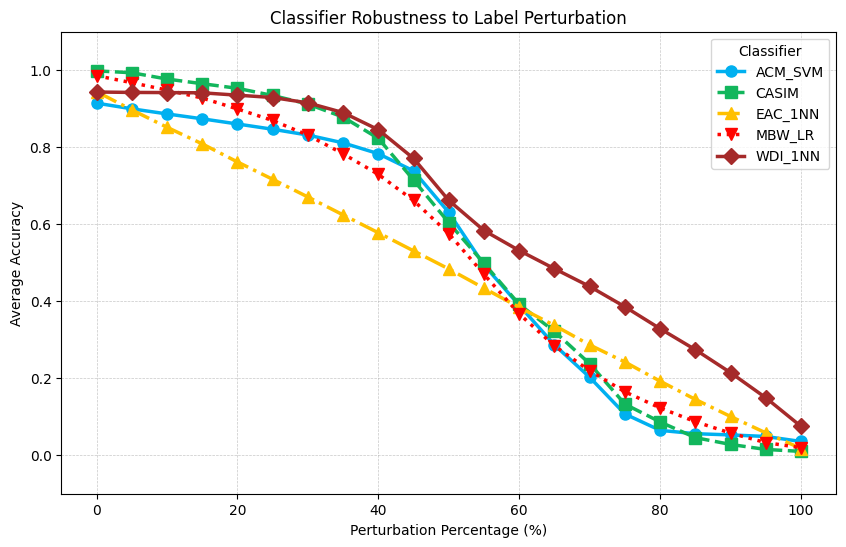

In [10]:
plot_robustness_results(CLASSIFIERS, SAVE_DIR_TEP, save_filename='tep_robustness_plot.svg')

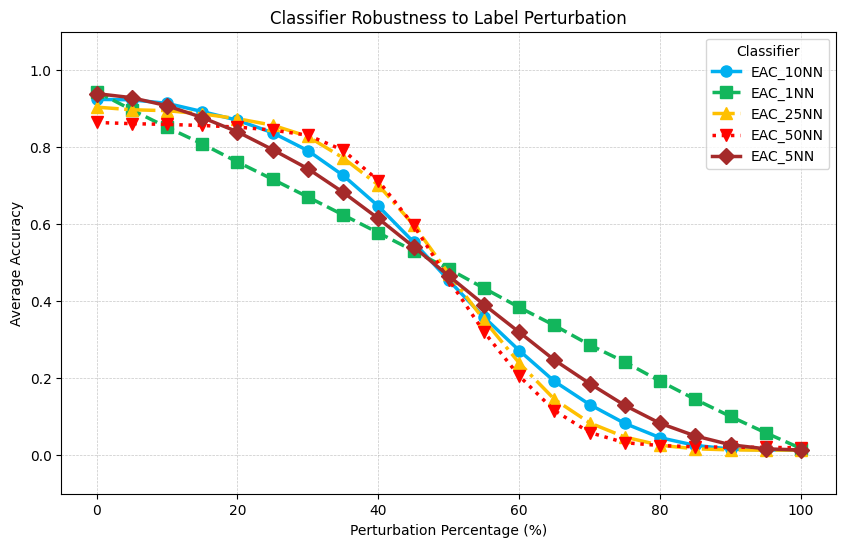

In [11]:
plot_robustness_results(CLASSIFIERS_EAC_KNN, SAVE_DIR_TEP, save_filename='tep_robustness_plot_eac_knn.svg')

### Fluidized Catalytic Cracking (FCC)

In [12]:
X, y = load_dataset_from_folder("data/fcc", MAX_DATA_LENGTH)

Loading dataset: 100%|██████████| 1600/1600 [00:02<00:00, 666.94file/s]

Data shape: (1600, 57, 60)
Labels shape: (1600,)


In [ ]:
perturber = CAELabelPerturber(random_state=RANDOM_SEED, epochs=NUM_EPOCHS)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS,
    perturber=perturber,
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
_ = robustness_tester.test_all_classifiers(X, y, perturbation_steps=PERTURBATION_STEPS, results_folder=SAVE_DIR_FCC)


Testing robustness of all classifiers...
Processing Fold 0...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.8520 - loss: 0.5326 - val_bin_acc: 0.8293 - val_loss: 0.4536
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.8588 - loss: 0.3425 - val_bin_acc: 0.8293 - val_loss: 0.3910
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8594 - loss: 0.3040 - val_bin_acc: 0.8284 - val_loss: 0.3366
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8829 - loss: 0.2480 - val_bin_acc: 0.8403 - val_loss: 0.3194
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9370 - loss: 0.1534 - val_bin_acc: 0.9275 - val_loss: 0.2243
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9731 - loss: 0.0759 - val_bin_acc: 0.9480 - val_loss: 0.1641
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9864 - loss: 0.0401 - val_bin_acc: 0.9590 - val_loss: 0.1423
Epoch 8/50
36/36 ━━━━━━━

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.52it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 6995.50it/s]


Processing Fold 1...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - bin_acc: 0.8513 - loss: 0.5387 - val_bin_acc: 0.8320 - val_loss: 0.4433
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8595 - loss: 0.3413 - val_bin_acc: 0.8320 - val_loss: 0.3858
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8595 - loss: 0.3028 - val_bin_acc: 0.8316 - val_loss: 0.3475
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8859 - loss: 0.2370 - val_bin_acc: 0.8461 - val_loss: 0.3093
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9498 - loss: 0.1249 - val_bin_acc: 0.9324 - val_loss: 0.2199
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9785 - loss: 0.0604 - val_bin_acc: 0.9535 - val_loss: 0.1944
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9871 - loss: 0.0374 - val_bin_acc: 0.9623 - val_loss: 0.1840
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.01it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10499.51it/s]


Processing Fold 2...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - bin_acc: 0.8509 - loss: 0.5337 - val_bin_acc: 0.8284 - val_loss: 0.4487
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8585 - loss: 0.3395 - val_bin_acc: 0.8284 - val_loss: 0.3925
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8613 - loss: 0.3030 - val_bin_acc: 0.8361 - val_loss: 0.3447
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8991 - loss: 0.2223 - val_bin_acc: 0.8619 - val_loss: 0.3217
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9588 - loss: 0.1084 - val_bin_acc: 0.9243 - val_loss: 0.2397
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9801 - loss: 0.0572 - val_bin_acc: 0.9414 - val_loss: 0.2070
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9883 - loss: 0.0343 - val_bin_acc: 0.9512 - val_loss: 0.1861
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.34it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21031.61it/s]


Processing Fold 3...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - bin_acc: 0.8516 - loss: 0.5299 - val_bin_acc: 0.8302 - val_loss: 0.4420
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.8592 - loss: 0.3405 - val_bin_acc: 0.8302 - val_loss: 0.3890
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8604 - loss: 0.2977 - val_bin_acc: 0.8385 - val_loss: 0.3502
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9058 - loss: 0.2098 - val_bin_acc: 0.8937 - val_loss: 0.3147
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9639 - loss: 0.0994 - val_bin_acc: 0.9441 - val_loss: 0.2573
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9841 - loss: 0.0485 - val_bin_acc: 0.9567 - val_loss: 0.2026
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9902 - loss: 0.0293 - val_bin_acc: 0.9628 - val_loss: 0.1972
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:12<00:00, 17.77it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 4...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - bin_acc: 0.8509 - loss: 0.5315 - val_bin_acc: 0.8300 - val_loss: 0.4569
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8587 - loss: 0.3448 - val_bin_acc: 0.8299 - val_loss: 0.3878
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8598 - loss: 0.3057 - val_bin_acc: 0.8272 - val_loss: 0.3409
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.8893 - loss: 0.2347 - val_bin_acc: 0.8441 - val_loss: 0.3234
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9516 - loss: 0.1225 - val_bin_acc: 0.9295 - val_loss: 0.1888
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9825 - loss: 0.0523 - val_bin_acc: 0.9570 - val_loss: 0.1469
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9902 - loss: 0.0299 - val_bin_acc: 0.9648 - val_loss: 0.1267
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.42it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21011.54it/s]


Processing Fold 5...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - bin_acc: 0.8487 - loss: 0.5291 - val_bin_acc: 0.8289 - val_loss: 0.4394
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - bin_acc: 0.8591 - loss: 0.3381 - val_bin_acc: 0.8289 - val_loss: 0.3924
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8601 - loss: 0.2923 - val_bin_acc: 0.8203 - val_loss: 0.3584
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8979 - loss: 0.2173 - val_bin_acc: 0.8889 - val_loss: 0.2612
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9590 - loss: 0.1096 - val_bin_acc: 0.9254 - val_loss: 0.2135
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9814 - loss: 0.0541 - val_bin_acc: 0.9465 - val_loss: 0.1933
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9888 - loss: 0.0331 - val_bin_acc: 0.9538 - val_loss: 0.1872
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.22it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 6...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - bin_acc: 0.8508 - loss: 0.5291 - val_bin_acc: 0.8279 - val_loss: 0.4447
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8587 - loss: 0.3382 - val_bin_acc: 0.8279 - val_loss: 0.3830
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8634 - loss: 0.2778 - val_bin_acc: 0.8394 - val_loss: 0.3273
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9179 - loss: 0.1781 - val_bin_acc: 0.8921 - val_loss: 0.2891
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9684 - loss: 0.0874 - val_bin_acc: 0.9450 - val_loss: 0.2275
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9850 - loss: 0.0457 - val_bin_acc: 0.9580 - val_loss: 0.1654
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9911 - loss: 0.0272 - val_bin_acc: 0.9627 - val_loss: 0.1403
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.34it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20971.52it/s]


Processing Fold 7...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - bin_acc: 0.8511 - loss: 0.5235 - val_bin_acc: 0.8309 - val_loss: 0.4513
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8597 - loss: 0.3380 - val_bin_acc: 0.8309 - val_loss: 0.3885
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8624 - loss: 0.2972 - val_bin_acc: 0.8336 - val_loss: 0.3322
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8951 - loss: 0.2223 - val_bin_acc: 0.8663 - val_loss: 0.2938
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9571 - loss: 0.1093 - val_bin_acc: 0.9454 - val_loss: 0.1697
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9833 - loss: 0.0491 - val_bin_acc: 0.9648 - val_loss: 0.1247
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9906 - loss: 0.0281 - val_bin_acc: 0.9710 - val_loss: 0.1056
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:12<00:00, 17.58it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10505.77it/s]


Processing Fold 8...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - bin_acc: 0.8525 - loss: 0.5279 - val_bin_acc: 0.8292 - val_loss: 0.4505
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8585 - loss: 0.3415 - val_bin_acc: 0.8292 - val_loss: 0.3906
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8599 - loss: 0.3071 - val_bin_acc: 0.8320 - val_loss: 0.3487
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8888 - loss: 0.2396 - val_bin_acc: 0.8534 - val_loss: 0.3187
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9460 - loss: 0.1332 - val_bin_acc: 0.9210 - val_loss: 0.2435
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9750 - loss: 0.0665 - val_bin_acc: 0.9471 - val_loss: 0.2027
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9886 - loss: 0.0349 - val_bin_acc: 0.9593 - val_loss: 0.1582
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.48it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20981.51it/s]


Processing Fold 9...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - bin_acc: 0.8512 - loss: 0.5199 - val_bin_acc: 0.8322 - val_loss: 0.4389
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8587 - loss: 0.3383 - val_bin_acc: 0.8323 - val_loss: 0.3820
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8615 - loss: 0.2911 - val_bin_acc: 0.8347 - val_loss: 0.3444
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9072 - loss: 0.2037 - val_bin_acc: 0.8818 - val_loss: 0.2996
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9557 - loss: 0.1099 - val_bin_acc: 0.9345 - val_loss: 0.2309
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9783 - loss: 0.0607 - val_bin_acc: 0.9558 - val_loss: 0.1836
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9876 - loss: 0.0365 - val_bin_acc: 0.9599 - val_loss: 0.1628
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.99

Building perturbation map: 100%|██████████| 1280/1280 [01:12<00:00, 17.59it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21026.59it/s]


Processing Fold 10...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - bin_acc: 0.8448 - loss: 0.5888 - val_bin_acc: 0.8310 - val_loss: 0.4509
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8589 - loss: 0.3564 - val_bin_acc: 0.8310 - val_loss: 0.3944
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8593 - loss: 0.3128 - val_bin_acc: 0.8299 - val_loss: 0.3422
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.8761 - loss: 0.2549 - val_bin_acc: 0.8525 - val_loss: 0.3072
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9405 - loss: 0.1410 - val_bin_acc: 0.9289 - val_loss: 0.1721
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9792 - loss: 0.0589 - val_bin_acc: 0.9709 - val_loss: 0.0972
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9894 - loss: 0.0315 - val_bin_acc: 0.9724 - val_loss: 0.0971
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.09it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21011.54it/s]


Processing Fold 11...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - bin_acc: 0.8480 - loss: 0.5828 - val_bin_acc: 0.8309 - val_loss: 0.4593
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8587 - loss: 0.3708 - val_bin_acc: 0.8309 - val_loss: 0.4074
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8588 - loss: 0.3208 - val_bin_acc: 0.8316 - val_loss: 0.3621
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.8772 - loss: 0.2661 - val_bin_acc: 0.8453 - val_loss: 0.3354
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - bin_acc: 0.9272 - loss: 0.1725 - val_bin_acc: 0.8866 - val_loss: 0.2946
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9649 - loss: 0.0936 - val_bin_acc: 0.9459 - val_loss: 0.1893
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9827 - loss: 0.0509 - val_bin_acc: 0.9618 - val_loss: 0.1610
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.10it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20986.51it/s]


Processing Fold 12...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8497 - loss: 0.5456 - val_bin_acc: 0.8291 - val_loss: 0.4698
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8592 - loss: 0.3458 - val_bin_acc: 0.8291 - val_loss: 0.3854
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8635 - loss: 0.2928 - val_bin_acc: 0.8371 - val_loss: 0.3374
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9119 - loss: 0.1957 - val_bin_acc: 0.8833 - val_loss: 0.2660
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9672 - loss: 0.0884 - val_bin_acc: 0.9471 - val_loss: 0.1562
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9852 - loss: 0.0440 - val_bin_acc: 0.9616 - val_loss: 0.1396
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9912 - loss: 0.0271 - val_bin_acc: 0.9652 - val_loss: 0.1338
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.31it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 13...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8494 - loss: 0.5565 - val_bin_acc: 0.8299 - val_loss: 0.4467
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.8589 - loss: 0.3533 - val_bin_acc: 0.8299 - val_loss: 0.4037
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8601 - loss: 0.3154 - val_bin_acc: 0.8285 - val_loss: 0.3615
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8855 - loss: 0.2524 - val_bin_acc: 0.8353 - val_loss: 0.3467
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9358 - loss: 0.1514 - val_bin_acc: 0.8900 - val_loss: 0.3357
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9750 - loss: 0.0711 - val_bin_acc: 0.9426 - val_loss: 0.2450
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9877 - loss: 0.0369 - val_bin_acc: 0.9543 - val_loss: 0.2379
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.24it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10483.26it/s]


Processing Fold 14...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8489 - loss: 0.5278 - val_bin_acc: 0.8284 - val_loss: 0.4373
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8590 - loss: 0.3362 - val_bin_acc: 0.8284 - val_loss: 0.3857
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8624 - loss: 0.2916 - val_bin_acc: 0.8243 - val_loss: 0.3551
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9045 - loss: 0.2099 - val_bin_acc: 0.8860 - val_loss: 0.2742
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9619 - loss: 0.1006 - val_bin_acc: 0.9410 - val_loss: 0.1766
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9815 - loss: 0.0531 - val_bin_acc: 0.9588 - val_loss: 0.1515
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9885 - loss: 0.0343 - val_bin_acc: 0.9656 - val_loss: 0.1380
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.86it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20976.51it/s]


Processing Fold 15...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - bin_acc: 0.8484 - loss: 0.5897 - val_bin_acc: 0.8292 - val_loss: 0.4715
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.8592 - loss: 0.3654 - val_bin_acc: 0.8292 - val_loss: 0.4064
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8594 - loss: 0.3231 - val_bin_acc: 0.8293 - val_loss: 0.3777
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.8703 - loss: 0.2725 - val_bin_acc: 0.8207 - val_loss: 0.3437
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9244 - loss: 0.1725 - val_bin_acc: 0.8996 - val_loss: 0.2555
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9720 - loss: 0.0769 - val_bin_acc: 0.9394 - val_loss: 0.1964
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9862 - loss: 0.0412 - val_bin_acc: 0.9520 - val_loss: 0.2004
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.37it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21036.63it/s]


Processing Fold 16...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - bin_acc: 0.8497 - loss: 0.5351 - val_bin_acc: 0.8318 - val_loss: 0.4529
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - bin_acc: 0.8586 - loss: 0.3408 - val_bin_acc: 0.8318 - val_loss: 0.3849
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.8600 - loss: 0.2984 - val_bin_acc: 0.8426 - val_loss: 0.3338
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9017 - loss: 0.2126 - val_bin_acc: 0.8757 - val_loss: 0.2923
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9572 - loss: 0.1070 - val_bin_acc: 0.9341 - val_loss: 0.1705
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9816 - loss: 0.0523 - val_bin_acc: 0.9573 - val_loss: 0.1253
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9895 - loss: 0.0314 - val_bin_acc: 0.9637 - val_loss: 0.1193
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.26it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 17...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - bin_acc: 0.8495 - loss: 0.5604 - val_bin_acc: 0.8295 - val_loss: 0.4504
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.8588 - loss: 0.3580 - val_bin_acc: 0.8295 - val_loss: 0.4066
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8592 - loss: 0.3228 - val_bin_acc: 0.8301 - val_loss: 0.3739
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8696 - loss: 0.2714 - val_bin_acc: 0.8299 - val_loss: 0.3465
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9249 - loss: 0.1727 - val_bin_acc: 0.9004 - val_loss: 0.2809
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9694 - loss: 0.0853 - val_bin_acc: 0.9398 - val_loss: 0.1768
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9853 - loss: 0.0439 - val_bin_acc: 0.9564 - val_loss: 0.1380
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:16<00:00, 16.69it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 6999.39it/s]


Processing Fold 18...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8495 - loss: 0.5373 - val_bin_acc: 0.8278 - val_loss: 0.4466
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8590 - loss: 0.3423 - val_bin_acc: 0.8278 - val_loss: 0.3911
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8605 - loss: 0.2941 - val_bin_acc: 0.8376 - val_loss: 0.3373
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9063 - loss: 0.2062 - val_bin_acc: 0.8775 - val_loss: 0.3063
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9588 - loss: 0.1052 - val_bin_acc: 0.9353 - val_loss: 0.2257
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9795 - loss: 0.0575 - val_bin_acc: 0.9520 - val_loss: 0.2310
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9887 - loss: 0.0341 - val_bin_acc: 0.9594 - val_loss: 0.2225
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.04it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21041.66it/s]


Processing Fold 19...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - bin_acc: 0.8398 - loss: 0.5600 - val_bin_acc: 0.8307 - val_loss: 0.4471
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - bin_acc: 0.8592 - loss: 0.3535 - val_bin_acc: 0.8307 - val_loss: 0.3992
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8592 - loss: 0.3126 - val_bin_acc: 0.8265 - val_loss: 0.3516
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8888 - loss: 0.2354 - val_bin_acc: 0.8475 - val_loss: 0.3402
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9503 - loss: 0.1236 - val_bin_acc: 0.9277 - val_loss: 0.2435
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9793 - loss: 0.0583 - val_bin_acc: 0.9512 - val_loss: 0.2071
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9892 - loss: 0.0321 - val_bin_acc: 0.9595 - val_loss: 0.1819
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.86it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 20...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - bin_acc: 0.8486 - loss: 0.5286 - val_bin_acc: 0.8300 - val_loss: 0.4371
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8586 - loss: 0.3382 - val_bin_acc: 0.8300 - val_loss: 0.3775
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8617 - loss: 0.2884 - val_bin_acc: 0.8425 - val_loss: 0.3185
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9136 - loss: 0.1933 - val_bin_acc: 0.8839 - val_loss: 0.3202
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9649 - loss: 0.0936 - val_bin_acc: 0.9451 - val_loss: 0.1529
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9857 - loss: 0.0421 - val_bin_acc: 0.9683 - val_loss: 0.1041
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9921 - loss: 0.0245 - val_bin_acc: 0.9675 - val_loss: 0.1021
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:16<00:00, 16.82it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20793.29it/s]


Processing Fold 21...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - bin_acc: 0.8477 - loss: 0.5486 - val_bin_acc: 0.8278 - val_loss: 0.4413
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bin_acc: 0.8595 - loss: 0.3466 - val_bin_acc: 0.8278 - val_loss: 0.3937
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8604 - loss: 0.3033 - val_bin_acc: 0.8234 - val_loss: 0.3495
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8933 - loss: 0.2275 - val_bin_acc: 0.8665 - val_loss: 0.2912
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9575 - loss: 0.1106 - val_bin_acc: 0.9466 - val_loss: 0.1620
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9808 - loss: 0.0550 - val_bin_acc: 0.9620 - val_loss: 0.1339
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9883 - loss: 0.0350 - val_bin_acc: 0.9670 - val_loss: 0.1302
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:11<00:00, 17.80it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20941.60it/s]


Processing Fold 22...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - bin_acc: 0.8490 - loss: 0.5396 - val_bin_acc: 0.8287 - val_loss: 0.4462
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8591 - loss: 0.3406 - val_bin_acc: 0.8287 - val_loss: 0.3886
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8632 - loss: 0.2890 - val_bin_acc: 0.8337 - val_loss: 0.3441
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9198 - loss: 0.1801 - val_bin_acc: 0.8786 - val_loss: 0.3248
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9698 - loss: 0.0801 - val_bin_acc: 0.9386 - val_loss: 0.1865
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9869 - loss: 0.0391 - val_bin_acc: 0.9498 - val_loss: 0.1773
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9923 - loss: 0.0235 - val_bin_acc: 0.9577 - val_loss: 0.1611
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.09it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 23...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.8468 - loss: 0.5870 - val_bin_acc: 0.8304 - val_loss: 0.4560
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - bin_acc: 0.8581 - loss: 0.3683 - val_bin_acc: 0.8304 - val_loss: 0.4023
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.8582 - loss: 0.3239 - val_bin_acc: 0.8300 - val_loss: 0.3782
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8677 - loss: 0.2804 - val_bin_acc: 0.8335 - val_loss: 0.3375
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9233 - loss: 0.1754 - val_bin_acc: 0.8849 - val_loss: 0.2914
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9689 - loss: 0.0854 - val_bin_acc: 0.9410 - val_loss: 0.1779
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9846 - loss: 0.0450 - val_bin_acc: 0.9525 - val_loss: 0.1818
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.15it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20832.64it/s]


Processing Fold 24...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8521 - loss: 0.5379 - val_bin_acc: 0.8329 - val_loss: 0.4434
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.8594 - loss: 0.3398 - val_bin_acc: 0.8329 - val_loss: 0.3848
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8597 - loss: 0.2932 - val_bin_acc: 0.8326 - val_loss: 0.3271
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9004 - loss: 0.2080 - val_bin_acc: 0.8754 - val_loss: 0.2989
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9617 - loss: 0.1010 - val_bin_acc: 0.9460 - val_loss: 0.1837
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9833 - loss: 0.0488 - val_bin_acc: 0.9549 - val_loss: 0.1398
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9901 - loss: 0.0296 - val_bin_acc: 0.9558 - val_loss: 0.1391
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.90it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 25...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - bin_acc: 0.8497 - loss: 0.5266 - val_bin_acc: 0.8285 - val_loss: 0.4413
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8584 - loss: 0.3375 - val_bin_acc: 0.8285 - val_loss: 0.3869
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8626 - loss: 0.2906 - val_bin_acc: 0.8221 - val_loss: 0.3452
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9037 - loss: 0.2099 - val_bin_acc: 0.8720 - val_loss: 0.2941
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9630 - loss: 0.0986 - val_bin_acc: 0.9427 - val_loss: 0.1789
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9837 - loss: 0.0489 - val_bin_acc: 0.9487 - val_loss: 0.1553
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9900 - loss: 0.0308 - val_bin_acc: 0.9584 - val_loss: 0.1326
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.00it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 9205.73it/s]


Processing Fold 26...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - bin_acc: 0.8505 - loss: 0.5783 - val_bin_acc: 0.8301 - val_loss: 0.4519
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8588 - loss: 0.3630 - val_bin_acc: 0.8301 - val_loss: 0.3996
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8588 - loss: 0.3164 - val_bin_acc: 0.8287 - val_loss: 0.3634
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8761 - loss: 0.2640 - val_bin_acc: 0.8376 - val_loss: 0.3451
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9237 - loss: 0.1768 - val_bin_acc: 0.8902 - val_loss: 0.2985
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.9625 - loss: 0.0977 - val_bin_acc: 0.9278 - val_loss: 0.2158
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9807 - loss: 0.0552 - val_bin_acc: 0.9555 - val_loss: 0.1627
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.02it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 27...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - bin_acc: 0.8471 - loss: 0.5844 - val_bin_acc: 0.8310 - val_loss: 0.4513
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8593 - loss: 0.3553 - val_bin_acc: 0.8310 - val_loss: 0.3971
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8594 - loss: 0.3107 - val_bin_acc: 0.8317 - val_loss: 0.3513
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8879 - loss: 0.2395 - val_bin_acc: 0.8514 - val_loss: 0.3327
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9536 - loss: 0.1195 - val_bin_acc: 0.9223 - val_loss: 0.2180
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9827 - loss: 0.0526 - val_bin_acc: 0.9521 - val_loss: 0.1655
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9911 - loss: 0.0276 - val_bin_acc: 0.9629 - val_loss: 0.1378
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.30it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 28...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - bin_acc: 0.8402 - loss: 0.5648 - val_bin_acc: 0.8297 - val_loss: 0.4476
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8592 - loss: 0.3562 - val_bin_acc: 0.8297 - val_loss: 0.3976
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8601 - loss: 0.3109 - val_bin_acc: 0.8302 - val_loss: 0.3480
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8840 - loss: 0.2520 - val_bin_acc: 0.8447 - val_loss: 0.3328
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9371 - loss: 0.1501 - val_bin_acc: 0.9172 - val_loss: 0.2628
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9718 - loss: 0.0761 - val_bin_acc: 0.9455 - val_loss: 0.1975
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9849 - loss: 0.0442 - val_bin_acc: 0.9591 - val_loss: 0.1692
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.37it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21006.53it/s]


Processing Fold 29...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - bin_acc: 0.8544 - loss: 0.5165 - val_bin_acc: 0.8307 - val_loss: 0.4278
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.8589 - loss: 0.3338 - val_bin_acc: 0.8307 - val_loss: 0.3811
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8615 - loss: 0.2869 - val_bin_acc: 0.8269 - val_loss: 0.3517
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9113 - loss: 0.1894 - val_bin_acc: 0.9084 - val_loss: 0.2478
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9689 - loss: 0.0840 - val_bin_acc: 0.9536 - val_loss: 0.1316
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9862 - loss: 0.0410 - val_bin_acc: 0.9658 - val_loss: 0.1111
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9917 - loss: 0.0249 - val_bin_acc: 0.9689 - val_loss: 0.1083
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.16it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20681.00it/s]


Processing Fold 30...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - bin_acc: 0.8517 - loss: 0.5320 - val_bin_acc: 0.8289 - val_loss: 0.4616
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8590 - loss: 0.3452 - val_bin_acc: 0.8289 - val_loss: 0.3979
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8598 - loss: 0.3063 - val_bin_acc: 0.8312 - val_loss: 0.3514
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8895 - loss: 0.2372 - val_bin_acc: 0.8345 - val_loss: 0.3565
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9474 - loss: 0.1333 - val_bin_acc: 0.8947 - val_loss: 0.3401
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9762 - loss: 0.0683 - val_bin_acc: 0.9392 - val_loss: 0.2281
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9871 - loss: 0.0385 - val_bin_acc: 0.9542 - val_loss: 0.1673
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.04it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 31...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - bin_acc: 0.8508 - loss: 0.5374 - val_bin_acc: 0.8306 - val_loss: 0.4443
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.8600 - loss: 0.3472 - val_bin_acc: 0.8306 - val_loss: 0.4011
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8598 - loss: 0.3104 - val_bin_acc: 0.8309 - val_loss: 0.3610
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8796 - loss: 0.2472 - val_bin_acc: 0.8306 - val_loss: 0.3310
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9406 - loss: 0.1401 - val_bin_acc: 0.9213 - val_loss: 0.2159
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - bin_acc: 0.9784 - loss: 0.0612 - val_bin_acc: 0.9564 - val_loss: 0.1406
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - bin_acc: 0.9880 - loss: 0.0355 - val_bin_acc: 0.9612 - val_loss: 0.1435
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:12<00:00, 17.61it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20966.53it/s]


Processing Fold 32...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - bin_acc: 0.8505 - loss: 0.5296 - val_bin_acc: 0.8297 - val_loss: 0.4516
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8586 - loss: 0.3430 - val_bin_acc: 0.8297 - val_loss: 0.3946
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8587 - loss: 0.2978 - val_bin_acc: 0.8224 - val_loss: 0.3475
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8997 - loss: 0.2110 - val_bin_acc: 0.8765 - val_loss: 0.2956
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9619 - loss: 0.0971 - val_bin_acc: 0.9348 - val_loss: 0.2090
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9832 - loss: 0.0479 - val_bin_acc: 0.9501 - val_loss: 0.1982
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9907 - loss: 0.0287 - val_bin_acc: 0.9560 - val_loss: 0.1998
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.02it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20966.53it/s]


Processing Fold 33...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - bin_acc: 0.8477 - loss: 0.5899 - val_bin_acc: 0.8284 - val_loss: 0.4580
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8592 - loss: 0.3608 - val_bin_acc: 0.8284 - val_loss: 0.4001
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8595 - loss: 0.3198 - val_bin_acc: 0.8272 - val_loss: 0.3702
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8803 - loss: 0.2542 - val_bin_acc: 0.8295 - val_loss: 0.3488
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9416 - loss: 0.1423 - val_bin_acc: 0.9222 - val_loss: 0.2346
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9766 - loss: 0.0647 - val_bin_acc: 0.9535 - val_loss: 0.1554
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9877 - loss: 0.0360 - val_bin_acc: 0.9692 - val_loss: 0.1240
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:16<00:00, 16.77it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 34...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - bin_acc: 0.8237 - loss: 0.5375 - val_bin_acc: 0.8316 - val_loss: 0.4282
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8580 - loss: 0.3412 - val_bin_acc: 0.8316 - val_loss: 0.3787
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8615 - loss: 0.2965 - val_bin_acc: 0.8325 - val_loss: 0.3329
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.8955 - loss: 0.2247 - val_bin_acc: 0.8537 - val_loss: 0.3012
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9588 - loss: 0.1090 - val_bin_acc: 0.9379 - val_loss: 0.1769
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9834 - loss: 0.0492 - val_bin_acc: 0.9547 - val_loss: 0.1504
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9908 - loss: 0.0286 - val_bin_acc: 0.9663 - val_loss: 0.1294
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.25it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10500.76it/s]


Processing Fold 35...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - bin_acc: 0.8392 - loss: 0.5351 - val_bin_acc: 0.8296 - val_loss: 0.4253
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.8586 - loss: 0.3342 - val_bin_acc: 0.8297 - val_loss: 0.3732
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8641 - loss: 0.2791 - val_bin_acc: 0.8285 - val_loss: 0.3370
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9211 - loss: 0.1792 - val_bin_acc: 0.8945 - val_loss: 0.2940
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9666 - loss: 0.0885 - val_bin_acc: 0.9427 - val_loss: 0.2030
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9847 - loss: 0.0452 - val_bin_acc: 0.9541 - val_loss: 0.1656
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9905 - loss: 0.0292 - val_bin_acc: 0.9604 - val_loss: 0.1332
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.29it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 18913.55it/s]


Processing Fold 36...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8460 - loss: 0.5341 - val_bin_acc: 0.8310 - val_loss: 0.4372
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8584 - loss: 0.3399 - val_bin_acc: 0.8310 - val_loss: 0.3771
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8598 - loss: 0.2914 - val_bin_acc: 0.8365 - val_loss: 0.3306
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8982 - loss: 0.2164 - val_bin_acc: 0.8534 - val_loss: 0.3288
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9495 - loss: 0.1242 - val_bin_acc: 0.9296 - val_loss: 0.1939
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9781 - loss: 0.0625 - val_bin_acc: 0.9574 - val_loss: 0.1401
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9875 - loss: 0.0371 - val_bin_acc: 0.9647 - val_loss: 0.1349
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.10it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 10494.51it/s]


Processing Fold 37...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - bin_acc: 0.8517 - loss: 0.5463 - val_bin_acc: 0.8294 - val_loss: 0.4643
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8597 - loss: 0.3505 - val_bin_acc: 0.8294 - val_loss: 0.3946
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8603 - loss: 0.3037 - val_bin_acc: 0.8346 - val_loss: 0.3418
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9006 - loss: 0.2172 - val_bin_acc: 0.8897 - val_loss: 0.3105
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9615 - loss: 0.1003 - val_bin_acc: 0.9459 - val_loss: 0.2061
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9838 - loss: 0.0479 - val_bin_acc: 0.9643 - val_loss: 0.1400
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9903 - loss: 0.0290 - val_bin_acc: 0.9684 - val_loss: 0.1277
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:16<00:00, 16.66it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21016.56it/s]


Processing Fold 38...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8481 - loss: 0.5809 - val_bin_acc: 0.8301 - val_loss: 0.4559
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8590 - loss: 0.3620 - val_bin_acc: 0.8301 - val_loss: 0.4005
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8591 - loss: 0.3232 - val_bin_acc: 0.8302 - val_loss: 0.3708
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8719 - loss: 0.2706 - val_bin_acc: 0.8417 - val_loss: 0.3425
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9321 - loss: 0.1648 - val_bin_acc: 0.9099 - val_loss: 0.2615
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9679 - loss: 0.0855 - val_bin_acc: 0.9419 - val_loss: 0.2096
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9831 - loss: 0.0492 - val_bin_acc: 0.9549 - val_loss: 0.1968
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.92it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21011.54it/s]


Processing Fold 39...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - bin_acc: 0.8510 - loss: 0.5270 - val_bin_acc: 0.8291 - val_loss: 0.4389
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8591 - loss: 0.3373 - val_bin_acc: 0.8290 - val_loss: 0.3907
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8637 - loss: 0.2911 - val_bin_acc: 0.8200 - val_loss: 0.3686
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8964 - loss: 0.2181 - val_bin_acc: 0.8474 - val_loss: 0.3473
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9544 - loss: 0.1164 - val_bin_acc: 0.9094 - val_loss: 0.2522
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9804 - loss: 0.0561 - val_bin_acc: 0.9440 - val_loss: 0.1745
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9884 - loss: 0.0342 - val_bin_acc: 0.9538 - val_loss: 0.1647
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.03it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 40...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8494 - loss: 0.5841 - val_bin_acc: 0.8291 - val_loss: 0.4553
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8593 - loss: 0.3601 - val_bin_acc: 0.8291 - val_loss: 0.3966
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8590 - loss: 0.3138 - val_bin_acc: 0.8288 - val_loss: 0.3626
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8794 - loss: 0.2549 - val_bin_acc: 0.8246 - val_loss: 0.3470
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9313 - loss: 0.1603 - val_bin_acc: 0.8892 - val_loss: 0.3346
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9703 - loss: 0.0808 - val_bin_acc: 0.9366 - val_loss: 0.2439
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9855 - loss: 0.0419 - val_bin_acc: 0.9514 - val_loss: 0.2209
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.85it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 14009.92it/s]


Processing Fold 41...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - bin_acc: 0.8501 - loss: 0.5541 - val_bin_acc: 0.8311 - val_loss: 0.4439
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.8592 - loss: 0.3586 - val_bin_acc: 0.8311 - val_loss: 0.3992
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8593 - loss: 0.3132 - val_bin_acc: 0.8292 - val_loss: 0.3431
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8890 - loss: 0.2314 - val_bin_acc: 0.8562 - val_loss: 0.3196
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9558 - loss: 0.1150 - val_bin_acc: 0.9303 - val_loss: 0.2028
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9812 - loss: 0.0542 - val_bin_acc: 0.9558 - val_loss: 0.1509
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9902 - loss: 0.0308 - val_bin_acc: 0.9706 - val_loss: 0.1173
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.89it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20966.53it/s]


Processing Fold 42...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8493 - loss: 0.5303 - val_bin_acc: 0.8303 - val_loss: 0.4378
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8589 - loss: 0.3374 - val_bin_acc: 0.8303 - val_loss: 0.3803
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8616 - loss: 0.2882 - val_bin_acc: 0.8427 - val_loss: 0.3191
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9155 - loss: 0.1826 - val_bin_acc: 0.9188 - val_loss: 0.2122
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.9709 - loss: 0.0789 - val_bin_acc: 0.9522 - val_loss: 0.1474
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9846 - loss: 0.0441 - val_bin_acc: 0.9575 - val_loss: 0.1474
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9905 - loss: 0.0279 - val_bin_acc: 0.9592 - val_loss: 0.1610
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.04it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


Processing Fold 43...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - bin_acc: 0.8514 - loss: 0.5399 - val_bin_acc: 0.8291 - val_loss: 0.4481
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bin_acc: 0.8585 - loss: 0.3499 - val_bin_acc: 0.8291 - val_loss: 0.4033
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8589 - loss: 0.3097 - val_bin_acc: 0.8286 - val_loss: 0.3566
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8959 - loss: 0.2228 - val_bin_acc: 0.8429 - val_loss: 0.3263
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9557 - loss: 0.1149 - val_bin_acc: 0.9423 - val_loss: 0.1704
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9825 - loss: 0.0521 - val_bin_acc: 0.9687 - val_loss: 0.1100
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9901 - loss: 0.0306 - val_bin_acc: 0.9689 - val_loss: 0.1181
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.87it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 44...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - bin_acc: 0.8480 - loss: 0.5372 - val_bin_acc: 0.8309 - val_loss: 0.4416
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8587 - loss: 0.3427 - val_bin_acc: 0.8309 - val_loss: 0.3902
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8605 - loss: 0.3039 - val_bin_acc: 0.8372 - val_loss: 0.3296
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9063 - loss: 0.2026 - val_bin_acc: 0.8858 - val_loss: 0.2839
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9637 - loss: 0.0959 - val_bin_acc: 0.9393 - val_loss: 0.1683
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9829 - loss: 0.0492 - val_bin_acc: 0.9555 - val_loss: 0.1416
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9896 - loss: 0.0301 - val_bin_acc: 0.9583 - val_loss: 0.1278
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:13<00:00, 17.45it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 13974.36it/s]


Processing Fold 45...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - bin_acc: 0.8445 - loss: 0.5358 - val_bin_acc: 0.8318 - val_loss: 0.4405
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - bin_acc: 0.8585 - loss: 0.3398 - val_bin_acc: 0.8318 - val_loss: 0.3792
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8604 - loss: 0.2917 - val_bin_acc: 0.8327 - val_loss: 0.3376
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9013 - loss: 0.2088 - val_bin_acc: 0.8752 - val_loss: 0.3395
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9584 - loss: 0.1080 - val_bin_acc: 0.9241 - val_loss: 0.2675
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9800 - loss: 0.0581 - val_bin_acc: 0.9501 - val_loss: 0.2082
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9879 - loss: 0.0356 - val_bin_acc: 0.9598 - val_loss: 0.1914
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.85it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20986.51it/s]


Processing Fold 46...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - bin_acc: 0.8461 - loss: 0.5820 - val_bin_acc: 0.8305 - val_loss: 0.4614
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8590 - loss: 0.3442 - val_bin_acc: 0.8305 - val_loss: 0.3821
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8664 - loss: 0.2884 - val_bin_acc: 0.8372 - val_loss: 0.3393
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9121 - loss: 0.1937 - val_bin_acc: 0.8677 - val_loss: 0.3125
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9633 - loss: 0.0957 - val_bin_acc: 0.9399 - val_loss: 0.1892
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9842 - loss: 0.0470 - val_bin_acc: 0.9544 - val_loss: 0.1818
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9904 - loss: 0.0298 - val_bin_acc: 0.9655 - val_loss: 0.1606
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.91it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21046.69it/s]


Processing Fold 47...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - bin_acc: 0.8370 - loss: 0.5384 - val_bin_acc: 0.8266 - val_loss: 0.4356
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8591 - loss: 0.3355 - val_bin_acc: 0.8266 - val_loss: 0.3796
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8607 - loss: 0.2888 - val_bin_acc: 0.8313 - val_loss: 0.3415
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9104 - loss: 0.1951 - val_bin_acc: 0.8841 - val_loss: 0.2490
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9713 - loss: 0.0772 - val_bin_acc: 0.9491 - val_loss: 0.1539
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9872 - loss: 0.0388 - val_bin_acc: 0.9645 - val_loss: 0.1238
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9916 - loss: 0.0256 - val_bin_acc: 0.9696 - val_loss: 0.1134
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.97it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 48...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - bin_acc: 0.8492 - loss: 0.5366 - val_bin_acc: 0.8278 - val_loss: 0.4559
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8588 - loss: 0.3439 - val_bin_acc: 0.8278 - val_loss: 0.3886
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8594 - loss: 0.3015 - val_bin_acc: 0.8198 - val_loss: 0.3477
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8915 - loss: 0.2309 - val_bin_acc: 0.8477 - val_loss: 0.3217
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9537 - loss: 0.1142 - val_bin_acc: 0.9304 - val_loss: 0.2484
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9813 - loss: 0.0528 - val_bin_acc: 0.9528 - val_loss: 0.2000
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9896 - loss: 0.0314 - val_bin_acc: 0.9624 - val_loss: 0.1716
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.02it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21056.75it/s]


Processing Fold 49...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - bin_acc: 0.8524 - loss: 0.5288 - val_bin_acc: 0.8325 - val_loss: 0.4405
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8593 - loss: 0.3386 - val_bin_acc: 0.8325 - val_loss: 0.3840
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8601 - loss: 0.3014 - val_bin_acc: 0.8404 - val_loss: 0.3321
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8936 - loss: 0.2256 - val_bin_acc: 0.8628 - val_loss: 0.3117
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9529 - loss: 0.1147 - val_bin_acc: 0.9305 - val_loss: 0.2385
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9805 - loss: 0.0549 - val_bin_acc: 0.9496 - val_loss: 0.1735
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9893 - loss: 0.0319 - val_bin_acc: 0.9517 - val_loss: 0.2020
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:16<00:00, 16.66it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20996.52it/s]


Processing Fold 50...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - bin_acc: 0.8498 - loss: 0.5284 - val_bin_acc: 0.8286 - val_loss: 0.4373
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8587 - loss: 0.3374 - val_bin_acc: 0.8286 - val_loss: 0.3859
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8613 - loss: 0.2902 - val_bin_acc: 0.8353 - val_loss: 0.3254
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9110 - loss: 0.1963 - val_bin_acc: 0.8834 - val_loss: 0.3192
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9623 - loss: 0.0991 - val_bin_acc: 0.9448 - val_loss: 0.2231
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9838 - loss: 0.0483 - val_bin_acc: 0.9573 - val_loss: 0.2109
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9903 - loss: 0.0300 - val_bin_acc: 0.9627 - val_loss: 0.1943
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:16<00:00, 16.78it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21016.56it/s]


Processing Fold 51...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8486 - loss: 0.5752 - val_bin_acc: 0.8304 - val_loss: 0.4509
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.8590 - loss: 0.3595 - val_bin_acc: 0.8304 - val_loss: 0.4011
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8591 - loss: 0.3120 - val_bin_acc: 0.8316 - val_loss: 0.3578
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8833 - loss: 0.2469 - val_bin_acc: 0.8441 - val_loss: 0.3196
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9447 - loss: 0.1327 - val_bin_acc: 0.9354 - val_loss: 0.2211
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9757 - loss: 0.0668 - val_bin_acc: 0.9544 - val_loss: 0.1837
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9868 - loss: 0.0385 - val_bin_acc: 0.9660 - val_loss: 0.1503
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.97it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21031.61it/s]


Processing Fold 52...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - bin_acc: 0.8459 - loss: 0.5967 - val_bin_acc: 0.8304 - val_loss: 0.4522
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8592 - loss: 0.3507 - val_bin_acc: 0.8301 - val_loss: 0.3861
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8651 - loss: 0.2888 - val_bin_acc: 0.8378 - val_loss: 0.3362
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9227 - loss: 0.1751 - val_bin_acc: 0.9022 - val_loss: 0.2617
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9724 - loss: 0.0746 - val_bin_acc: 0.9514 - val_loss: 0.1639
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9872 - loss: 0.0375 - val_bin_acc: 0.9641 - val_loss: 0.1297
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9920 - loss: 0.0239 - val_bin_acc: 0.9702 - val_loss: 0.1128
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.25it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 53...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - bin_acc: 0.8500 - loss: 0.5339 - val_bin_acc: 0.8319 - val_loss: 0.4567
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8589 - loss: 0.3413 - val_bin_acc: 0.8319 - val_loss: 0.3842
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8620 - loss: 0.2993 - val_bin_acc: 0.8369 - val_loss: 0.3393
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9015 - loss: 0.2169 - val_bin_acc: 0.8694 - val_loss: 0.3012
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9601 - loss: 0.1056 - val_bin_acc: 0.9453 - val_loss: 0.1637
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9862 - loss: 0.0427 - val_bin_acc: 0.9617 - val_loss: 0.1352
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9919 - loss: 0.0253 - val_bin_acc: 0.9657 - val_loss: 0.1304
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.89it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20956.55it/s]


Processing Fold 54...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - bin_acc: 0.8490 - loss: 0.5276 - val_bin_acc: 0.8285 - val_loss: 0.4410
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8589 - loss: 0.3391 - val_bin_acc: 0.8285 - val_loss: 0.3876
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8611 - loss: 0.2876 - val_bin_acc: 0.8348 - val_loss: 0.3407
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9088 - loss: 0.1970 - val_bin_acc: 0.8999 - val_loss: 0.2981
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9646 - loss: 0.0930 - val_bin_acc: 0.9248 - val_loss: 0.2083
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9819 - loss: 0.0499 - val_bin_acc: 0.9474 - val_loss: 0.1827
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9883 - loss: 0.0331 - val_bin_acc: 0.9556 - val_loss: 0.1459
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 16.93it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21021.57it/s]


Processing Fold 55...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - bin_acc: 0.8467 - loss: 0.5772 - val_bin_acc: 0.8309 - val_loss: 0.4494
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8585 - loss: 0.3609 - val_bin_acc: 0.8309 - val_loss: 0.4066
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8595 - loss: 0.3215 - val_bin_acc: 0.8297 - val_loss: 0.3675
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8813 - loss: 0.2565 - val_bin_acc: 0.8495 - val_loss: 0.3725
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9378 - loss: 0.1511 - val_bin_acc: 0.8910 - val_loss: 0.3340
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9752 - loss: 0.0722 - val_bin_acc: 0.9354 - val_loss: 0.2739
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9873 - loss: 0.0386 - val_bin_acc: 0.9483 - val_loss: 0.2374
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.16it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21001.52it/s]


Processing Fold 56...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - bin_acc: 0.8491 - loss: 0.5804 - val_bin_acc: 0.8298 - val_loss: 0.4523
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.8589 - loss: 0.3543 - val_bin_acc: 0.8298 - val_loss: 0.3952
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8593 - loss: 0.3029 - val_bin_acc: 0.8261 - val_loss: 0.3580
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.8967 - loss: 0.2156 - val_bin_acc: 0.8484 - val_loss: 0.3346
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9564 - loss: 0.1104 - val_bin_acc: 0.9162 - val_loss: 0.2488
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9791 - loss: 0.0594 - val_bin_acc: 0.9378 - val_loss: 0.2074
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9881 - loss: 0.0355 - val_bin_acc: 0.9454 - val_loss: 0.2116
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.26it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 57...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - bin_acc: 0.8512 - loss: 0.5312 - val_bin_acc: 0.8299 - val_loss: 0.4386
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8591 - loss: 0.3385 - val_bin_acc: 0.8299 - val_loss: 0.3883
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8621 - loss: 0.2952 - val_bin_acc: 0.8319 - val_loss: 0.3396
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8976 - loss: 0.2260 - val_bin_acc: 0.8616 - val_loss: 0.3220
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9504 - loss: 0.1244 - val_bin_acc: 0.9253 - val_loss: 0.2197
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9763 - loss: 0.0654 - val_bin_acc: 0.9494 - val_loss: 0.1931
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9869 - loss: 0.0386 - val_bin_acc: 0.9575 - val_loss: 0.1783
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:16<00:00, 16.79it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<?, ?it/s]


Processing Fold 58...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - bin_acc: 0.8501 - loss: 0.5333 - val_bin_acc: 0.8294 - val_loss: 0.4428
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8592 - loss: 0.3397 - val_bin_acc: 0.8294 - val_loss: 0.3910
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8630 - loss: 0.2972 - val_bin_acc: 0.8387 - val_loss: 0.3356
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8989 - loss: 0.2225 - val_bin_acc: 0.8666 - val_loss: 0.3182
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9562 - loss: 0.1132 - val_bin_acc: 0.9306 - val_loss: 0.2175
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9829 - loss: 0.0520 - val_bin_acc: 0.9596 - val_loss: 0.1431
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9902 - loss: 0.0297 - val_bin_acc: 0.9623 - val_loss: 0.1505
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.10it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 16906.02it/s]


Processing Fold 59...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - bin_acc: 0.8510 - loss: 0.5278 - val_bin_acc: 0.8298 - val_loss: 0.4439
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8589 - loss: 0.3441 - val_bin_acc: 0.8298 - val_loss: 0.3922
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8587 - loss: 0.3059 - val_bin_acc: 0.8251 - val_loss: 0.3470
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.8855 - loss: 0.2325 - val_bin_acc: 0.8417 - val_loss: 0.3465
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9509 - loss: 0.1196 - val_bin_acc: 0.9275 - val_loss: 0.2692
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9802 - loss: 0.0562 - val_bin_acc: 0.9490 - val_loss: 0.2205
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9892 - loss: 0.0320 - val_bin_acc: 0.9572 - val_loss: 0.1962
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:15<00:00, 17.06it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 21036.63it/s]


Processing Fold 60...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - bin_acc: 0.8478 - loss: 0.5977 - val_bin_acc: 0.8276 - val_loss: 0.4831
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.8586 - loss: 0.3710 - val_bin_acc: 0.8276 - val_loss: 0.4071
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8585 - loss: 0.3211 - val_bin_acc: 0.8275 - val_loss: 0.3807
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.8729 - loss: 0.2670 - val_bin_acc: 0.8222 - val_loss: 0.3730
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9286 - loss: 0.1699 - val_bin_acc: 0.9012 - val_loss: 0.2680
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.9672 - loss: 0.0873 - val_bin_acc: 0.9271 - val_loss: 0.2728
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - bin_acc: 0.9825 - loss: 0.0500 - val_bin_acc: 0.9483 - val_loss: 0.2653
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9

Building perturbation map: 100%|██████████| 1280/1280 [01:14<00:00, 17.09it/s]


Built perturbation map.


Perturbation steps: 100%|██████████| 21/21 [00:00<00:00, 20739.44it/s]


Processing Fold 61...
Training autoencoder for 50 epochs...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - bin_acc: 0.8507 - loss: 0.5292 - val_bin_acc: 0.8309 - val_loss: 0.4365
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - bin_acc: 0.8589 - loss: 0.3384 - val_bin_acc: 0.8309 - val_loss: 0.3850
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - bin_acc: 0.8622 - loss: 0.2930 - val_bin_acc: 0.8308 - val_loss: 0.3478
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9106 - loss: 0.1984 - val_bin_acc: 0.8950 - val_loss: 0.2619
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - bin_acc: 0.9656 - loss: 0.0913 - val_bin_acc: 0.9544 - val_loss: 0.1386
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - bin_acc: 0.9846 - loss: 0.0456 - val_bin_acc: 0.9623 - val_loss: 0.1300
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9912 - loss: 0.0267 - val_bin_acc: 0.9682 - val_loss: 0.1242
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - bin_acc: 0.9

Building perturbation map:  39%|███▉      | 496/1280 [00:29<00:46, 16.78it/s]

In [ ]:
perturber = CAELabelPerturber(random_state=RANDOM_SEED, epochs=NUM_EPOCHS)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS_EAC_KNN,
    perturber=perturber,
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
_ = robustness_tester.test_all_classifiers(X, y, perturbation_steps=PERTURBATION_STEPS, results_folder=SAVE_DIR_FCC)

In [ ]:
plot_robustness_results(CLASSIFIERS, SAVE_DIR_FCC, save_filename='fcc_robustness_plot.svg')

In [ ]:
plot_robustness_results(CLASSIFIERS_EAC_KNN, SAVE_DIR_FCC, save_filename='fcc_robustness_plot_eac_knn.svg')